In [1]:
# custom libraries

from SPECTRA_processing_utils import *
from scrnaseq_preprocessing_utils import *

# packages
import scanpy as sc
import scanpy.external as sce
import anndata as anndata
#import diffxpy.api as de
from anndata import AnnData
import time
import os
import numpy as np
import seaborn as sns
import pandas as pd
import re
import h5py
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.font_manager
import glob
from collections import OrderedDict
from scipy.sparse import csr_matrix
from scanpy.external.pp import magic
from scipy.stats import zscore
import scipy.cluster.hierarchy as hc
from statistics import median
import math
from typing import Union

import numpy.matlib

In [2]:
def two_sample_test(df,data_column, comparison_column,sample_column=None, test='matched-pairs-signed-rank'):
    '''
    perform a two-sample test between two groups in a dataframe
    df, pandas.DataFrame containing the data and columns with the boolean categories to compare 'comparison_column' and 
    'sample_column' containing the samples (necessary for paired test only)
    data_column: str, column in df containing the data
    comparison_column: str, column in df containing the boolean Categories to be compared
    sample_column: str, column in df containing the sample identity (categorical)
    test: str, indicating type of test
    returns: test result (scipy object), effect size (list)
    '''
    import pandas as pd
    import scipy
    import numpy as np
    if test=='matched-pairs-signed-rank' and sample_column==None:
        raise ValueError('You must provide the name of the column containing the sample information if test=<matched-pairs-signed-rank>')
    df_subset_1 = df[df[comparison_column]]
    df_subset_2 = df[~df[comparison_column]]
    if test=='matched-pairs-signed-rank':
        #make sure samples are identical for matched pairs test
        intersection = set(df_subset_1[sample_column]).intersection(set(df_subset_2[sample_column]))
        complement = set(df_subset_1[sample_column]).difference(set(df_subset_2[sample_column]))
        print('filtering out samples:',complement)
        df_subset_1 = df_subset_1[df_subset_1[sample_column].isin(intersection)].sort_values(sample_column)
        df_subset_2 = df_subset_2[df_subset_2[sample_column].isin(intersection)].sort_values(sample_column)
        #double check samples are identical
        print('samples are identical:',list(df_subset_1[sample_column])==list(df_subset_2[sample_column]))
        #compare
        
        a = list(df_subset_1[data_column])
        b = list(df_subset_2[data_column])

        test = scipy.stats.wilcoxon(a, b, zero_method='wilcox', correction=False, 
                         alternative='two-sided',  axis=0, 
                         nan_policy='propagate')
        effect = (np.mean(a)- np.mean(b))/np.std(a+b)
    if test=='mann-whitney':
        #make sure samples are identical for matched pairs test
        a = list(df[df[comparison_column]][data_column])
        b = list(df[~df[comparison_column]][data_column])

        test = scipy.stats.mannwhitneyu(a, b, use_continuity=True, alternative='two-sided', 
                                        axis=0, method='auto', nan_policy='propagate')
        effect = (np.mean(a)- np.mean(b))/np.std(a+b)
    return test, effect

In [ ]:
def get_celltype(adata, celltype_key,factor_list=None,Spectra_cell_scores= 'SPECTRA_cell_scores'):
    '''
    For a list of factors check in which cell types they are expressed
    adata: anndata.AnnData, containing cell type labels in adata.obs[celltype_key]
    celltype_key: str, key for adata.obs containing the cell type labels
    factor_list: list, list of keys for factor loadings in .obs, if none use factor loadings in adata.obsm['SPECTRA_factors']
    return: dictionary mapping factor names and celltypes
    Spectra_cell_scores: str, key for Spectra cell scores in adata.obsm
    '''
    
    if factor_list!= None:
        factors= adata.obs[factor_list]
        factors['celltype'] = list(adata.obs[celltype_key])
    else:
        factors = pd.DataFrame(adata.obsm[Spectra_cell_scores])
        factors['celltype'] = list(adata.obs[celltype_key])
    
    #create factor:celltype dict
    grouped_df = factors.groupby('celltype').mean()
    #get factor names for global (expressed in all cells) and cell type spec factors
    global_factor_names = grouped_df.T[(grouped_df!=0).all()].index
    specific_factor_names= [x for x in grouped_df.columns if x not in global_factor_names]
    #add global factors to dict
    factor_names_global = {x:'global' for x in global_factor_names}

    #get celltype for celltype spec factors
    grouped_df_spec = grouped_df[specific_factor_names]

    for i in grouped_df_spec.columns:
        factor_names_global[i] = grouped_df_spec[i].sort_values(ascending=False).index[0]
    return factor_names_global
    
    

In [ ]:
def aggregate_scores(adata,factor_name_list_corr,batch_key,
                            zero_cutoff =0.001,aggregate_function='mean'):
    '''
    aggregate factor cell scores per batch/patient:
    batch_key #key for batch / sample in adata.obs
    factor_name_list_corr #list with factors to calculate fold change for
    zero_cutoff #mean of positive fraction per factor will be calculated, define threshold for positive frac if None mean without any cutoff will be calculated 
    aggregate_function: str, aggregate function to use (e.g. 'mean','median')
    '''
    #first calculate mean of positive fraction for each sample
    df_batches = pd.DataFrame()
    df_frac = pd.DataFrame()
    for j in set(adata.obs[batch_key]):
        adata_subset = adata[adata.obs[batch_key]==j]

        #define here which metric you want to use
        for i in factor_name_list_corr:
            if zero_cutoff == None:
                if aggregate_function == 'mean':
                    a = np.mean(adata_subset.obs[i])
                elif aggregate_function == 'median':
                    a = np.median(adata_subset.obs[i])
                else:
                    print('use <mean> or <median> as aggregate function')
            else:
                if aggregate_function == 'mean':
                    a = np.mean(adata_subset.obs[adata_subset.obs[i] >zero_cutoff][i])
                elif aggregate_function == 'median':
                    a = np.median(adata_subset.obs[adata_subset.obs[i] >zero_cutoff][i])
                else:
                    print('use <mean> or <median> as aggregate function')
                
            #calculate fractions
            if True in (adata_subset.obs[i]>zero_cutoff).value_counts().index:
                frac = (adata_subset.obs[i]>zero_cutoff).value_counts()[True]/len(adata.obs[i])
            else:
                frac = 0
            df_frac.loc[j,i] = frac    
            #a = np.mean(adata_CD8_pre.obs[i])
            df_batches.loc[j,i]=a    

    return df_batches, df_frac

In [4]:
DATA_DIR = '/path_to_data/'
fig_save_path =  '/path_to_figures/'

In [5]:
#colors and styles

#set style
sns.set_style('white')
# define colors

color_map_clusters_nogrey = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

blue_red = ['#0E518F','#DF480F']

batlow_20 = ['#1d2356','#1d2b59',
'#14375e',
'#134460',
'#1c5261',
'#235f5f',
'#396a58',
'#4c714e',
'#607843',
'#757e36',
'#8d8532',
'#a78b30',
'#c49138',
'#dc954d',
'#f09c6a',
'#f8a487',
'#f8aca2',
'#f8b5be',
'#f8c2d9',
'#eecbe1'] 
import random
random.seed(1)
random.shuffle(batlow_20)

subtype_color_dict = {'global':'#FFFFFF','TAM':'#FFFF00',
                 'DC_cDC2A':'#1CE6FF',
                 'pDC':'#FF34FF',
                 'M-MDC':'#FF4A46',
                 'mono_c':'#008941',
                 'mast':'#006FA6',
                      'TAM_TRMac':'#456D75',
                 'DC_cDC1':'#A30059',
                 'Gr-MDC':'#7A4900',
                 'DC_Langerhans':'#0000A6',
                      'DC_AXLpos_ITGAXpos':'#0CBD66',
                      'DC_FDC_PTPRCpos':'#EEC3FF',
                'DC_cDC3':'#63FFAC',
                'CD8_T':'#B79762',
                'Treg':'#004D43',
                'CD4-T':'#8FB0FF',
                'CD8-T':'#997D87',
                 'NK':'#5A0007',
                      'NK_proliferating':'#997D88',
                 'gdT':'#809693',
                    'ILC3':'#7900D7',
                       'CD8_T_KLRG1pos_effector_preexhausted':'#4FC601',
                 'CD4_T_naive':'#3B5DFF',
                 'CD4_T_TH1':'#4A3B53',
                 'CD8_T_TRM':'#FF2F80',
                'CD8_T_TRM_exhausted':'#61615A',
                 'CD8_T_naive':'#BA0900',
                 'CD8_T_KLRG1pos_effector_preexhausted':'#6B7900',
             'CD4_T_naive_low_libsize':'#00C2A0',
                 'CD8_T_naive':'#FFAA92',
             'NK_CD56bright':'#FF90C9',
                 'CD8_T_TEM_effector_exhausted-progenitor':'#B903AA',
            'gdT':'#D16100',
              'CD8_T_KLRG1pos_effector_nonexhausted':'#DDEFFF',
              'CD8_T_TRM_exhausted_proliferating':'#000035',
            'CD4_T_TH1_proliferating':'#7B4F4B',
               'NK_CD56dim':'#A1C299',
               'Treg':'#300018',
                  'CD8_T_KLRG1pos_effector_preexhausted':'#0AA6D8',
                         'Mac':'#013349',
                 'DC':'#00846F',
                'mixed_T_M':'#636375',
                        'B_memory':'#372101',
                
                 'B_naive':'#FFB500',
                'plasma':'#C2FFED',
                'B_GC':'#A079BF',
                    'B_memory_switched':'#CC0744',
                'plasma_IgA':'#C0B9B2',
                 'B_memory_double_neg':'#C2FF99',
               'plasma_IgG':'#001E09',
                'plasmablast':'#00489C',
               'plasma_Be1':'#6F0062',
                     'M':'#B77B68',
                     'TNK':'#7A87A1',
                     'B':'#788D66',
                     'TAM_MKlike':'#885578',
                     'mono':'#34362D',
                     'mono_c':'#B4A8BD',
                     'mono_nc':'#00A6AA',
                     'ILC1':'#452C2C',
                     'CD4_T_TFH':'#A3C8C9',
                     'CD4_T_TFH_exhausted-progenitor':'#FF913F',
                     'CD4_T_TSCM':'#938A81',
                     'CD8_T_KLRG1neg_effector_preexhausted':'#575329',
                     'CD8_T_KLRG1pos_effector_exhausted':'#00FECF',
                     'CD8_T_TRM_nonexhausted':'#B05B6F',
                     'CD8_T_innate-like':'#8CD0FF',
                     'TNK_proliferating':'#3B9700',
                     'NK_CD56dim_proliferating':'#04F757',
                     'T':'#C8A1A1',
                     'T_proliferating':'#1E6E00',
                     'B_memory':"#BC23FF",
                      'B_naive':"#A77500",
                      'plasma':"#6367A9",
                 'B_GC':"#A05837",
                      'B_memory_switched':"#6B002C",
                 'B_naive':"#772600",
              'plasma_IgA':"#D790FF",
                'B_memory_double_neg':"#9B9700",
               'plasma_IgG':"#549E79",
                 'plasmablast':"#FFF69F",
                'plasma_IgG':"#201625",
                 'plasma_Be1':"#72418F",
                      'B':"#922329", 
                      'TNK':"#99ADC0",
                      'M': "#3A2465",
                      'nan':'#000000',
                      'B_GC_proliferating':'#5B4534',
                      'B_memory_switched_Be1':'#FDE8DC',
                      'B_memory_switched_proliferating':'#404E55',
                      'plasma_IgG_Be1':'#0089A3',
                       'endo':'#9CD0FF',
                       'epi':'#CB7E99',
                       'fibro':'#00589C',
                       'gran':'#C0B9B3',
                }

expansion_dict = {'NE':'#0E518F','E': '#DF480F','nan':'#dedede'}
timepoint_dict = {'Pre':'#0E518F','On': '#DF480F','nan':'#dedede'}
perturbation_map = ['#EFD060','#0289DE','#0289DE','#DCA6C4']
stage_map = ['#EFD060','#0289DE','#67C6F8','#DCA6C4']
stage_map_2 = ['#EFD060','#0289DE','#DCA6C4']
perturbation_stage_map_2 = ['#F95957', '#FF0300','#EFD060','#0289DE','#0289DE','#DCA6C4','#EFD060','#0289DE','#DCA6C4']
perturbation_stage_map = ['#F95957', '#FF0300','#e1e1e1','#e1e1e1','#e1e1e1','#e1e1e1', '#EFD060','#0289DE','#DCA6C4']
treat_untreat_palette = ['#0E518F', '#DF480F', '#a7a7a7']
#scanpy layout
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=300, frameon=False, vector_friendly=True, fontsize=7, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')
sns.set_style('white')

# load and label data

In [7]:
import cytopus as cp

In [8]:
import scanpy as sc

In [9]:
adata_path = DATA_DIR+ 'TIL-X-NSCLC-X-scRNAseq-X-2022-X-Salcher-X-10.1016_j.ccell.2022.10.008_annotated_Spectra_lambda0.01_5kepo_lambda0.01_rho0.001_kappaNone_delta0.001_annotated.h5ad'
annotation_dict_path = DATA_DIR + 'Spectra_dict_Salcher_2022.json'

In [ ]:
adata = sc.read(adata_path)

In [16]:
adata.uns['SPECTRA_markers'][174]

array(['CXCL13', 'CCL5', 'GZMB', 'NKG7', 'GZMA', 'LAG3', 'PRF1', 'IFNG',
       'TNFRSF9', 'DUSP4', 'TRAC', 'CD3D', 'CD2', 'RGS1', 'KRT86',
       'ITGAE', 'GZMH', 'HAVCR2', 'TRBC1', 'CTLA4', 'CXCR6', 'TIGIT',
       'PDCD1', 'RBPJ', 'TRBC2', 'CD8A', 'ITM2A', 'SIRPG', 'VCAM1',
       'MYO7A', 'FASLG', 'PHLDA1', 'GAPDH', 'KIR2DL4', 'CD7', 'CD3G',
       'FABP5', 'SRGAP3', 'SLA', 'CD70', 'BATF', 'TNFRSF18', 'CTSW',
       'CLEC2D', 'TMSB4X', 'ACP5', 'TNFSF4', 'TNIP3', 'IRF9', 'OASL',
       'CD3E', 'CD27', 'IL32', 'GEM', 'AKAP5', 'SRGN', 'SLC27A2',
       'MIR155HG', 'ZBED2', 'KLRC3', 'LINC00299', 'SH2D2A', 'CD52',
       'CCND2', 'SAMSN1', 'IL2RG', 'IL2RB', 'ENTPD1', 'LCK', 'HLA-DRB1',
       'AFAP1L2', 'KRT81', 'SNAP47', 'IGKC', 'RGS2', 'ALOX5AP', 'TMIGD2',
       'PTTG1', 'ANKS1B', 'CHN1', 'LRRN3', 'APOBEC3G', 'NDFIP2', 'LAYN',
       'CD82', 'APOBEC3C', 'SIT1', 'CRTAM', 'CD96', 'LSP1', 'HLA-A',
       'RAB27A', 'LINC00158', 'ID2', 'CHRM3-AS2', 'RAC2', 'BTG3', 'SOD1',
       'TAP1', '

In [10]:
#load Spectra dictionary

import json
jpath = annotation_dict_path
f = open(jpath, 'r')
Spectra_dict = json.loads(f.read())

In [11]:
Spectra_dict_flat = {}

for k,v in Spectra_dict.items():
    for key,value in v.items():
        Spectra_dict_flat[key]= value

In [ ]:
labeled_marker_genes = cp.tl.label_marker_genes(adata.uns['SPECTRA_markers'], Spectra_dict_flat,threshold=0.4)
labeled_marker_genes

In [44]:
specific = set(Spectra_dict_flat.keys()) -  set((labeled_marker_genes.index).intersection(set(Spectra_dict_flat.keys())))
all_gs = set(Spectra_dict_flat.keys()) 
len(specific)/len(all_gs)

0.41414141414141414

In [48]:
celltypes = get_celltype(adata, 'annotation_Spectra',factor_list=None,Spectra_cell_scores= 'SPECTRA_cell_scores')
celltypes

{0: 'global',
 1: 'global',
 2: 'global',
 3: 'global',
 4: 'global',
 5: 'global',
 6: 'global',
 7: 'global',
 8: 'global',
 9: 'global',
 10: 'global',
 11: 'global',
 12: 'global',
 13: 'global',
 14: 'global',
 15: 'global',
 16: 'global',
 17: 'global',
 18: 'global',
 19: 'global',
 20: 'global',
 21: 'global',
 22: 'global',
 23: 'global',
 24: 'global',
 25: 'global',
 26: 'global',
 27: 'global',
 28: 'global',
 29: 'global',
 30: 'global',
 31: 'global',
 32: 'global',
 33: 'global',
 34: 'global',
 35: 'global',
 36: 'global',
 37: 'global',
 38: 'global',
 39: 'global',
 40: 'global',
 41: 'global',
 42: 'global',
 43: 'global',
 44: 'global',
 45: 'global',
 46: 'global',
 47: 'global',
 48: 'global',
 49: 'global',
 50: 'global',
 51: 'global',
 52: 'global',
 53: 'global',
 54: 'global',
 55: 'global',
 56: 'global',
 57: 'global',
 58: 'global',
 59: 'global',
 60: 'global',
 61: 'global',
 62: 'global',
 63: 'global',
 64: 'global',
 65: 'global',
 66: 'global',
 67: 

In [49]:
new_index = []
for i,v in enumerate(labeled_marker_genes.index):
    new_index.append(str(i)+ '-X-' + celltypes[i] + '-X-' + str(v))
new_index

['0-X-global-X-all_carnitine-shuttle',
 '1-X-global-X-1',
 '2-X-global-X-all_SASP',
 '3-X-global-X-3',
 '4-X-global-X-all_PI3K-AKT-mTOR_signaling',
 '5-X-global-X-all_eicosanoid_metabolism',
 '6-X-global-X-6',
 '7-X-global-X-mast_granule-exocytosis',
 '8-X-global-X-all_polyamines_metabolism',
 '9-X-global-X-all_taurine-hypotaurine_metabolism',
 '10-X-global-X-all_ARG-PRO_metabolism',
 '11-X-global-X-11',
 '12-X-global-X-12',
 '13-X-global-X-all_transmembrane-transport-mitochondrial',
 '14-X-global-X-all_GPI-anchor_synthesis',
 '15-X-global-X-all_fructose-mannose_metabolism',
 '16-X-global-X-all_selenoamino-acid_metabolism',
 '17-X-global-X-all_DNA-demethylation',
 '18-X-global-X-18',
 '19-X-global-X-all_pyrimidine_synthesis',
 '20-X-global-X-all_purine_metabolism',
 '21-X-global-X-all_CoA_synthesis',
 '22-X-global-X-22',
 '23-X-global-X-23',
 '24-X-global-X-24',
 '25-X-global-X-25',
 '26-X-global-X-all_transmembrane-transport-golgi',
 '27-X-global-X-all_protein-degradation-proteasome',

In [50]:
labeled_marker_genes.index = new_index
labeled_marker_genes

NK_IL15_response  \
0-X-global-X-all_carnitine-shuttle                    0.00   
1-X-global-X-1                                        0.00   
2-X-global-X-all_SASP                                 0.10   
3-X-global-X-3                                        0.00   
4-X-global-X-all_PI3K-AKT-mTOR_signaling              0.01   
...                                                    ...   
240-X-plasma-X-240                                    0.10   
241-X-plasma-X-241                                    0.08   
242-X-plasma-X-B_effector-2_UP                        0.09   
243-X-plasma-X-243                                    0.07   
244-X-plasma-X-244                                    0.04   

                                          CD4-T_IL12_response  CD4-T_TH9_UP  \
0-X-global-X-all_carnitine-shuttle                   0.000000           0.0   
1-X-global-X-1                                       0.000000           0.0   
2-X-global-X-all_SASP                                0.000000           0.0   
3-X-global-X-3                                       0.000000           0.1   
4-X-global-X-all_PI3K-AKT-mTOR_signaling             0.076923           0.0   
...                                                       ...           ...   
240-X-plasma-X-240                                   0.076923           0.0   
241-X-plasma-X-241                                   0.000000           0.0   
242-X-plasma-X-B_effector-2_UP                       0.000000           0.1   
243-X-plasma-X-243                                   0.000000           0.0   
244-X-plasma-X-244                                   0.000000           0.0   

                                          CD4-T_TFH_UP  CD4-T_IL4_response  \
0-X-global-X-all_carnitine-shuttle               0.000            0.000000   
1-X-global-X-1                                   0.000            0.000000   
2-X-global-X-all_SASP                            0.125            0.071429   
3-X-global-X-3                                   0.125            0.000000   
4-X-global-X-all_PI3K-AKT-mTOR_signaling         0.000            0.000000   
...                                                ...                 ...   
240-X-plasma-X-240                               0.000            0.000000   
241-X-plasma-X-241                               0.000            0.000000   
242-X-plasma-X-B_effector-2_UP                   0.125            0.000000   
243-X-plasma-X-243                               0.000            0.000000   
244-X-plasma-X-244                               0.000            0.000000   

                                          CD4-T_TH22_UP  CD4-T_TH1_UP  \
0-X-global-X-all_carnitine-shuttle             0.000000      0.000000   
1-X-global-X-1                                 0.000000      0.000000   
2-X-global-X-all_SASP                          0.000000      0.000000   
3-X-global-X-3                                 0.000000      0.000000   
4-X-global-X-all_PI3K-AKT-mTOR_signaling       0.000000      0.000000   
...                                                 ...           ...   
240-X-plasma-X-240                             0.000000      0.142857   
241-X-plasma-X-241                             0.000000      0.000000   
242-X-plasma-X-B_effector-2_UP                 0.142857      0.285714   
243-X-plasma-X-243                             0.000000      0.000000   
244-X-plasma-X-244                             0.000000      0.000000   

                                          CD4-T_TH2_UP  CD4-T_TH17_UP  \
0-X-global-X-all_carnitine-shuttle            0.000000       0.000000   
1-X-global-X-1                                0.000000       0.000000   
2-X-global-X-all_SASP                         0.000000       0.117647   
3-X-global-X-3                                0.000000       0.058824   
4-X-global-X-all_PI3K-AKT-mTOR_signaling      0.000000       0.000000   
...                                                ...            ...   
240-X-plasma-X-240     

In [51]:
#add to obs in adata

for i,v in enumerate(labeled_marker_genes.index):
    adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i] 
    print('added',v)

added 0-X-global-X-all_carnitine-shuttle
added 1-X-global-X-1
added 2-X-global-X-all_SASP
added 3-X-global-X-3
added 4-X-global-X-all_PI3K-AKT-mTOR_signaling
added 5-X-global-X-all_eicosanoid_metabolism
added 6-X-global-X-6
added 7-X-global-X-mast_granule-exocytosis
added 8-X-global-X-all_polyamines_metabolism
added 9-X-global-X-all_taurine-hypotaurine_metabolism
added 10-X-global-X-all_ARG-PRO_metabolism
added 11-X-global-X-11
added 12-X-global-X-12
added 13-X-global-X-all_transmembrane-transport-mitochondrial
added 14-X-global-X-all_GPI-anchor_synthesis
added 15-X-global-X-all_fructose-mannose_metabolism
added 16-X-global-X-all_selenoamino-acid_metabolism
added 17-X-global-X-all_DNA-demethylation
added 18-X-global-X-18
added 19-X-global-X-all_pyrimidine_synthesis
added 20-X-global-X-all_purine_metabolism
added 21-X-global-X-all_CoA_synthesis
added 22-X-global-X-22
added 23-X-global-X-23
added 24-X-global-X-24
added 25-X-global-X-25
added 26-X-global-X-all_transmembrane-transport-golg

/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 104-X-global-X-all_exocytosis
added 105-X-global-X-all_CYP_metabolism
added 106-X-global-X-106
added 107-X-global-X-all_heparan-sulfate_degradation
added 108-X-global-X-108
added 109-X-global-X-109
added 110-X-global-X-all_unfolded-protein-response
added 111-X-global-X-all_apoptosis
added 112-X-global-X-all_hypoxia-response
added 113-X-global-X-all_ALA-ASP_metabolism
added 114-X-global-X-all_histone-methylation
added 115-X-global-X-all_creatinine_metabolism
added 116-X-global-X-all_mitophagy_regulation_positive


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 117-X-global-X-all_protein-degradation-proteasome
added 118-X-global-X-all_GABA-shunt
added 119-X-global-X-all_osmotic-stress-response
added 120-X-global-X-all_mTORC1_signaling
added 121-X-global-X-all_DNA-methylation
added 122-X-global-X-all_glycerophospholipid_metabolism
added 123-X-global-X-all_actin-cytoskeleton_regulation
added 124-X-global-X-all_ascorbate-uptake
added 125-X-global-X-all_autophagy-chaperone-mediated
added 126-X-global-X-126
added 127-X-global-X-B_effector-2_UP
added 128-X-global-X-128
added 129-X-global-X-129


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 130-X-global-X-all_peroxisome-component
added 131-X-global-X-all_mitophagy_regulation_positive
added 132-X-global-X-132
added 133-X-global-X-all_glycogenesis
added 134-X-global-X-all_IL6-JAK-STAT3_signaling
added 135-X-global-X-all_DNA-repair
added 136-X-global-X-all_inositol-phosphate_metabolism
added 137-X-global-X-all_MYC_targets
added 138-X-global-X-all_TRP_metabolism
added 139-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism
added 140-X-global-X-all_GLU_metabolism
added 141-X-global-X-all_pentose-phosphate-pathway
added 142-X-global-X-all_n-glycan_synthesis


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 143-X-global-X-all_Beta-Ala_metabolism
added 144-X-global-X-all_autophagy-chaperone-mediated
added 145-X-global-X-all_nucleotide_metabolism
added 146-X-global-X-146
added 147-X-global-X-147
added 148-X-B-X-148
added 149-X-B-X-149
added 150-X-B-X-B_effector-1_UP
added 151-X-B-X-151
added 152-X-B-X-152
added 153-X-B-X-B_IgM-ligation_response
added 154-X-B-X-154
added 155-X-CD4-T-X-155


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 156-X-CD4-T-X-156
added 157-X-CD4-T-X-CD4-T_TFH_UP
added 158-X-CD4-T-X-158
added 159-X-CD4-T-X-CD4-T_TH22_UP
added 160-X-CD4-T-X-CD4-T_TH1_UP
added 161-X-CD4-T-X-161
added 162-X-CD4-T-X-CD4-T_TH17_UP
added 163-X-CD4-T-X-163
added 164-X-CD4-T-X-B_effector-2_UP
added 165-X-CD4-T-X-165
added 166-X-CD4-T-X-166
added 167-X-CD4-T-X-167
added 168-X-CD4-T-X-168


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 169-X-CD4-T-X-TNK_cytotoxicity-effectors
added 170-X-CD4-T-X-TNK_IL2-STAT5-signaling
added 171-X-CD4-T-X-171
added 172-X-CD8-T-X-172
added 173-X-CD8-T-X-CD8-T_IL12_response
added 174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP
added 175-X-CD8-T-X-175
added 176-X-CD8-T-X-176
added 177-X-CD8-T-X-T_IL4_response
added 178-X-CD8-T-X-178
added 179-X-CD8-T-X-179
added 180-X-CD8-T-X-TNK_cytotoxicity-effectors
added 181-X-CD8-T-X-TNK_IL2-STAT5-signaling


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 182-X-CD8-T-X-CD4-T_TH1_UP
added 183-X-DC-X-183
added 184-X-DC-X-184
added 185-X-DC-X-185
added 186-X-DC-X-186
added 187-X-DC-X-187
added 188-X-Mac-X-188
added 189-X-Mac-X-189
added 190-X-Mac-X-190
added 191-X-Mac-X-191
added 192-X-Mac-X-192
added 193-X-Mac-X-193
added 194-X-Mac-X-194


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 195-X-Mac-X-195
added 196-X-NK-X-TNK_cytotoxicity-effectors
added 197-X-NK-X-197
added 198-X-T-X-CD4-T_TH1_UP
added 199-X-T-X-T_IL21_response
added 200-X-T-X-200
added 201-X-T-X-201
added 202-X-T-X-202
added 203-X-T-X-CD4-T_TFH_UP
added 204-X-T-X-204
added 205-X-T-X-205
added 206-X-T-X-206


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 207-X-T-X-207
added 208-X-T-X-208
added 209-X-T-X-209
added 210-X-T-X-CD8-T_IL12_response
added 211-X-T-X-CD8-T_tumor-reactive-like_UP
added 212-X-T-X-212
added 213-X-T-X-213
added 214-X-T-X-TNK_cytotoxicity-effectors
added 215-X-T-X-TNK_IL2-STAT5-signaling
added 216-X-T-X-216
added 217-X-Treg-X-217
added 218-X-Treg-X-CD8-T_tumor-reactive-like_UP
added 219-X-endo-X-219


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 220-X-endo-X-220
added 221-X-endo-X-221
added 222-X-epi-X-lung-epi_IL4_response
added 223-X-epi-X-223
added 224-X-epi-X-224
added 225-X-epi-X-225
added 226-X-fibro-X-fibro_IGF1_response
added 227-X-fibro-X-227
added 228-X-fibro-X-228
added 229-X-fibro-X-229
added 230-X-fibro-X-230
added 231-X-fibro-X-231
added 232-X-fibro-X-232


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

added 233-X-fibro-X-233
added 234-X-gran-X-234
added 235-X-gran-X-235
added 236-X-mast-X-236
added 237-X-mast-X-237
added 238-X-plasma-X-238
added 239-X-plasma-X-239
added 240-X-plasma-X-240
added 241-X-plasma-X-241
added 242-X-plasma-X-B_effector-2_UP
added 243-X-plasma-X-243
added 244-X-plasma-X-244


/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = adata.obsm['SPECTRA_cell_scores'][:,i]
/scratch/lsftmp/16801845.tmpdir/ipykernel_264866/2393927994.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

In [ ]:
adata.write(adata_save_path)
print(adata_save_path)

# explore LYS metabolism

In [7]:
input_gene_sets =DATA_DIR +  'SPADE_genes_x_genesets.csv'
adata_path = DATA_DIR+ 'TIL-X-NSCLC-X-scRNAseq-X-2022-X-Salcher-X-10.1016_j.ccell.2022.10.008_annotated_Spectra_lambda0.01_5kepo_lambda0.01_rho0.001_kappaNone_delta0.001_annotated.h5ad'
save_data = True
save_path_recalc = DATA_DIR+ 'TIL-X-NSCLC-X-scRNAseq-X-2022-X-Salcher-X-10.1016_j.ccell.2022.10.008_annotated_Spectra_lambda0.01_5kepo_lambda0.01_rho0.001_kappaNone_delta0.001_annotated_recalc_embeddings.h5ad'

In [8]:
import venn

In [9]:
input_df = pd.read_csv(input_gene_sets)
input_df

gs.name   g.name
0           all_multidrug-resistance    ABCC4
1           all_multidrug-resistance    ABCB4
2           all_multidrug-resistance    ABCC3
3           all_multidrug-resistance    ABCC1
4     all_porphyrine-heme_metabolism     UROS
...                              ...      ...
7855           all_folate_metabolism  SLC19A1
7856           all_folate_metabolism      AMT
7857           all_folate_metabolism    FOLR3
7858           all_folate_metabolism     FTCD
7859           all_folate_metabolism   MTHFD2

[7860 rows x 2 columns]

In [11]:
adata = sc.read(adata_path)
adata

Only considering the two last: ['.001_annotated', '.h5ad'].
Only considering the two last: ['.001_annotated', '.h5ad'].


/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1283972 × 17688
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'annotation', 'annotation_Spectra', '0-X-global-X-all_car

In [ ]:
#venn for input output and Zhang data lambda 0.1

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

output_genes =set(['BBOX1', 'AASS', 'SPCS2', 'ALDH7A1', 'TMLHE', 'SLC7A1', 'SPCS3',
       'SLC6A8', 'SLC25A15', 'PLPBP', 'AADAT', 'SPCS1', 'PIPOX', 'PYCR3',
       'SLC6A7', 'PYCR2', 'SLC7A2', 'SLC3A1', 'XBP1', 'SEC11C', 'SDF2L1',
       'HSP90B1', 'HSPA5', 'TPT1', 'MYDGF', 'PDIA6', 'TMEM59', 'SELENOS',
       'OSTC', 'SSR3', 'SEC61B', 'SSR4', 'SEC61G', 'CANX', 'PLPP5',
       'FKBP11', 'DNAJB9', 'HERPUD1', 'TMED2', 'NUCB2', 'TRAM1', 'SSR1',
       'ERLEC1', 'SEC61A1', 'FKBP2', 'SERP1', 'IGKC', 'ITM2C', 'ALDH2',
       'MTDH'])

Zhang_et_al = {'AADAT',
 'AASS',
 'ALDH7A1',
 'BBOX1',
 'CD74',
 'CD79A',
 'CYBA',
 'DAD1',
 'DERL3',
 'DUSP5',
 'ERLEC1',
 'FKBP2',
 'FTH1',
 'FTL',
 'GAPDH',
 'GSTP1',
 'HERPUD1',
 'HLA-C',
 'IFI6',
 'IGKC',
 'IGLL5',
 'ISG20',
 'ITM2C',
 'JCHAIN',
 'MIF',
 'MYDGF',
 'MZB1',
 'NME2',
 'PDIA6',
 'PIPOX',
 'PRDX4',
 'SDF2L1',
 'SEC11C',
 'SEC61B',
 'SERP1',
 'SLC3A1',
 'SLC7A1',
 'SLC7A2',
 'SLC7A3',
 'SPCS1',
 'SPCS3',
 'SSR3',
 'SSR4',
 'SVIP',
 'TENT5C',
 'TMED2',
 'TMEM59',
 'TMLHE',
 'TPT1',
 'XBP1'}
Salcher_et_al = set(adata.uns['SPECTRA_markers'][56][:50])
input_genes = set(input_df[input_df['gs.name']=='all_LYS_metabolism']['g.name'])

In [13]:
output_genes.intersection(Zhang_et_al).intersection(Salcher_et_al) - input_genes 

{'IGKC', 'PDIA6', 'SDF2L1', 'SEC11C', 'SEC61B', 'TMED2', 'TMEM59'}

In [14]:
output_genes.intersection(Zhang_et_al).intersection(Salcher_et_al).intersection(input_genes)

{'AASS', 'ALDH7A1', 'PIPOX', 'SPCS1', 'SPCS3', 'TMLHE'}

saved Figure to: /data/peer/wallet/Jupyter/SPADE_Peer_validation/figures/Venn_Salcher_0.001_Zhang_BassezLYSmeta.svg


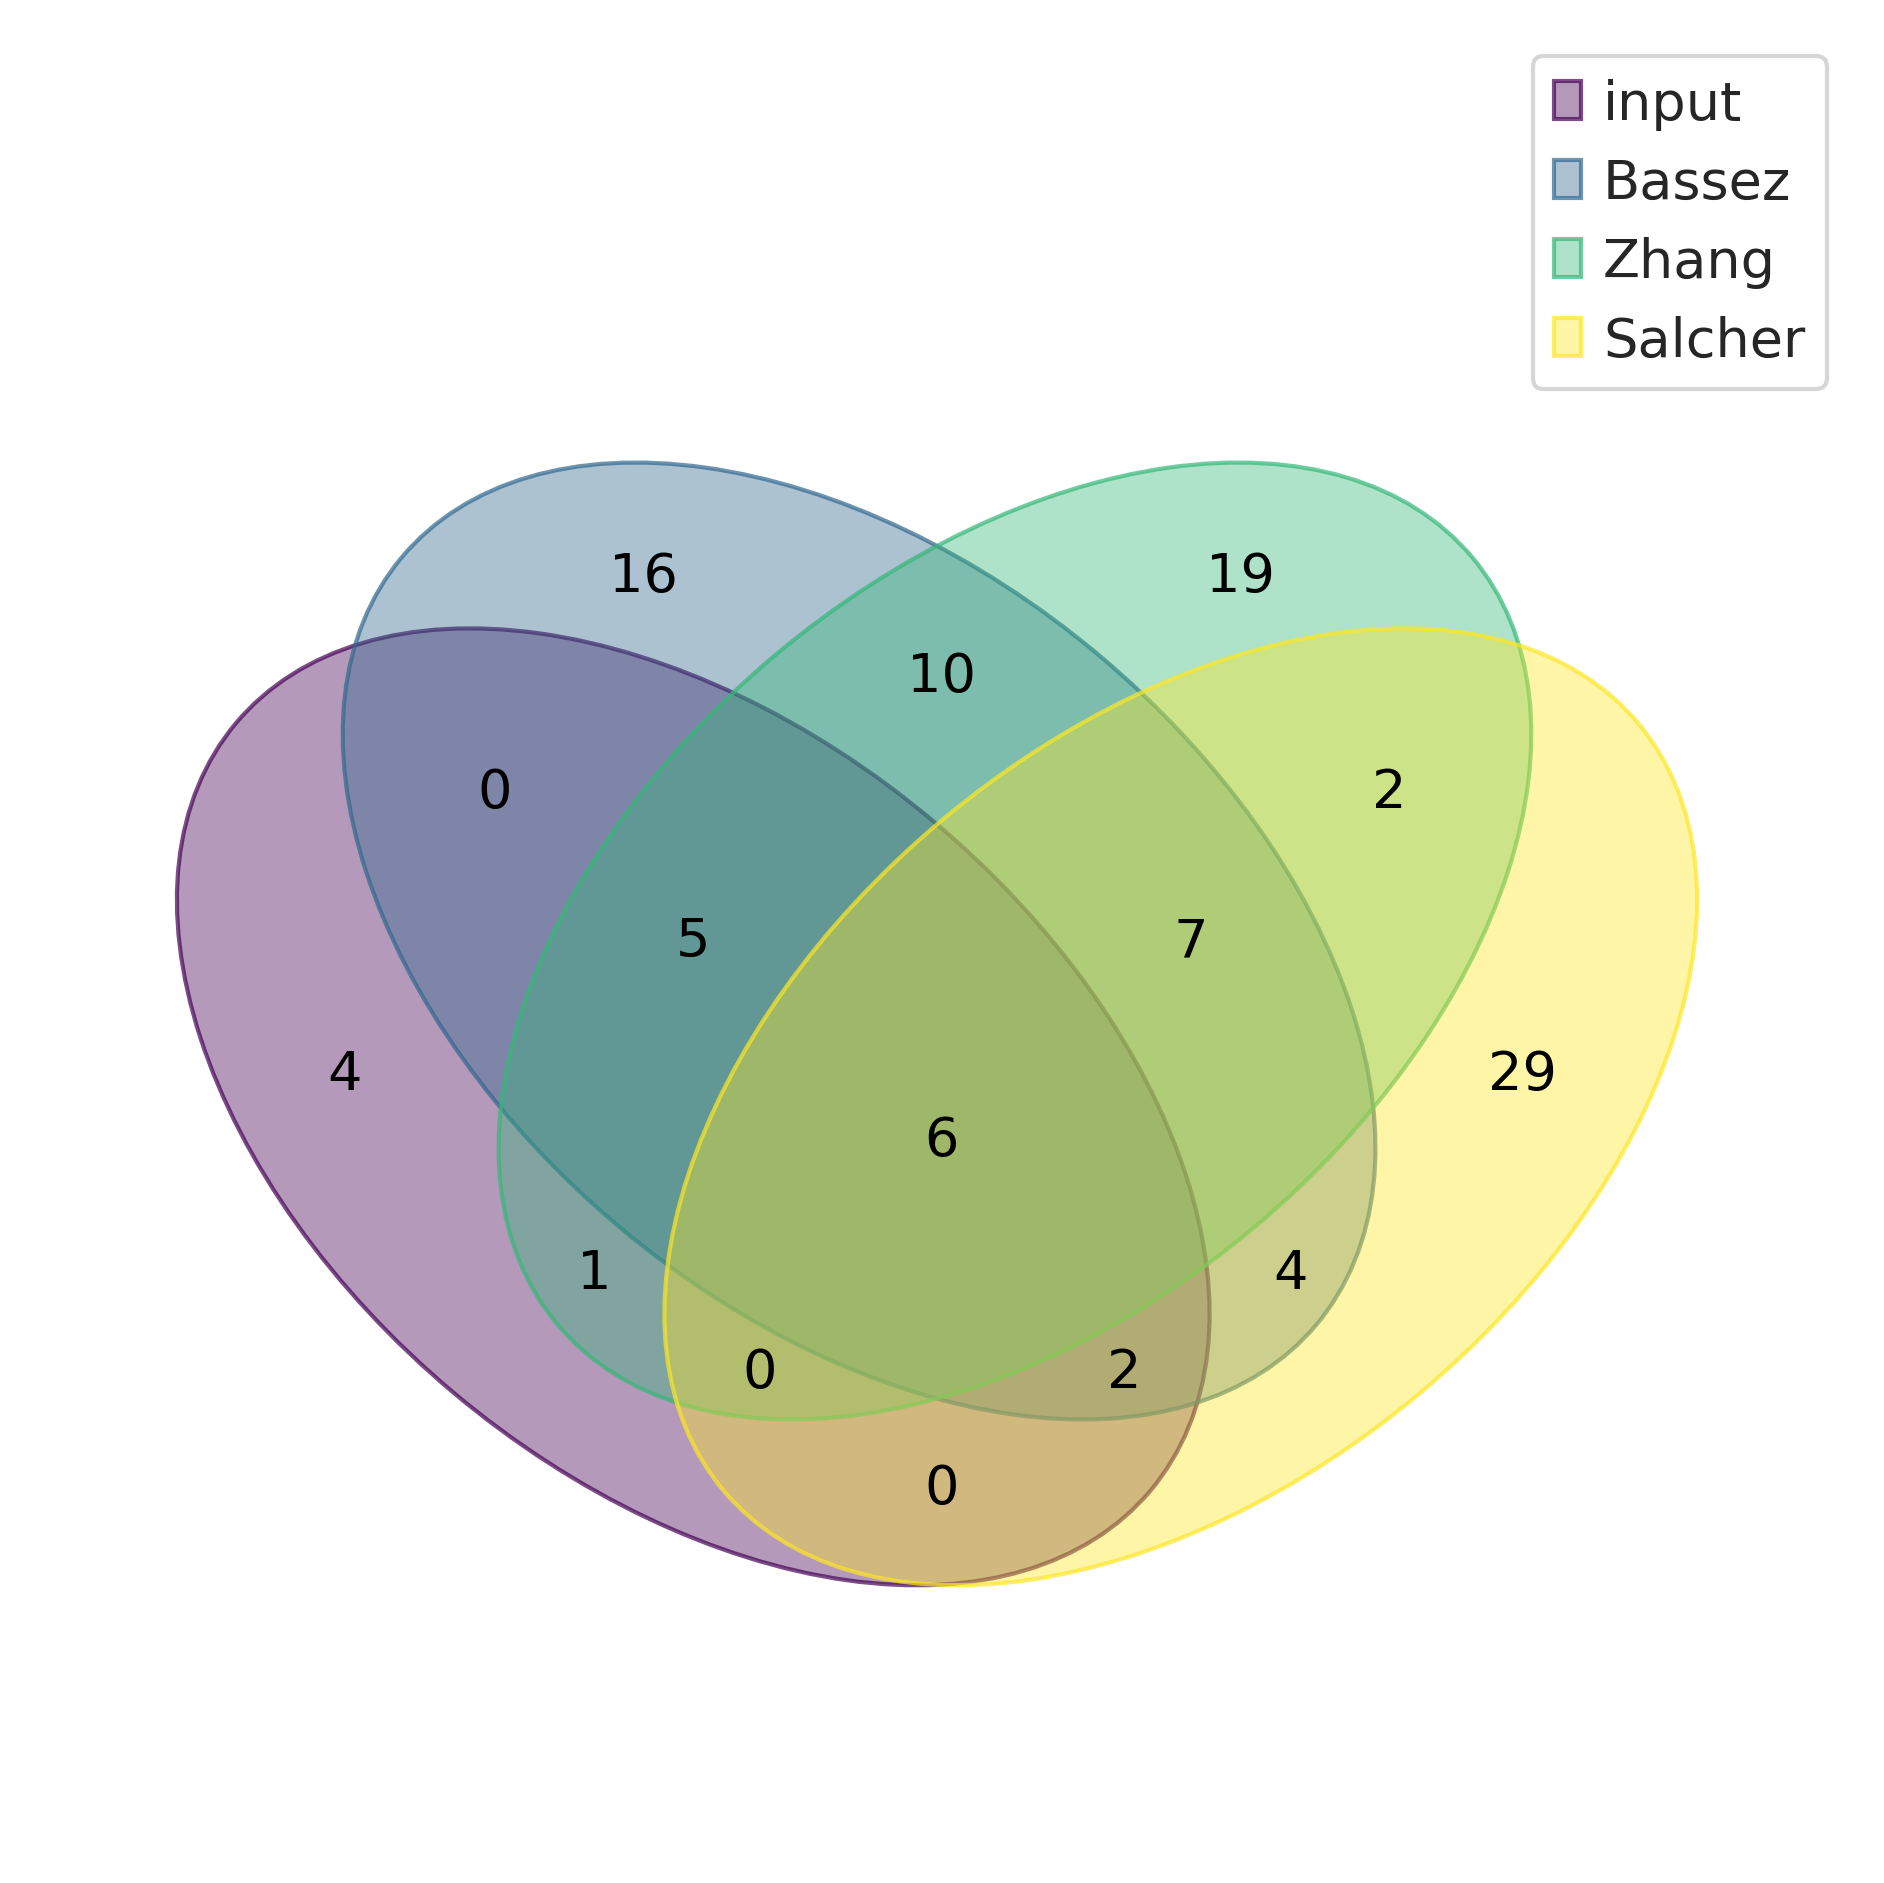

In [15]:
venn.venn({'input':input_genes, 'Bassez':output_genes, 'Zhang':Zhang_et_al, 'Salcher':Salcher_et_al})
save_fig_path = fig_save_path+'Venn_Salcher_0.001_Zhang_Bassez'+'LYSmeta'+'.svg'
plt.savefig(save_fig_path,dpi=300)
print('saved Figure to:',save_fig_path)

In [17]:
all_factors = ['0-X-global-X-all_carnitine-shuttle', '1-X-global-X-1', '2-X-global-X-all_SASP', '3-X-global-X-3', '4-X-global-X-all_PI3K-AKT-mTOR_signaling', '5-X-global-X-all_eicosanoid_metabolism', '6-X-global-X-6', '7-X-global-X-mast_granule-exocytosis', '8-X-global-X-all_polyamines_metabolism', '9-X-global-X-all_taurine-hypotaurine_metabolism', '10-X-global-X-all_ARG-PRO_metabolism', '11-X-global-X-11', '12-X-global-X-12', '13-X-global-X-all_transmembrane-transport-mitochondrial', '14-X-global-X-all_GPI-anchor_synthesis', '15-X-global-X-all_fructose-mannose_metabolism', '16-X-global-X-all_selenoamino-acid_metabolism', '17-X-global-X-all_DNA-demethylation', '18-X-global-X-18', '19-X-global-X-all_pyrimidine_synthesis', '20-X-global-X-all_purine_metabolism', '21-X-global-X-all_CoA_synthesis', '22-X-global-X-22', '23-X-global-X-23', '24-X-global-X-24', '25-X-global-X-25', '26-X-global-X-all_transmembrane-transport-golgi', '27-X-global-X-all_protein-degradation-proteasome', '28-X-global-X-all_keratan-sulfate_synthesis', '29-X-global-X-all_G2M-transition', '30-X-global-X-all_urea-cycle', '31-X-global-X-all_macroautophagy', '32-X-global-X-all_thiamin_metabolism', '33-X-global-X-all_fatty-acid_synthesis', '34-X-global-X-all_TLR_signaling', '35-X-global-X-all_chondroitine-sulfate_degradation', '36-X-global-X-all_G1S-transition', '37-X-global-X-37', '38-X-global-X-all_carnitine-shuttle', '39-X-global-X-all_TYR_metabolism', '40-X-global-X-all_cytosolic-DNA-sensing_signaling', '41-X-global-X-all_bile-acid_synthesis', '42-X-global-X-mast_granule-exocytosis', '43-X-global-X-43', '44-X-global-X-all_oxidative-phosphorylation', '45-X-global-X-all_microautophagy-lysosomal', '46-X-global-X-46', '47-X-global-X-all_cyclic-nucleotide_metabolism', '48-X-global-X-48', '49-X-global-X-all_mitotic-spindle-component', '50-X-global-X-50', '51-X-global-X-51', '52-X-global-X-52', '53-X-global-X-all_folate_metabolism', '54-X-global-X-all_retinol_metabolism', '55-X-global-X-all_type-I-ifn-response', '56-X-global-X-all_LYS_metabolism', '57-X-global-X-all_glycerin-SER-THR_metabolism', '58-X-global-X-all_sphingolipid_metabolism', '59-X-global-X-all_phosphoinositide_signaling', '60-X-global-X-all_ketone-body_metabolism', '61-X-global-X-all_pyroptosis', '62-X-global-X-all_wnt-beta-catenin-signaling', '63-X-global-X-all_keratan-sulfate_degradation', '64-X-global-X-64', '65-X-global-X-all_ubiquinone_synthesis', '66-X-global-X-all_type-II-ifn-response', '67-X-global-X-67', '68-X-global-X-all_mitotic-spindle-component', '69-X-global-X-69', '70-X-global-X-all_biotin_metabolism', '71-X-global-X-all_platelet-activation-factor_production', '72-X-global-X-72', '73-X-global-X-all_coagulation-factor_production', '74-X-global-X-74', '75-X-global-X-all_TNF-via-NFkB_signaling', '76-X-global-X-all_glycogenolysis', '77-X-global-X-all_NOTCH_signaling', '78-X-global-X-all_thrombolysis-factor_production', '79-X-global-X-all_macroautophagy', '80-X-global-X-all_fatty-acid-beta-oxidation-mitochondrial', '81-X-global-X-81', '82-X-global-X-all_MET_metabolism', '83-X-global-X-all_ethanol_metabolism', '84-X-global-X-all_mitotic-spindle-component', '85-X-global-X-85', '86-X-global-X-all_riboflavin_metabolism', '87-X-global-X-all_p53-signaling', '88-X-global-X-all_steroid_metabolism', '89-X-global-X-all_DNA_synthesis', '90-X-global-X-all_pyrimidine_metabolism', '91-X-global-X-91', '92-X-global-X-all_o-glycan_synthesis', '93-X-global-X-all_transmembrane-transport-ER', '94-X-global-X-94', '95-X-global-X-all_transmembrane-transport-cellmembrane', '96-X-global-X-all_propanoate_metabolism', '97-X-global-X-all_ROS-detoxification', '98-X-global-X-all_posttranslation-modification', '99-X-global-X-all_reticulophagy', '100-X-global-X-100', '101-X-global-X-all_TCA-cycle', '102-X-global-X-102', '103-X-global-X-103', '104-X-global-X-all_exocytosis', '105-X-global-X-all_CYP_metabolism', '106-X-global-X-106', '107-X-global-X-all_heparan-sulfate_degradation', '108-X-global-X-108', '109-X-global-X-109', '110-X-global-X-all_unfolded-protein-response', '111-X-global-X-all_apoptosis', '112-X-global-X-all_hypoxia-response', '113-X-global-X-all_ALA-ASP_metabolism', '114-X-global-X-all_histone-methylation', '115-X-global-X-all_creatinine_metabolism', '116-X-global-X-all_mitophagy_regulation_positive', '117-X-global-X-all_protein-degradation-proteasome', '118-X-global-X-all_GABA-shunt', '119-X-global-X-all_osmotic-stress-response', '120-X-global-X-all_mTORC1_signaling', '121-X-global-X-all_DNA-methylation', '122-X-global-X-all_glycerophospholipid_metabolism', '123-X-global-X-all_actin-cytoskeleton_regulation', '124-X-global-X-all_ascorbate-uptake', '125-X-global-X-all_autophagy-chaperone-mediated', '126-X-global-X-126', '127-X-global-X-B_effector-2_UP', '128-X-global-X-128', '129-X-global-X-129', '130-X-global-X-all_peroxisome-component', '131-X-global-X-all_mitophagy_regulation_positive', '132-X-global-X-132', '133-X-global-X-all_glycogenesis', '134-X-global-X-all_IL6-JAK-STAT3_signaling', '135-X-global-X-all_DNA-repair', '136-X-global-X-all_inositol-phosphate_metabolism', '137-X-global-X-all_MYC_targets', '138-X-global-X-all_TRP_metabolism', '139-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism', '140-X-global-X-all_GLU_metabolism', '141-X-global-X-all_pentose-phosphate-pathway', '142-X-global-X-all_n-glycan_synthesis', '143-X-global-X-all_Beta-Ala_metabolism', '144-X-global-X-all_autophagy-chaperone-mediated', '145-X-global-X-all_nucleotide_metabolism', '146-X-global-X-146', '147-X-global-X-147', '148-X-B-X-148', '149-X-B-X-149', '150-X-B-X-B_effector-1_UP', '151-X-B-X-151', '152-X-B-X-152', '153-X-B-X-B_IgM-ligation_response', '154-X-B-X-154', '155-X-CD4-T-X-155', '156-X-CD4-T-X-156', '157-X-CD4-T-X-CD4-T_TFH_UP', '158-X-CD4-T-X-158', '159-X-CD4-T-X-CD4-T_TH22_UP', '160-X-CD4-T-X-CD4-T_TH1_UP', '161-X-CD4-T-X-161', '162-X-CD4-T-X-CD4-T_TH17_UP', '163-X-CD4-T-X-163', '164-X-CD4-T-X-B_effector-2_UP', '165-X-CD4-T-X-165', '166-X-CD4-T-X-166', '167-X-CD4-T-X-167', '168-X-CD4-T-X-168', '169-X-CD4-T-X-TNK_cytotoxicity-effectors', '170-X-CD4-T-X-TNK_IL2-STAT5-signaling', '171-X-CD4-T-X-171', '172-X-CD8-T-X-172', '173-X-CD8-T-X-CD8-T_IL12_response', '174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP', '175-X-CD8-T-X-175', '176-X-CD8-T-X-176', '177-X-CD8-T-X-T_IL4_response', '178-X-CD8-T-X-178', '179-X-CD8-T-X-179', '180-X-CD8-T-X-TNK_cytotoxicity-effectors', '181-X-CD8-T-X-TNK_IL2-STAT5-signaling', '182-X-CD8-T-X-CD4-T_TH1_UP', '183-X-DC-X-183', '184-X-DC-X-184', '185-X-DC-X-185', '186-X-DC-X-186', '187-X-DC-X-187', '188-X-Mac-X-188', '189-X-Mac-X-189', '190-X-Mac-X-190', '191-X-Mac-X-191', '192-X-Mac-X-192', '193-X-Mac-X-193', '194-X-Mac-X-194', '195-X-Mac-X-195', '196-X-NK-X-TNK_cytotoxicity-effectors', '197-X-NK-X-197', '198-X-T-X-CD4-T_TH1_UP', '199-X-T-X-T_IL21_response', '200-X-T-X-200', '201-X-T-X-201', '202-X-T-X-202', '203-X-T-X-CD4-T_TFH_UP', '204-X-T-X-204', '205-X-T-X-205', '206-X-T-X-206', '207-X-T-X-207', '208-X-T-X-208', '209-X-T-X-209', '210-X-T-X-CD8-T_IL12_response', '211-X-T-X-CD8-T_tumor-reactive-like_UP', '212-X-T-X-212', '213-X-T-X-213', '214-X-T-X-TNK_cytotoxicity-effectors', '215-X-T-X-TNK_IL2-STAT5-signaling', '216-X-T-X-216', '217-X-Treg-X-217', '218-X-Treg-X-CD8-T_tumor-reactive-like_UP', '219-X-endo-X-219', '220-X-endo-X-220', '221-X-endo-X-221', '222-X-epi-X-lung-epi_IL4_response', '223-X-epi-X-223', '224-X-epi-X-224', '225-X-epi-X-225', '226-X-fibro-X-fibro_IGF1_response', '227-X-fibro-X-227', '228-X-fibro-X-228', '229-X-fibro-X-229', '230-X-fibro-X-230', '231-X-fibro-X-231', '232-X-fibro-X-232', '233-X-fibro-X-233', '234-X-gran-X-234', '235-X-gran-X-235', '236-X-mast-X-236', '237-X-mast-X-237', '238-X-plasma-X-238', '239-X-plasma-X-239', '240-X-plasma-X-240', '241-X-plasma-X-241', '242-X-plasma-X-B_effector-2_UP', '243-X-plasma-X-243', '244-X-plasma-X-244']

In [ ]:
immune_celltypes = ['B',
 'CD4-T',
 'CD8-T',
 'DC',
 'Mac',
 'NK',
 'T',
 'Treg',
 'gran',
 'mast',
 'plasma']

adata_immune = adata[adata.obs['annotation_Spectra'].isin(immune_celltypes)]
adata_immune

In [22]:
all_cell_props = pd.DataFrame(index=list(set(adata_immune.obs['study'])))
for i in all_factors:
    adata_immune_subset = adata_immune[adata_immune.obs[i][adata_immune.obs[i]>0.001].index]
    if len(adata_immune_subset)>100:
        cell_proportions = adata_immune_subset.obs['study'].value_counts(normalize=True)
        all_cell_props.loc[:,i] = cell_proportions

/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_cell_props.loc[:,i] = cell_proportions
/scratch/lsftmp/17964962.tmpdir/ipykernel_181655/2687314052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

In [23]:
all_cell_props = all_cell_props.fillna(0)
all_cell_props

0-X-global-X-all_carnitine-shuttle  1-X-global-X-1  \
Travaglini_Krasnow_2020                              0.000000        0.000166   
Kim_Lee_2020                                         0.003902        0.032692   
Lambrechts_Thienpont_2018                            0.006132        0.016885   
UKIM-V                                               0.159420        0.222818   
Adams_Kaminski_2020                                  0.484392        0.410896   
Reyfman_Misharin_2018                                0.003344        0.008584   
Habermann_Kropski_2020                               0.013935        0.013800   
Goveia_Carmeliet_2020                                0.003344        0.003180   
Wu_Zhou_2021                                         0.026198        0.012332   
Laughney_Massague_2020                               0.000000        0.008154   
Zilionis_Klein_2019                                  0.083055        0.019307   
Vieira_Teichmann_2019                                0.018952        0.001665   
Mayr_Schiller_2020                                   0.073021        0.004553   
Guo_Zhang_2018                                       0.000000        0.006687   
Maynard_Bivona_2020                                  0.001672        0.001377   
Chen_Zhang_2020                                      0.051839        0.059641   
Madissoon_Meyer_2020                                 0.000557        0.004986   
He_Fan_2021                                          0.025641        0.009819   
Leader_Merad_2021                                    0.044593        0.162459   

                           2-X-global-X-all_SASP  3-X-global-X-3  \
Travaglini_Krasnow_2020                 0.000332        0.001191   
Kim_Lee_2020                            0.117380        0.085468   
Lambrechts_Thienpont_2018               0.047776        0.052048   
UKIM-V                                  0.055388        0.061076   
Adams_Kaminski_2020                     0.191436        0.088247   
Reyfman_Misharin_2018                   0.007818        0.011101   
Habermann_Kropski_2020                  0.016608        0.013850   
Goveia_Carmeliet_2020                   0.017913        0.013321   
Wu_Zhou_2021                            0.061992        0.011542   
Laughney_Massague_2020                  0.012968        0.013909   
Zilionis_Klein_2019                     0.021358        0.025392   
Vieira_Teichmann_2019                   0.005197        0.003558   
Mayr_Schiller_2020                      0.002793        0.010851   
Guo_Zhang_2018                          0.000320        0.027288   
Maynard_Bivona_2020                     0.028524        0.003440   
Chen_Zhang_2020                         0.086452        0.083115   
Madissoon_Meyer_2020                    0.082000        0.018687   
He_Fan_2021                             0.048131        0.021540   
Leader_Merad_2021                       0.195614        0.454377   

                           4-X-global-X-all_PI3K-AKT-mTOR_signaling  \
Travaglini_Krasnow_2020                                    0.002436   
Kim_Lee_2020                                               0.047947   
Lambrechts_Thienpont_2018                                  0.028476   
UKIM-V                                                     0.440739   
Adams_Kaminski_2020                                        0.040823   
Reyfman_Misharin_2018                                      0.002876   
Habermann_Kropski_2020                                     0.011462   
Goveia_Carmeliet_2020                                      0.003727   
Wu_Zhou_2021                                               0.013081   
Laughney_Massague_2020                                     0.012574   
Zilionis_Klein_2019                                        0.053966   
Vieira_Teichmann_2019                                      0.001531   
Mayr_Schiller_2020                                         0.003596   
Guo_Zhang_2018                                     

In [24]:
print('expected max entropy is:',scipy.stats.entropy(len(all_cell_props.index)*[1/len(all_cell_props.index)]) )
print('entropy in 8 study:',scipy.stats.entropy((len(all_cell_props.index)-8)*[0]+[1/8,1/8,1/8,1/8,1/8,
                                                                                    1/8,1/8,1/8,]))
print('entropy in 2 study:',scipy.stats.entropy((len(all_cell_props.index)-2)*[0]+[1/2,1/2]))
print('entropy in 2 study:',scipy.stats.entropy((len(all_cell_props.index)-3)*[0]+[1/3,1/3,1/3]))

expected max entropy is: 2.9444389791664403
entropy in 8 study: 2.0794415416798357
entropy in 2 study: 0.6931471805599453
entropy in 2 study: 1.0986122886681096


In [25]:
#calculate entropy:
entropy_df = pd.DataFrame()

for i in all_cell_props.columns:
    entropy_df.loc[i,'entropy'] = scipy.stats.entropy(all_cell_props[i])

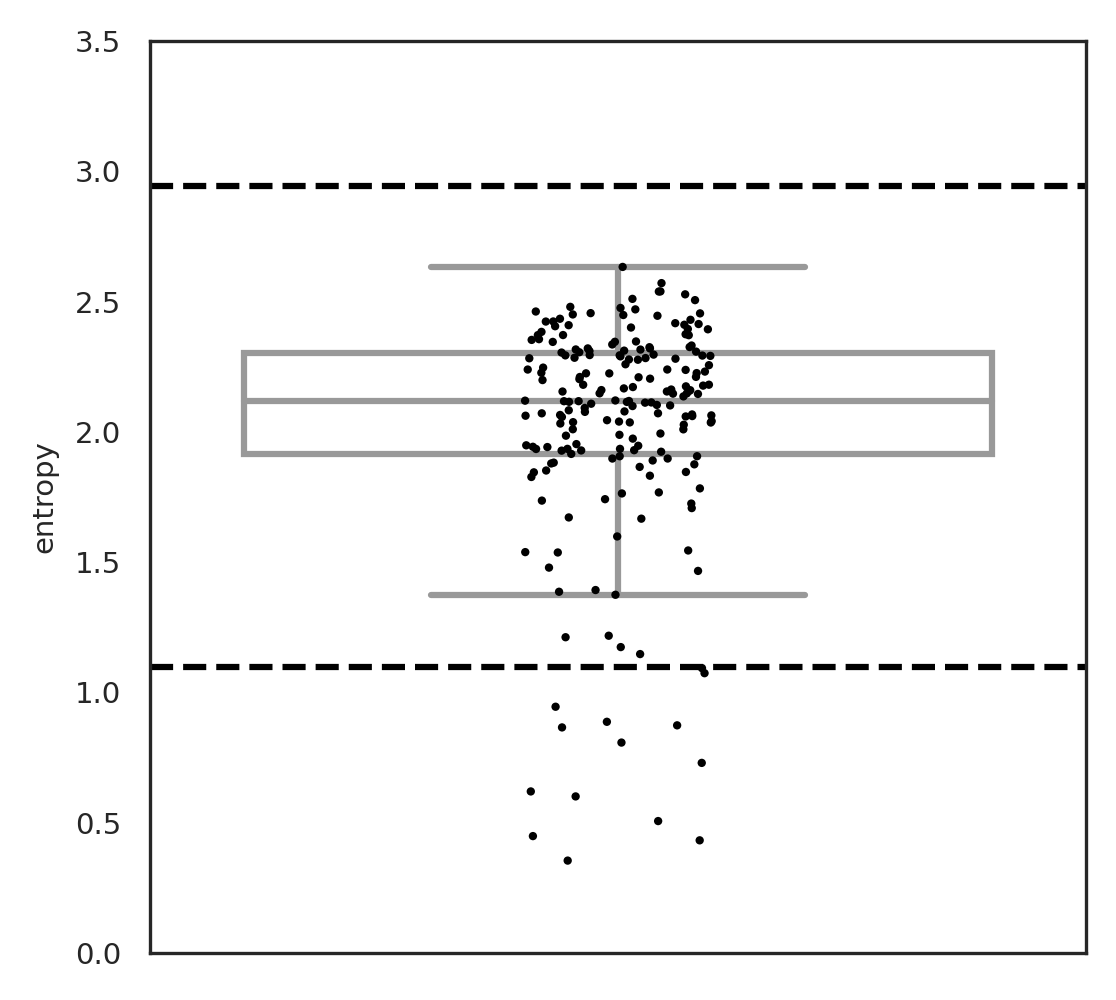

In [26]:
#plot entrooy
save_name = 'Salcher_study_entropy.svg'
sns.boxplot(y="entropy", #hue='study',
            data=entropy_df,fliersize=0,color='#FFFFFF',
            #order=order_list,
           #palette={'Primary':'#0E518F', 'Metastasis':'#DF480F', 'Non-Tumor':'#FFFFFF'}
           )
sns.stripplot( y="entropy", #hue='study',
              data=entropy_df,
              #order=order_list,
              color='#000000',dodge=True,s=2)
plt.axhline(scipy.stats.entropy(len(all_cell_props.index)*[1/len(all_cell_props.index)]),color='#000000',ls='--')
plt.axhline(scipy.stats.entropy((len(all_cell_props.index)-3)*[0]+[1/3,1/3,1/3]),color='#000000',ls='--')
plt.ylim(0,3.5)
plt.savefig(fig_save_path+save_name)

In [30]:
#prepare global factors for plotting
plot_factors = list(entropy_df[entropy_df['entropy']< scipy.stats.entropy((len(all_cell_props.index)-3)*[0]+[1/3,1/3,1/3])].sort_values('entropy').index)
plot_factors.remove( '235-X-gran-X-235')#remove cell type spec factors
plot_factors.remove( '234-X-gran-X-234') #remove cell type spec factors
plot_factors.remove( '241-X-plasma-X-241')#remove cell type spec factors

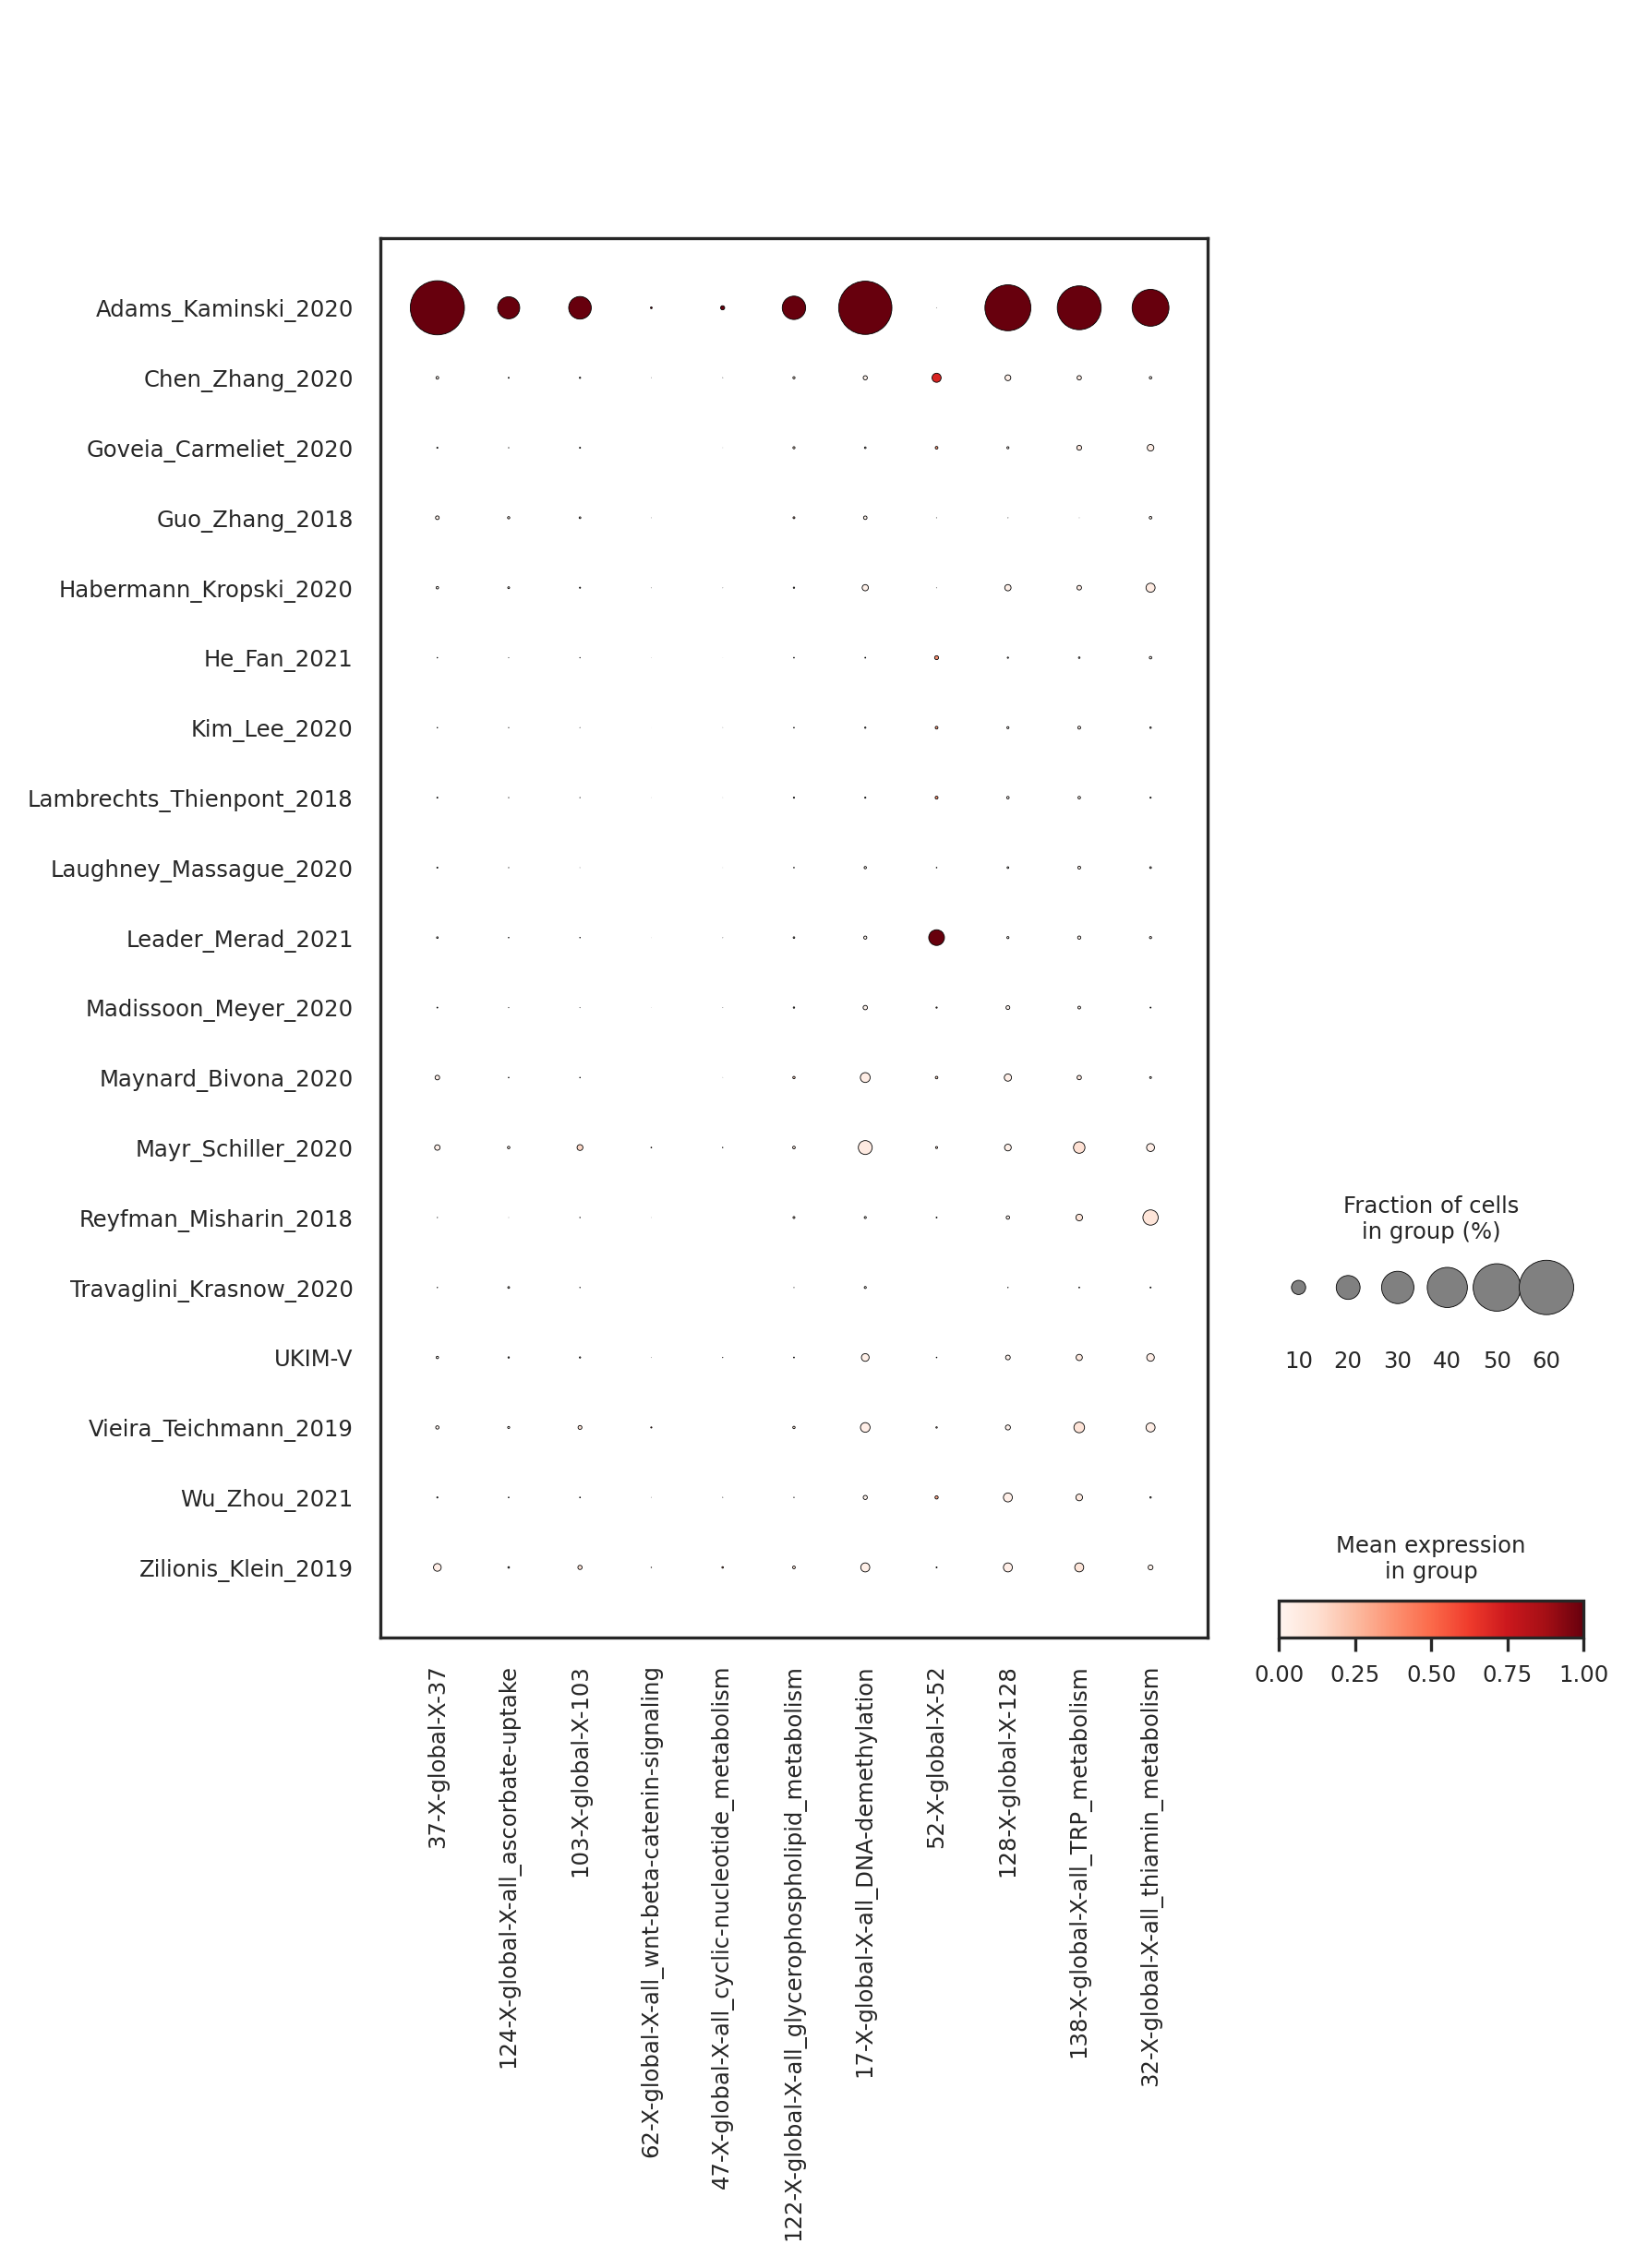

In [31]:
sns.set_style('white')
sc.pl.dotplot(adata_immune,plot_factors, 'study',
              standard_scale='var',return_fig=False,expression_cutoff=0.001,
              save='Salcher_0.01_allfactors_x_studies.svg')

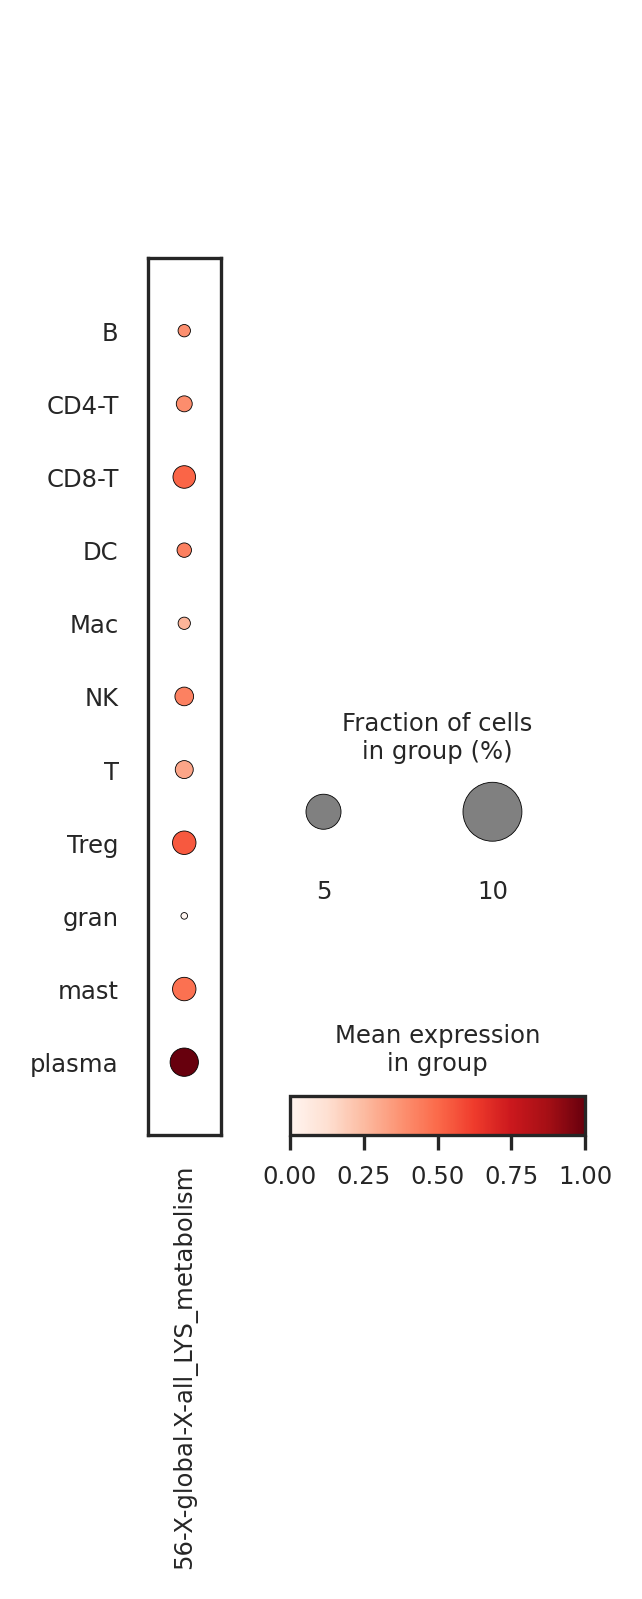

In [34]:
sns.set_style('white')
sc.pl.dotplot(adata_immune, ['56-X-global-X-all_LYS_metabolism'], 'annotation_Spectra',
              standard_scale='var',return_fig=False,expression_cutoff=0.001,save='Salcher_0.01_Lys_perceltype.svg')


In [35]:
donor_num = pd.DataFrame()
for study in set(adata_immune.obs['study']):
    adata_immune_study= adata_immune[adata_immune.obs['study']==study]
    donor_num.loc[study,'donor_num'] = len(set(adata_immune_study.obs['donor_id']))
donor_num

donor_num
Travaglini_Krasnow_2020          3.0
Kim_Lee_2020                    44.0
Lambrechts_Thienpont_2018        8.0
UKIM-V                          17.0
Adams_Kaminski_2020             46.0
Reyfman_Misharin_2018            8.0
Habermann_Kropski_2020          10.0
Goveia_Carmeliet_2020            7.0
Wu_Zhou_2021                    42.0
Laughney_Massague_2020          14.0
Zilionis_Klein_2019              7.0
Vieira_Teichmann_2019            4.0
Mayr_Schiller_2020              10.0
Guo_Zhang_2018                  13.0
Maynard_Bivona_2020             29.0
Chen_Zhang_2020                 11.0
Madissoon_Meyer_2020             5.0
He_Fan_2021                      5.0
Leader_Merad_2021               35.0

In [36]:
donor_num['study'] = donor_num.index
donor_num['donor_num'] = donor_num['donor_num'].astype(int)

In [37]:
donor_num = donor_num.sort_values(by='donor_num',ascending=False)

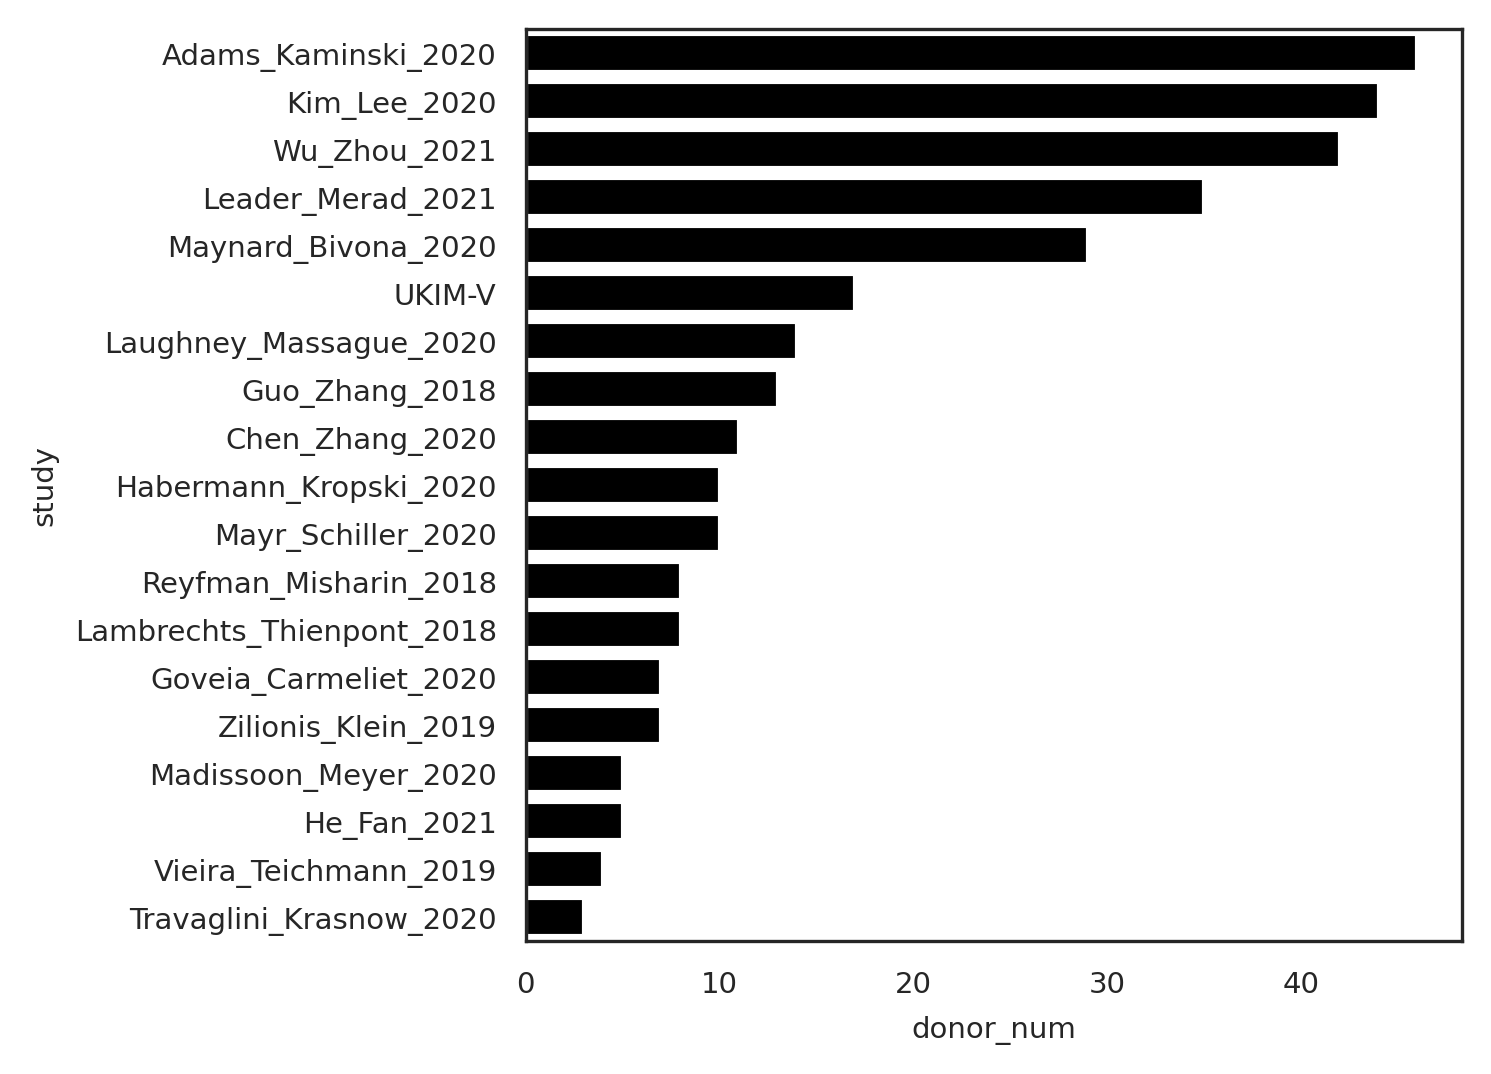

In [38]:
save_name= 'Salcher_patient_number_barplot.svg'
sns.barplot(data=donor_num, x='donor_num', y='study',color='000000')
plt.savefig(fig_save_path+save_name)

In [39]:
mean_df = adata_immune_study.obs[['56-X-global-X-all_LYS_metabolism','annotation_Spectra']].groupby('annotation_Spectra').mean()

In [40]:
mean_sample_celltype_df = pd.DataFrame()

for sample in set(adata_immune.obs['study']):
    adata_immune_sample= adata_immune[adata_immune.obs['study']==sample]
    mean_df = adata_immune_sample.obs[['56-X-global-X-all_LYS_metabolism','annotation_Spectra']].groupby('annotation_Spectra').mean()
    for i in mean_df.index:
        mean_sample_celltype_df.loc[i,sample] = mean_df.loc[i,'56-X-global-X-all_LYS_metabolism']
    print('added sample:',sample)

added sample: Travaglini_Krasnow_2020
added sample: Kim_Lee_2020
added sample: Lambrechts_Thienpont_2018
added sample: UKIM-V
added sample: Adams_Kaminski_2020
added sample: Reyfman_Misharin_2018
added sample: Habermann_Kropski_2020
added sample: Goveia_Carmeliet_2020
added sample: Wu_Zhou_2021
added sample: Laughney_Massague_2020
added sample: Zilionis_Klein_2019
added sample: Vieira_Teichmann_2019
added sample: Mayr_Schiller_2020
added sample: Guo_Zhang_2018
added sample: Maynard_Bivona_2020
added sample: Chen_Zhang_2020
added sample: Madissoon_Meyer_2020
added sample: He_Fan_2021
added sample: Leader_Merad_2021


In [41]:
mean_sample_celltype_df_zscored = mean_sample_celltype_df.fillna(0)
mean_sample_celltype_df_zscored = scipy.stats.zscore(mean_sample_celltype_df_zscored)
mean_sample_celltype_df_zscored

Travaglini_Krasnow_2020  Kim_Lee_2020  Lambrechts_Thienpont_2018  \
B                      0.866365     -0.796505                  -0.256653   
CD4-T                  0.095922     -0.996640                  -0.441322   
CD8-T                  0.185803      0.025394                   0.357758   
DC                     0.976935     -1.092140                  -0.080596   
Mac                   -0.658437     -1.357518                  -0.335662   
NK                    -0.104075     -0.656961                  -0.041368   
T                     -0.999764      1.117460                   0.469501   
Treg                   2.322640      0.529328                   0.198738   
gran                  -0.914834      0.465516                  -2.567359   
mast                  -0.820560      0.966124                   1.383344   
plasma                -0.949996      1.795943                   1.313619   

          UKIM-V  Adams_Kaminski_2020  Reyfman_Misharin_2018  \
B      -0.015933             0.026991               0.188446   
CD4-T  -0.252040             0.554261               0.047090   
CD8-T  -0.038468             0.471873               0.162714   
DC     -0.173230            -0.453828              -0.255129   
Mac    -0.347172            -0.121470              -0.164287   
NK     -0.305795             0.296646              -0.308447   
T      -0.554209             0.310109              -1.217971   
Treg   -0.163666             0.111060              -0.145783   
gran   -0.928883            -2.294437              -1.217971   
mast   -0.288309            -0.896989               0.128555   
plasma  3.067705             1.995784               2.782784   

        Habermann_Kropski_2020  Goveia_Carmeliet_2020  Wu_Zhou_2021  \
B                    -0.256708              -1.220934     -0.589400   
CD4-T                -0.200996              -0.617545     -0.711447   
CD8-T                 1.048546              -0.212203      0.328369   
DC                   -1.468550               0.492885      0.098740   
Mac                  -0.855908              -1.044885      0.272867   
NK                    0.298769              -0.790533     -0.778770   
T                     0.621352              -0.358312     -0.644546   
Treg                  0.180396              -0.022637      1.307986   
gran                 -1.361914               1.519849     -1.924355   
mast                 -0.132162               0.091915      1.193274   
plasma                2.127176               2.162400      1.447281   

        Laughney_Massague_2020  Zilionis_Klein_2019  Vieira_Teichmann_2019  \
B                    -0.463663            -0.350314              -1.818726   
CD4-T                -0.389094            -0.564417              -0.226028   
CD8-T                 0.179558            -0.430338               0.366289   
DC                    0.276004             0.079839               0.559986   
Mac                  -0.075879             0.028383              -0.585703   
NK                   -0.126872            -0.489773               0.952491   
T                    -0.505766            -0.118261              -1.820223   
Treg                  0.434022            -0.363596               1.325742   
gran                 -2.292343            -0.922261               0.786511   
mast                  1.028368             0.111245              -0.042253   
plasma                1.935665             3.019493               0.501914   

        Mayr_Schiller_2020  Guo_Zhang_2018  Maynard_Bivona_2020  \
B                -0.746001       -1.327621             1.795428   
CD4-T            -0.650976        0.821440            -0.003252   
CD8-T            -0.507343        0.778744             0.521294   
DC               -0.157138        0.447494             0.043850   
Mac              -0.691507        0.224700            -0.637670   
NK                0.164644        0.406123             0.236290   
T                 1.994658        1.751610            -0.357775   


In [42]:
#max celltype
max_celltype =pd.DataFrame()
for i in mean_sample_celltype_df_zscored.columns:
    max_celltype.loc[i,'celltype'] = mean_sample_celltype_df_zscored[i].sort_values().index[-1]
max_celltype

celltype
Travaglini_Krasnow_2020       Treg
Kim_Lee_2020                plasma
Lambrechts_Thienpont_2018     mast
UKIM-V                      plasma
Adams_Kaminski_2020         plasma
Reyfman_Misharin_2018       plasma
Habermann_Kropski_2020      plasma
Goveia_Carmeliet_2020       plasma
Wu_Zhou_2021                plasma
Laughney_Massague_2020      plasma
Zilionis_Klein_2019         plasma
Vieira_Teichmann_2019         Treg
Mayr_Schiller_2020          plasma
Guo_Zhang_2018                   T
Maynard_Bivona_2020              B
Chen_Zhang_2020               mast
Madissoon_Meyer_2020        plasma
He_Fan_2021                 plasma
Leader_Merad_2021           plasma

In [44]:
#max celltype
max_celltype =pd.DataFrame()
for i in mean_sample_celltype_df_zscored.columns:
    max_celltype.loc[i,'celltype'] = mean_sample_celltype_df_zscored[i].sort_values().index[-2]
max_celltype

celltype
Travaglini_Krasnow_2020         DC
Kim_Lee_2020                     T
Lambrechts_Thienpont_2018   plasma
UKIM-V                           B
Adams_Kaminski_2020          CD4-T
Reyfman_Misharin_2018            B
Habermann_Kropski_2020       CD8-T
Goveia_Carmeliet_2020         gran
Wu_Zhou_2021                  Treg
Laughney_Massague_2020        mast
Zilionis_Klein_2019           mast
Vieira_Teichmann_2019           NK
Mayr_Schiller_2020               T
Guo_Zhang_2018               CD4-T
Maynard_Bivona_2020           Treg
Chen_Zhang_2020              CD8-T
Madissoon_Meyer_2020            NK
He_Fan_2021                   Treg
Leader_Merad_2021             gran

In [45]:
#max celltype
max_celltype =pd.DataFrame()
for i in mean_sample_celltype_df_zscored.columns:
    max_celltype.loc[i,'celltype'] = mean_sample_celltype_df_zscored[i].sort_values().index[-3]
max_celltype

celltype
Travaglini_Krasnow_2020          B
Kim_Lee_2020                  mast
Lambrechts_Thienpont_2018        T
UKIM-V                       CD8-T
Adams_Kaminski_2020          CD8-T
Reyfman_Misharin_2018        CD8-T
Habermann_Kropski_2020           T
Goveia_Carmeliet_2020           DC
Wu_Zhou_2021                  mast
Laughney_Massague_2020        Treg
Zilionis_Klein_2019             DC
Vieira_Teichmann_2019         gran
Mayr_Schiller_2020              NK
Guo_Zhang_2018               CD8-T
Maynard_Bivona_2020          CD8-T
Chen_Zhang_2020             plasma
Madissoon_Meyer_2020         CD8-T
He_Fan_2021                   mast
Leader_Merad_2021               DC

In [46]:
#max celltype
max_celltype =pd.DataFrame()
for i in mean_sample_celltype_df_zscored.columns:
    max_celltype.loc[i,'celltype'] = mean_sample_celltype_df_zscored[i].sort_values().index[-4]
max_celltype

celltype
Travaglini_Krasnow_2020      CD8-T
Kim_Lee_2020                  Treg
Lambrechts_Thienpont_2018    CD8-T
UKIM-V                        Treg
Adams_Kaminski_2020              T
Reyfman_Misharin_2018         mast
Habermann_Kropski_2020          NK
Goveia_Carmeliet_2020         mast
Wu_Zhou_2021                 CD8-T
Laughney_Massague_2020          DC
Zilionis_Klein_2019            Mac
Vieira_Teichmann_2019           DC
Mayr_Schiller_2020            Treg
Guo_Zhang_2018                  DC
Maynard_Bivona_2020         plasma
Chen_Zhang_2020                 NK
Madissoon_Meyer_2020          gran
He_Fan_2021                     DC
Leader_Merad_2021               NK

saved to: Salcher_LYS_mean_zscore_barplot.svg


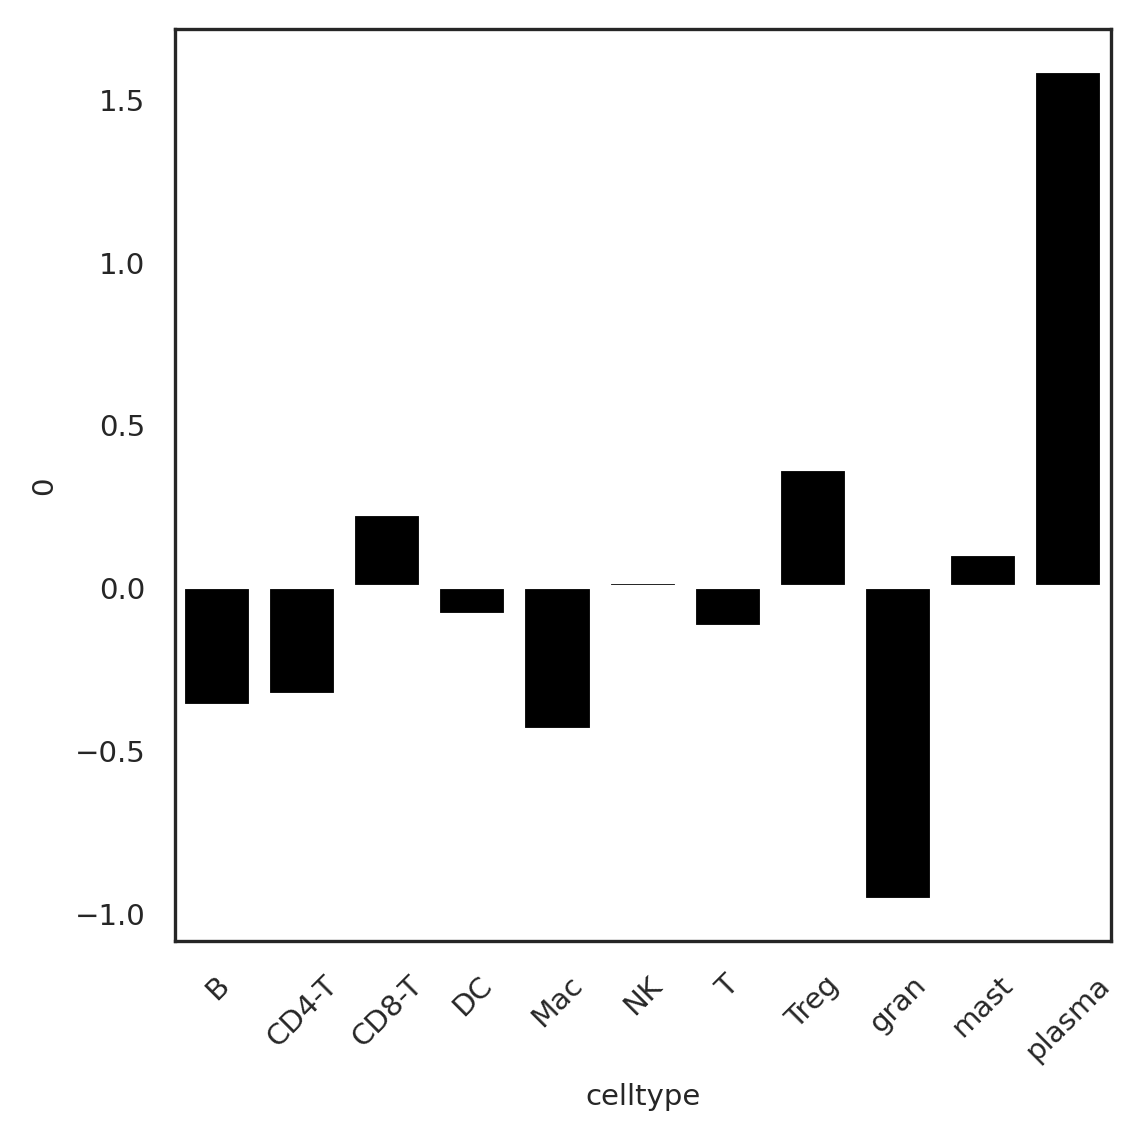

In [48]:
save_name= 'Salcher_LYS_mean_zscore_barplot.svg'
sns.set_style('white')
df_plot = pd.DataFrame(np.mean(mean_sample_celltype_df_zscored,axis=1))
df_plot['celltype']=df_plot.index
bar = sns.barplot(data=df_plot, x='celltype', y=0,color='000000')
for item in bar.get_xticklabels():
    item.set_rotation(45)
plt.savefig(fig_save_path+save_name)
print('saved to:',save_name)

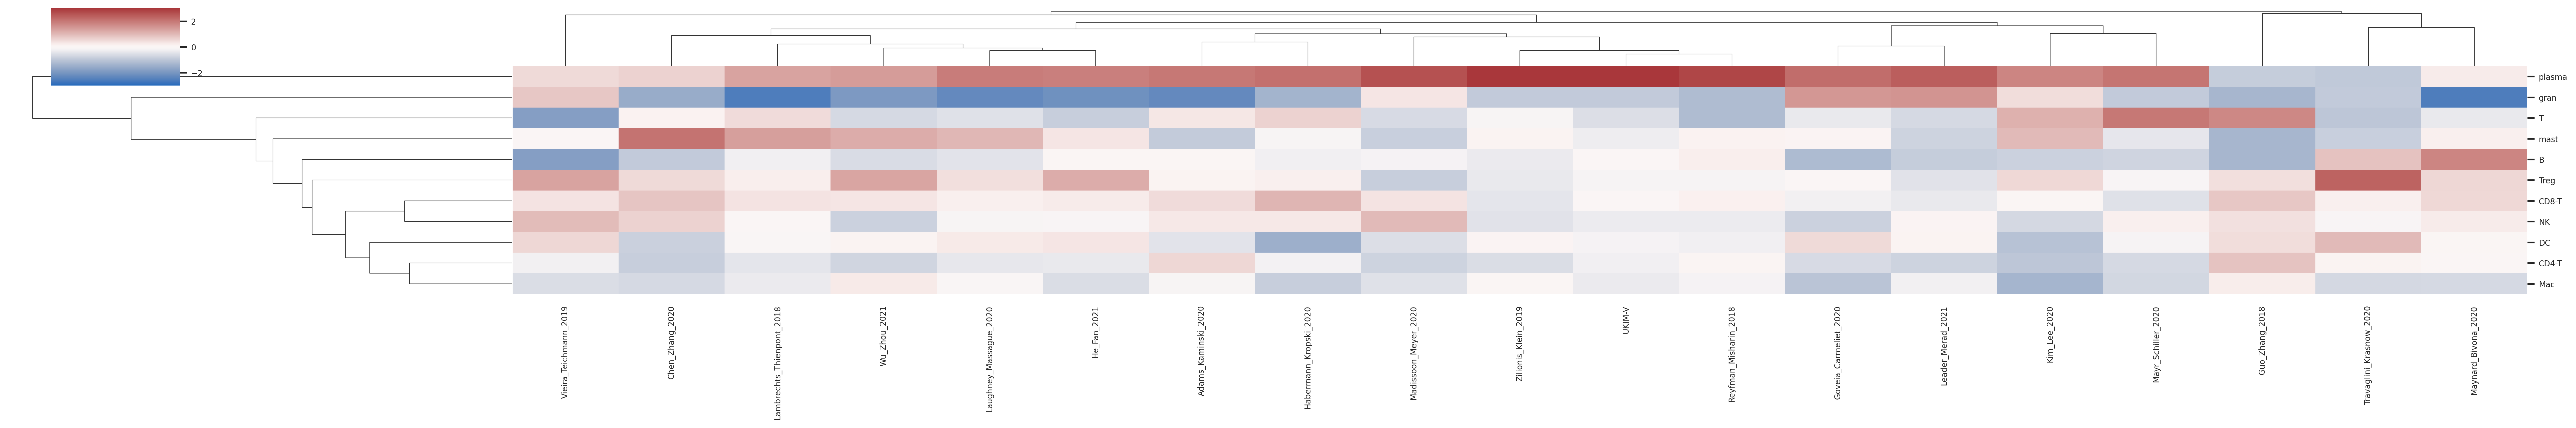

In [51]:
sns.set(font_scale=0.6)  
save_name= 'Salcher_LYS_zscore_sample_heatmap.svg'
tmp = sns.clustermap(mean_sample_celltype_df_zscored,
                    figsize=(30,5),vmax=3, center=0,vmin=-3,
                     cmap='vlag',z_score=None,col_cluster=True,
                    row_cluster=True)
plt.savefig(fig_save_path + save_name )

In [52]:
for i in mean_sample_celltype_df_zscored.columns:
    print('for',i,'highest celltype is',mean_sample_celltype_df_zscored[i].sort_values().index[-1])

for Travaglini_Krasnow_2020 highest celltype is Treg
for Kim_Lee_2020 highest celltype is plasma
for Lambrechts_Thienpont_2018 highest celltype is mast
for UKIM-V highest celltype is plasma
for Adams_Kaminski_2020 highest celltype is plasma
for Reyfman_Misharin_2018 highest celltype is plasma
for Habermann_Kropski_2020 highest celltype is plasma
for Goveia_Carmeliet_2020 highest celltype is plasma
for Wu_Zhou_2021 highest celltype is plasma
for Laughney_Massague_2020 highest celltype is plasma
for Zilionis_Klein_2019 highest celltype is plasma
for Vieira_Teichmann_2019 highest celltype is Treg
for Mayr_Schiller_2020 highest celltype is plasma
for Guo_Zhang_2018 highest celltype is T
for Maynard_Bivona_2020 highest celltype is B
for Chen_Zhang_2020 highest celltype is mast
for Madissoon_Meyer_2020 highest celltype is plasma
for He_Fan_2021 highest celltype is plasma
for Leader_Merad_2021 highest celltype is plasma


In [53]:
col_dendro_indices = tmp.dendrogram_col.reordered_ind

# Get the original column labels in clustered order
col_labels = mean_sample_celltype_df_zscored.columns[col_dendro_indices]
col_labels = list(col_labels)
#col_labels.reverse()


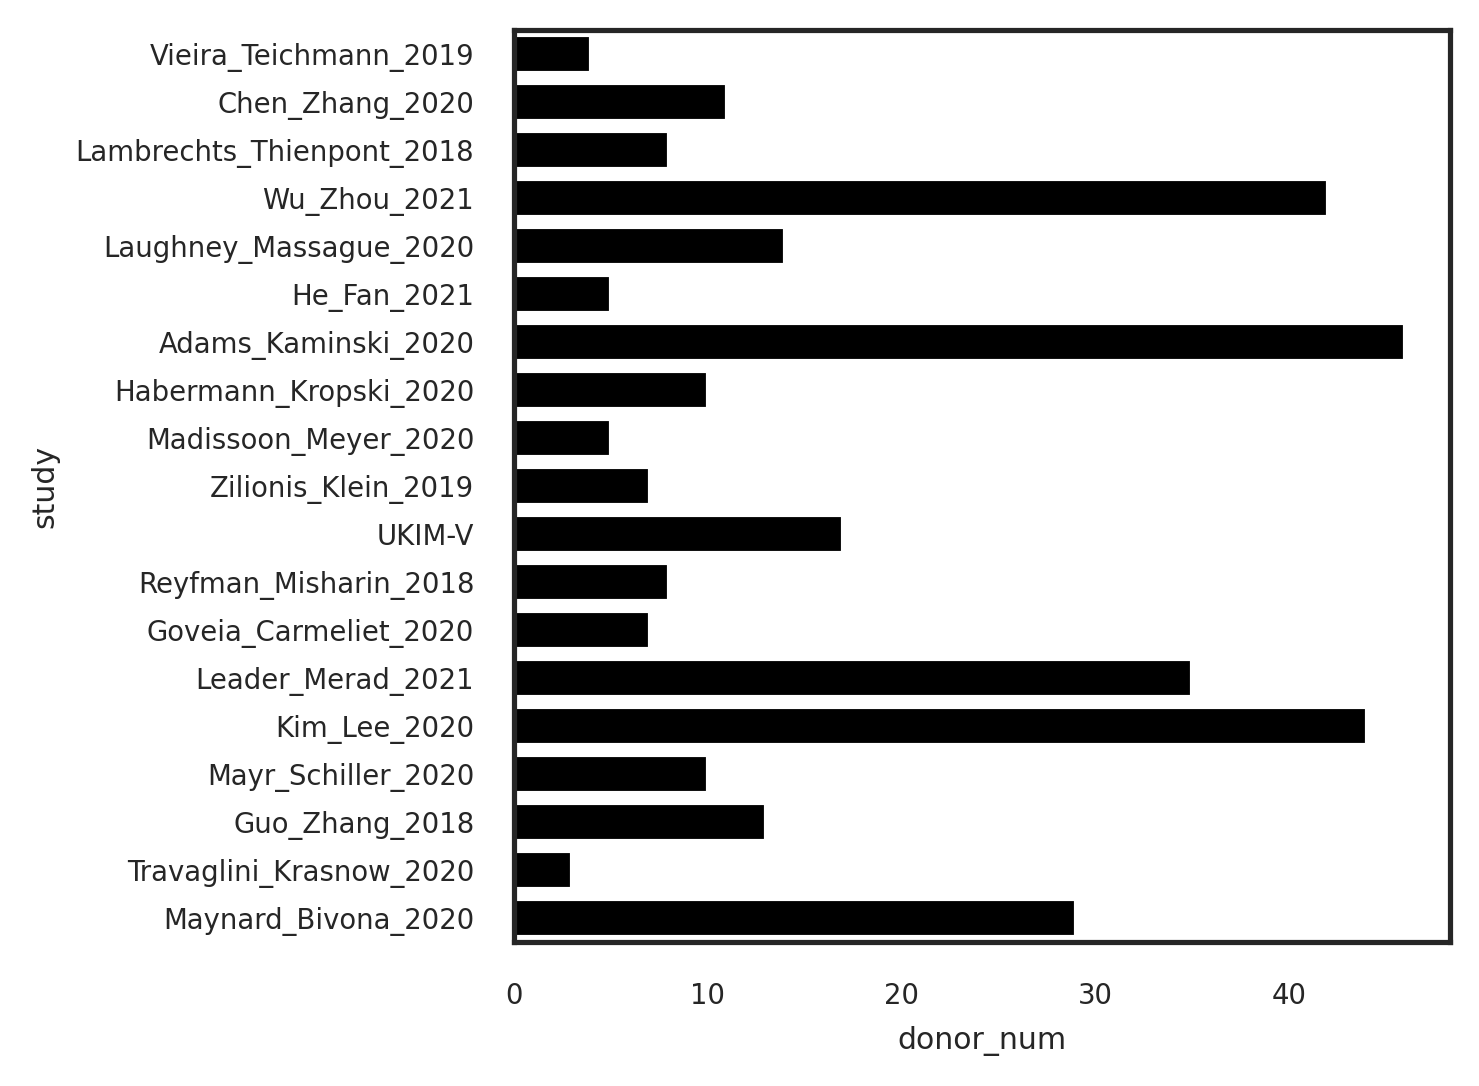

In [54]:
save_name= 'Salcher_patient_number_barplot.svg'
sns.set_style('white')
sns.barplot(data=donor_num, x='donor_num', y='study',color='#000000',order = col_labels)
plt.savefig(fig_save_path+save_name)

In [55]:
row_dendro_indices = tmp.dendrogram_row.reordered_ind

# Get the original column labels in clustered order
row_labels = mean_sample_celltype_df_zscored.index[row_dendro_indices]
row_labels = list(row_labels)
#row_labels.reverse()
row_labels

['plasma',
 'gran',
 'T',
 'mast',
 'B',
 'Treg',
 'CD8-T',
 'NK',
 'DC',
 'CD4-T',
 'Mac']

saved to: Salcher_LYS_mean_zscore_barplot.svg


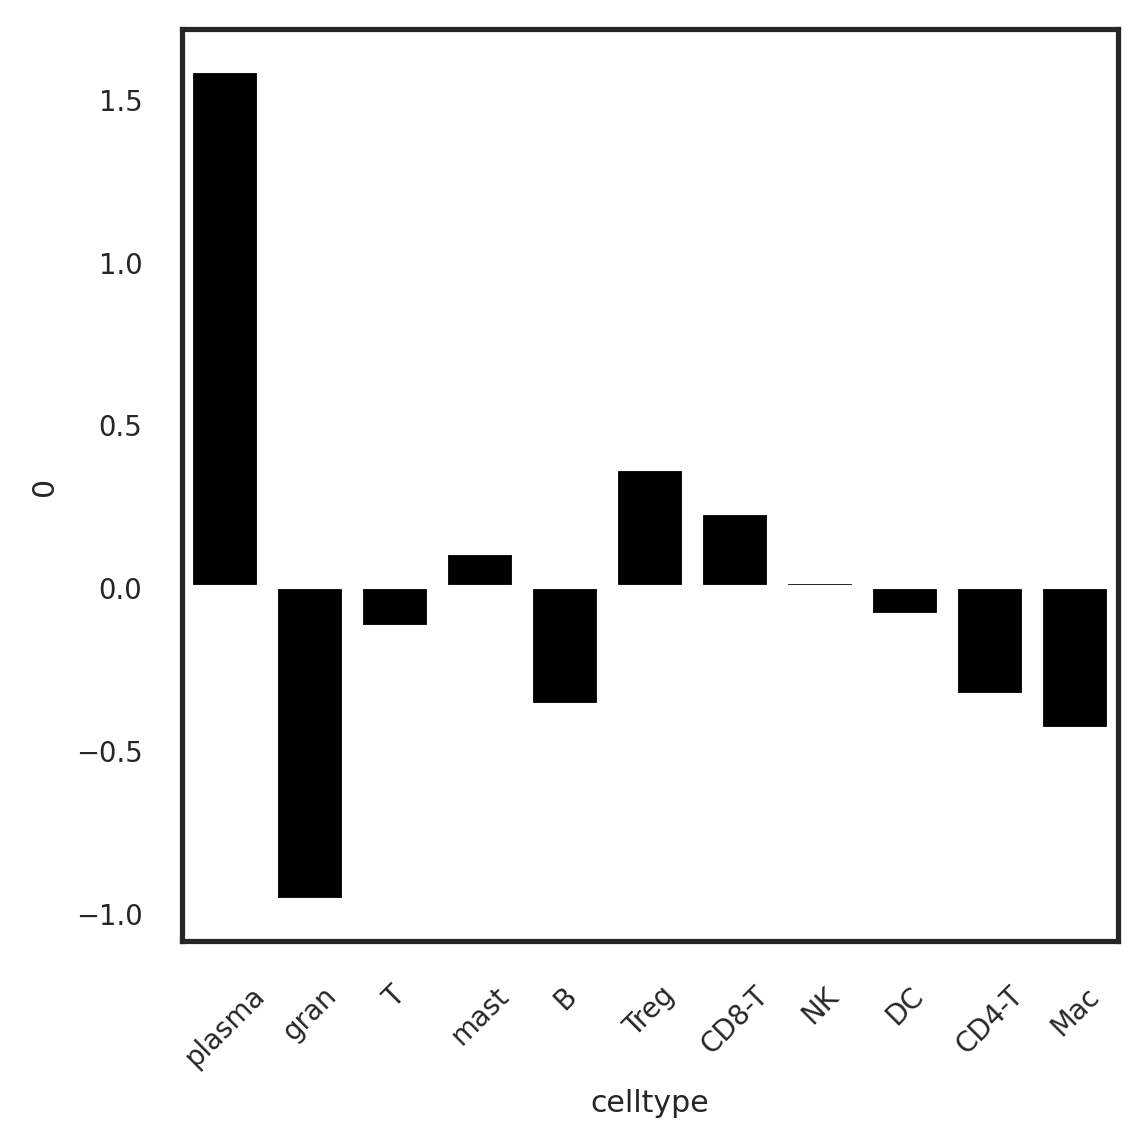

In [56]:
save_name= 'Salcher_LYS_mean_zscore_barplot.svg'
sns.set_style('white')
df_plot = pd.DataFrame(np.mean(mean_sample_celltype_df_zscored,axis=1))
df_plot['celltype']=df_plot.index
bar = sns.barplot(data=df_plot, x='celltype', y=0,color='000000',order = row_labels)
for item in bar.get_xticklabels():
    item.set_rotation(45)
plt.savefig(fig_save_path+save_name)
print('saved to:',save_name)

## recalculate embeddings

In [ ]:
print(adata.X)

In [ ]:
print(adata.raw.X)

In [ ]:
adata.X = adata.raw[adata.obs_names, adata.var_names].X
print(adata.X)

In [ ]:
#set highly var to spectra dict 

adata.var['is_highly_variable'] = adata.var['spectra_vocab']

In [ ]:
#total count normalization
sc.pp.normalize_total(adata, target_sum=None)
#logarithmize +1 the data
sc.pp.log1p(adata)

In [ ]:
print(adata.X)

In [ ]:
#select optimal number of PCs and recalculate PCs
from scrnaseq_preprocessing_utils import *

number_of_PC_used = calculate_optimal_PC(adata, min_PC = 50, min_var=25, n_comps=100, use_hv=True)

In [ ]:
if save_data:
    adata.write(save_path_recalc)

In [ ]:
#recalc umap
sc.pp.neighbors(adata, n_neighbors=10, method= 'umap', n_pcs=number_of_PC_used,random_state=0)
sc.tl.umap(adata,random_state=0)

In [ ]:
if save_data:
    adata.write(save_path_recalc)

In [22]:
adata = randomize_cells(adata)

/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


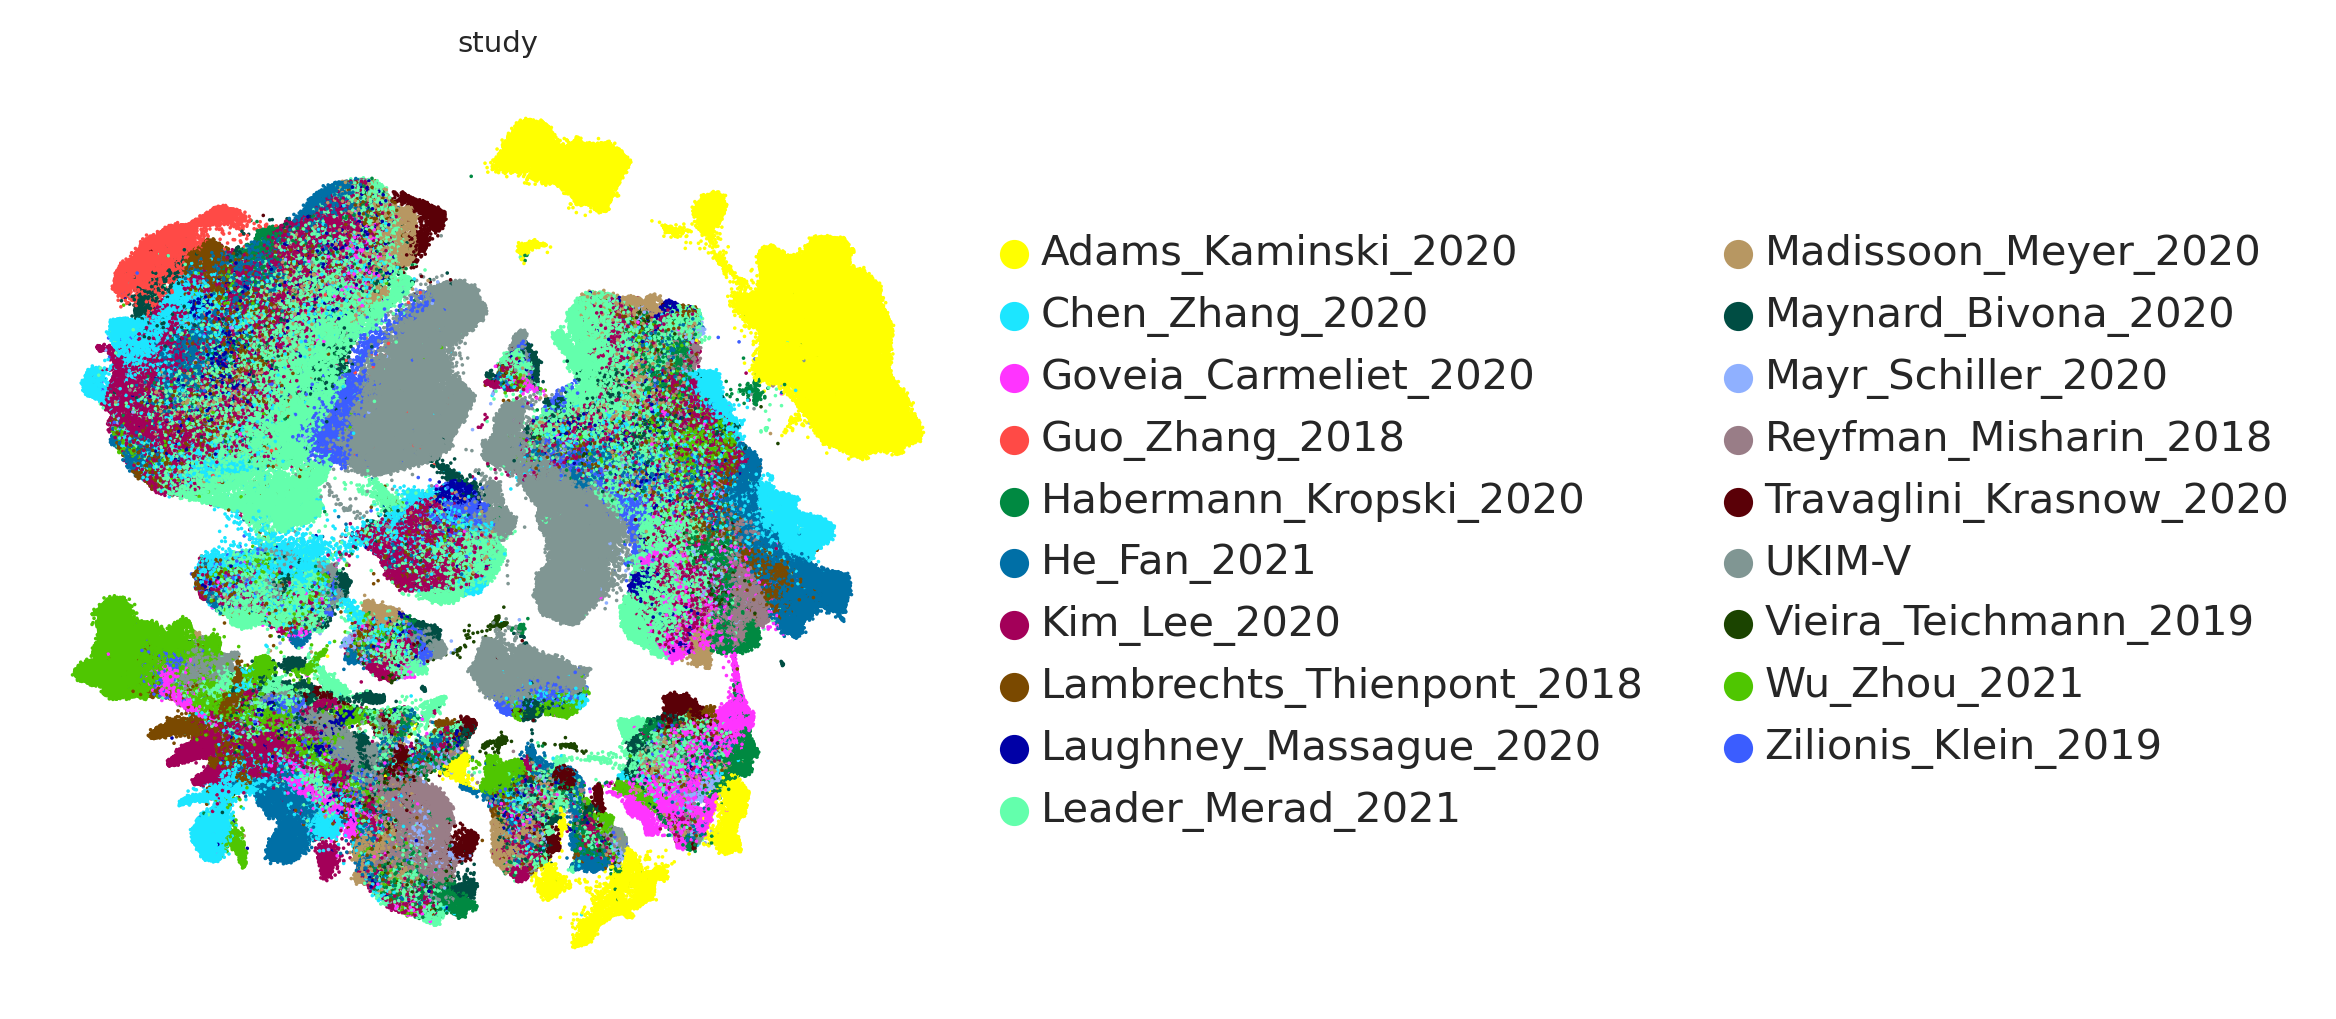

In [23]:
sc.pl.umap(adata, color = 'study', s = 3, cmap='Spectral_r',palette=color_map_clusters_nogrey, legend_fontsize = 10, vmin=0,save='Salcher-0.01_dataset.svg')

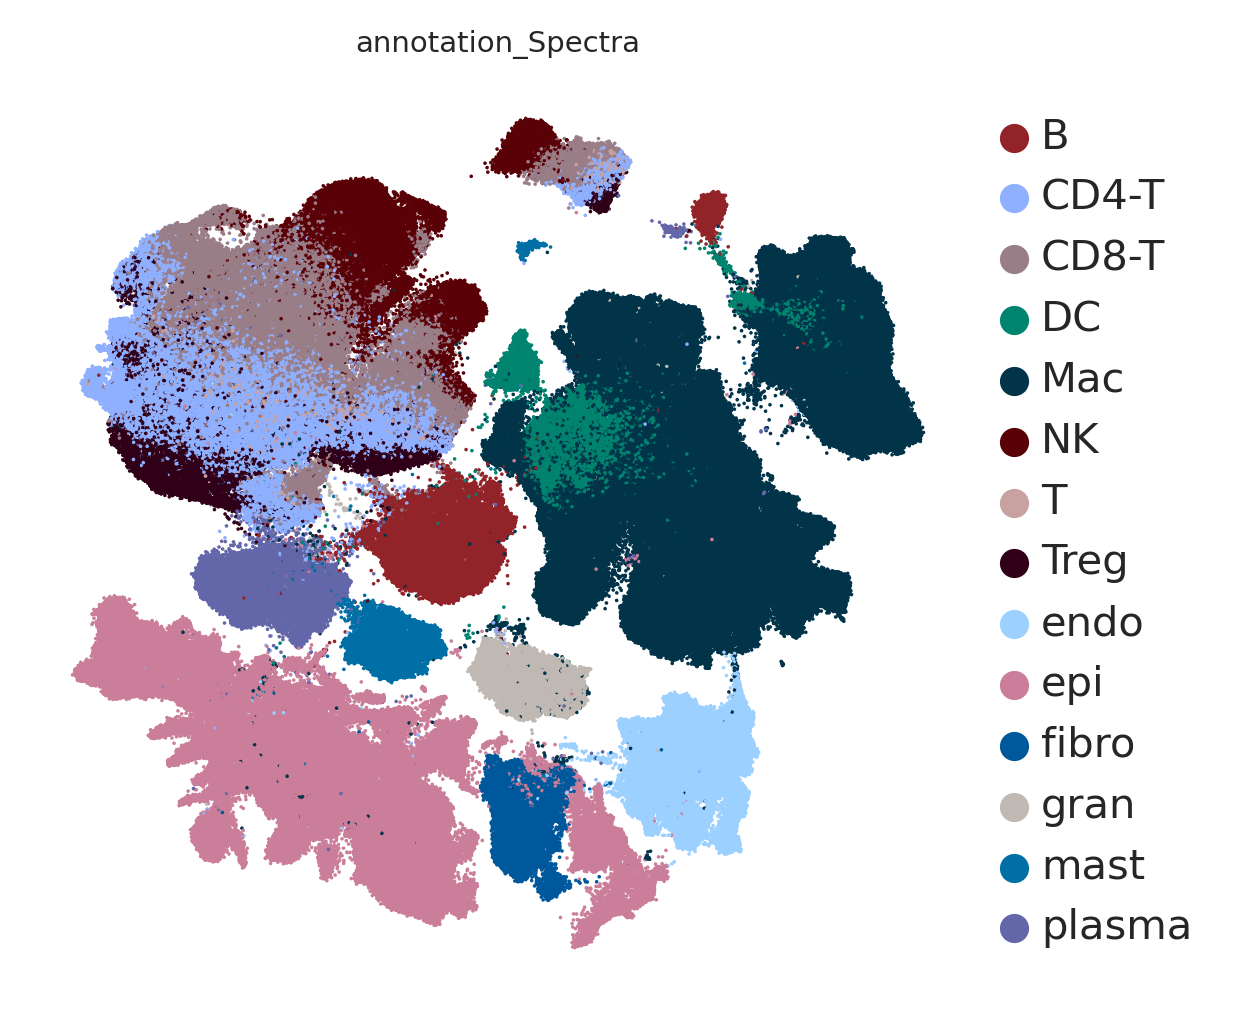

In [24]:
sc.pl.umap(adata, color = 'annotation_Spectra', s = 3, cmap='Spectral_r',palette=subtype_color_dict, legend_fontsize = 10, vmin=0,save='Salcher-0.01_annotation.svg')

In [60]:
#create unique label for each celltype in each donor
adata.obs['annotation_Spectra_donor'] = adata.obs['annotation_Spectra'].str.cat(adata.obs['donor_id'],sep='-XX-')
adata.obs['annotation_Spectra_dataset'] = adata.obs['annotation_Spectra'].str.cat(adata.obs['dataset'],sep='-XX-')

In [61]:
#aggregate lYS factor scores per annotation_Spectra_donor
sample_aggregate = aggregate_scores(adata,['56-X-global-X-all_LYS_metabolism'],'annotation_Spectra_donor',
                            zero_cutoff =0,aggregate_function='mean')

In [63]:
mapping_dict_sample = dict(zip(list(adata.obs['annotation_Spectra_donor']),list(adata.obs['annotation_Spectra'])))
mapping_dict_study = dict(zip(list(adata.obs['annotation_Spectra_donor']),list(adata.obs['dataset'])))

In [64]:
#annotate celltype
sample_aggregate_mean = sample_aggregate[0]
sample_aggregate_mean['celltype'] = sample_aggregate_mean.index.map(mapping_dict_sample)
sample_aggregate_mean['study'] = sample_aggregate_mean.index.map(mapping_dict_study)
sample_aggregate_mean = sample_aggregate_mean.fillna(0)
sample_aggregate_mean

56-X-global-X-all_LYS_metabolism  \
plasma-XX-Reyfman_Misharin_2018_Donor_07                      2.961773e-04   
Treg-XX-Wu_Zhou_2021_P5                                       5.434000e-05   
DC-XX-Maynard_Bivona_2020_TH158                               1.982951e-09   
Mac-XX-Reyfman_Misharin_2018_Donor_06                         8.392744e-05   
plasma-XX-Adams_Kaminski_2020_137C                            8.800476e-05   
...                                                                    ...   
DC-XX-Wu_Zhou_2021_P35                                        5.129552e-05   
mast-XX-Kim_Lee_2020_P0006                                    2.457312e-04   
plasma-XX-Leader_Merad_2021_725                               4.587027e-04   
CD8-T-XX-He_Fan_2021_P1                                       1.634940e-04   
Treg-XX-Adams_Kaminski_2020_483C                              5.494145e-09   

                                         celltype  \
plasma-XX-Reyfman_Misharin_2018_Donor_07   plasma   
Treg-XX-Wu_Zhou_2021_P5                      Treg   
DC-XX-Maynard_Bivona_2020_TH158                DC   
Mac-XX-Reyfman_Misharin_2018_Donor_06         Mac   
plasma-XX-Adams_Kaminski_2020_137C         plasma   
...                                           ...   
DC-XX-Wu_Zhou_2021_P35                         DC   
mast-XX-Kim_Lee_2020_P0006                   mast   
plasma-XX-Leader_Merad_2021_725            plasma   
CD8-T-XX-He_Fan_2021_P1                     CD8-T   
Treg-XX-Adams_Kaminski_2020_483C             Treg   

                                                                      study  
plasma-XX-Reyfman_Misharin_2018_Donor_07              Reyfman_Misharin_2018  
Treg-XX-Wu_Zhou_2021_P5                                        Wu_Zhou_2021  
DC-XX-Maynard_Bivona_2020_TH158                         Maynard_Bivona_2020  
Mac-XX-Reyfman_Misharin_2018_Donor_06                 Reyfman_Misharin_2018  
plasma-XX-Adams_Kaminski_2020_137C                      Adams_Kaminski_2020  
...                                                                     ...  
DC-XX-Wu_Zhou_2021_P35                                         Wu_Zhou_2021  
mast-XX-Kim_Lee_2020_P0006                                     Kim_Lee_2020  
plasma-XX-Leader_Merad_2021_725           Leader_Merad_2021_10x_3p_v3_beads  
CD8-T-XX-He_Fan_2021_P1                                         He_Fan_2021  
Treg-XX-Adams_Kaminski_2020_483C                        Adams_Kaminski_2020  

[3706 rows x 3 columns]

In [65]:
#add patient identity
sample_aggregate_mean['patient'] = [x[1] for x in sample_aggregate_mean.index.str.split('-XX-')]
sample_aggregate_mean

56-X-global-X-all_LYS_metabolism  \
plasma-XX-Reyfman_Misharin_2018_Donor_07                      2.961773e-04   
Treg-XX-Wu_Zhou_2021_P5                                       5.434000e-05   
DC-XX-Maynard_Bivona_2020_TH158                               1.982951e-09   
Mac-XX-Reyfman_Misharin_2018_Donor_06                         8.392744e-05   
plasma-XX-Adams_Kaminski_2020_137C                            8.800476e-05   
...                                                                    ...   
DC-XX-Wu_Zhou_2021_P35                                        5.129552e-05   
mast-XX-Kim_Lee_2020_P0006                                    2.457312e-04   
plasma-XX-Leader_Merad_2021_725                               4.587027e-04   
CD8-T-XX-He_Fan_2021_P1                                       1.634940e-04   
Treg-XX-Adams_Kaminski_2020_483C                              5.494145e-09   

                                         celltype  \
plasma-XX-Reyfman_Misharin_2018_Donor_07   plasma   
Treg-XX-Wu_Zhou_2021_P5                      Treg   
DC-XX-Maynard_Bivona_2020_TH158                DC   
Mac-XX-Reyfman_Misharin_2018_Donor_06         Mac   
plasma-XX-Adams_Kaminski_2020_137C         plasma   
...                                           ...   
DC-XX-Wu_Zhou_2021_P35                         DC   
mast-XX-Kim_Lee_2020_P0006                   mast   
plasma-XX-Leader_Merad_2021_725            plasma   
CD8-T-XX-He_Fan_2021_P1                     CD8-T   
Treg-XX-Adams_Kaminski_2020_483C             Treg   

                                                                      study  \
plasma-XX-Reyfman_Misharin_2018_Donor_07              Reyfman_Misharin_2018   
Treg-XX-Wu_Zhou_2021_P5                                        Wu_Zhou_2021   
DC-XX-Maynard_Bivona_2020_TH158                         Maynard_Bivona_2020   
Mac-XX-Reyfman_Misharin_2018_Donor_06                 Reyfman_Misharin_2018   
plasma-XX-Adams_Kaminski_2020_137C                      Adams_Kaminski_2020   
...                                                                     ...   
DC-XX-Wu_Zhou_2021_P35                                         Wu_Zhou_2021   
mast-XX-Kim_Lee_2020_P0006                                     Kim_Lee_2020   
plasma-XX-Leader_Merad_2021_725           Leader_Merad_2021_10x_3p_v3_beads   
CD8-T-XX-He_Fan_2021_P1                                         He_Fan_2021   
Treg-XX-Adams_Kaminski_2020_483C                        Adams_Kaminski_2020   

                                                                 patient  
plasma-XX-Reyfman_Misharin_2018_Donor_07  Reyfman_Misharin_2018_Donor_07  
Treg-XX-Wu_Zhou_2021_P5                                  Wu_Zhou_2021_P5  
DC-XX-Maynard_Bivona_2020_TH158                Maynard_Bivona_2020_TH158  
Mac-XX-Reyfman_Misharin_2018_Donor_06     Reyfman_Misharin_2018_Donor_06  
plasma-XX-Adams_Kaminski_2020_137C              Adams_Kaminski_2020_137C  
...                                                                  ...  
DC-XX-Wu_Zhou_2021_P35                                  Wu_Zhou_2021_P35  
mast-XX-Kim_Lee_2020_P0006                            Kim_Lee_2020_P0006  
plasma-XX-Leader_Merad_2021_725                    Leader_Merad_2021_725  
CD8-T-XX-He_Fan_2021_P1                                   He_Fan_2021_P1  
Treg-XX-Adams_Kaminski_2020_483C                Adams_Kaminski_2020_483C  

[3706 rows x 4 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


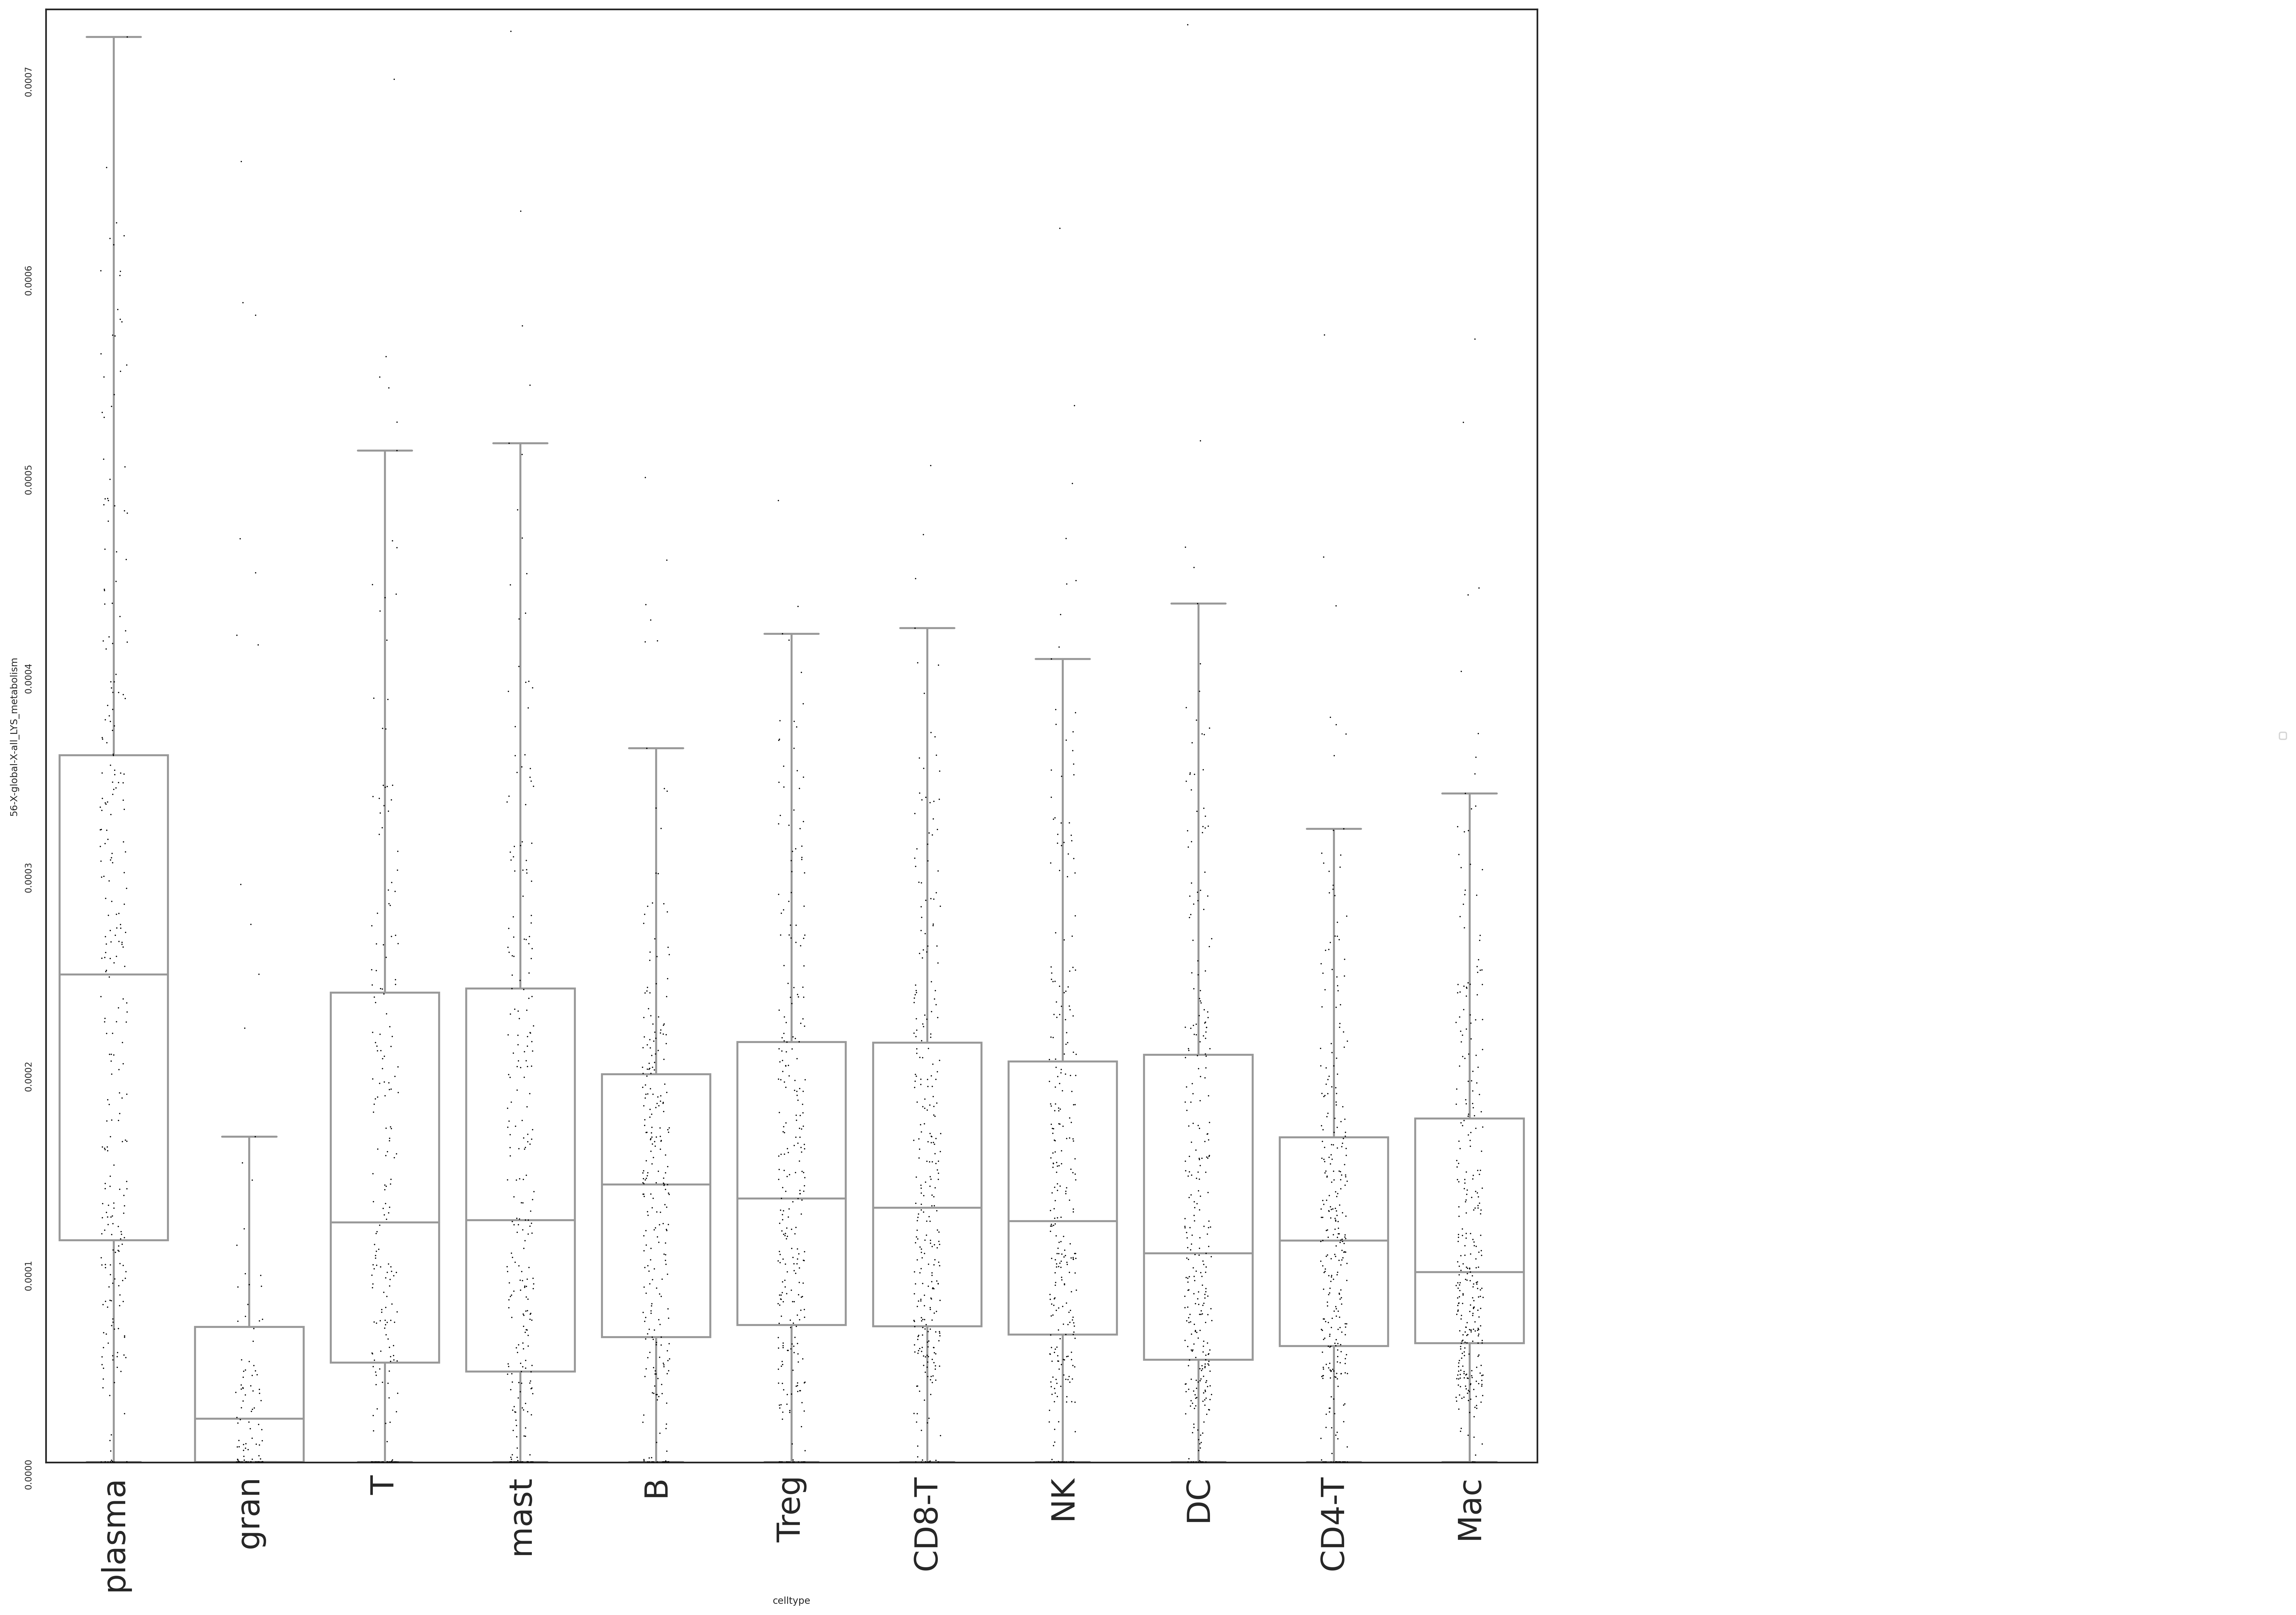

In [66]:
save_name = 'Salcher_sample-celltype_meanpos0.001_LYSfactor_56_nostudy.svg'
sns.set_style('white')
fig,ax = plt.subplots(figsize=(20, 20))
ax.tick_params(labelrotation=90)
ax.set_ylim(-0.0000002,0.00073)
order_list = row_labels
sns.boxplot(x="celltype", y="56-X-global-X-all_LYS_metabolism", #hue='study',
            data=sample_aggregate_mean,fliersize=0,color='#FFFFFF',
            order=order_list,
           #palette={'Primary':'#0E518F', 'Metastasis':'#DF480F', 'Non-Tumor':'#FFFFFF'}
           )
sns.stripplot(x="celltype", y="56-X-global-X-all_LYS_metabolism", #hue='study',
              data=sample_aggregate_mean,
              order=order_list,color='#000000',dodge=True,s=1)
#plt.axhline(y=1,color='#000000', linestyle='--')
ax.tick_params(axis='x', which='major', labelsize=24)
plt.legend( bbox_to_anchor=[1.5, 0.5], loc='center')    
plt.xlim
plt.savefig(fig_save_path+save_name)

In [77]:
for i in set(set(sample_aggregate_mean['celltype']) - {'plasma'}):
    sample_aggregate_mean_B = sample_aggregate_mean[sample_aggregate_mean['celltype'].isin([i,'plasma'])]
    print('testing',i)
    df_plasma = sample_aggregate_mean_B[sample_aggregate_mean_B['celltype']==i]['56-X-global-X-all_LYS_metabolism']
    plasma_mean =np.mean(df_plasma)
    df_i = sample_aggregate_mean_B[sample_aggregate_mean_B['celltype']=='plasma']['56-X-global-X-all_LYS_metabolism']
    i_mean = np.mean(df_i)
    std = np.std(sample_aggregate_mean_B['56-X-global-X-all_LYS_metabolism'])
    Cohensd = abs((plasma_mean-i_mean)/std)
    a = compare_factors(sample_aggregate_mean_B, '56-X-global-X-all_LYS_metabolism', 'patient', 'celltype', [i,'plasma'],test='wilcoxon',
                         zero_method='wilcox', correction=False, 
                          alternative='two-sided',  axis=0, 
                          nan_policy='propagate')
    print(a)
    print('Cohens d:',Cohensd)

testing Mac
pre and on patients identical True
WilcoxonResult(statistic=2350.0, pvalue=5.492444565927633e-35)
Cohens d: 0.8648190011583295
testing CD8-T
pre and on patients identical True
WilcoxonResult(statistic=4555.0, pvalue=1.879195152954768e-23)
Cohens d: 0.7034827439630933
testing mast
pre and on patients identical True
WilcoxonResult(statistic=5348.0, pvalue=1.5699056513860983e-17)
Cohens d: 0.5208690882207099
testing NK
pre and on patients identical True
WilcoxonResult(statistic=3883.0, pvalue=6.090664186351097e-25)
Cohens d: 0.7009919981163462
testing Treg
pre and on patients identical True
WilcoxonResult(statistic=4441.0, pvalue=2.3660569958752293e-22)
Cohens d: 0.6077017037507568
testing T
pre and on patients identical True
WilcoxonResult(statistic=3345.0, pvalue=1.2872996110073157e-15)
Cohens d: 0.5600709272643118
testing epi
pre and on patients identical True
WilcoxonResult(statistic=3214.0, pvalue=2.221234681809959e-30)
Cohens d: 0.7335754208440377
testing endo
pre and on

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


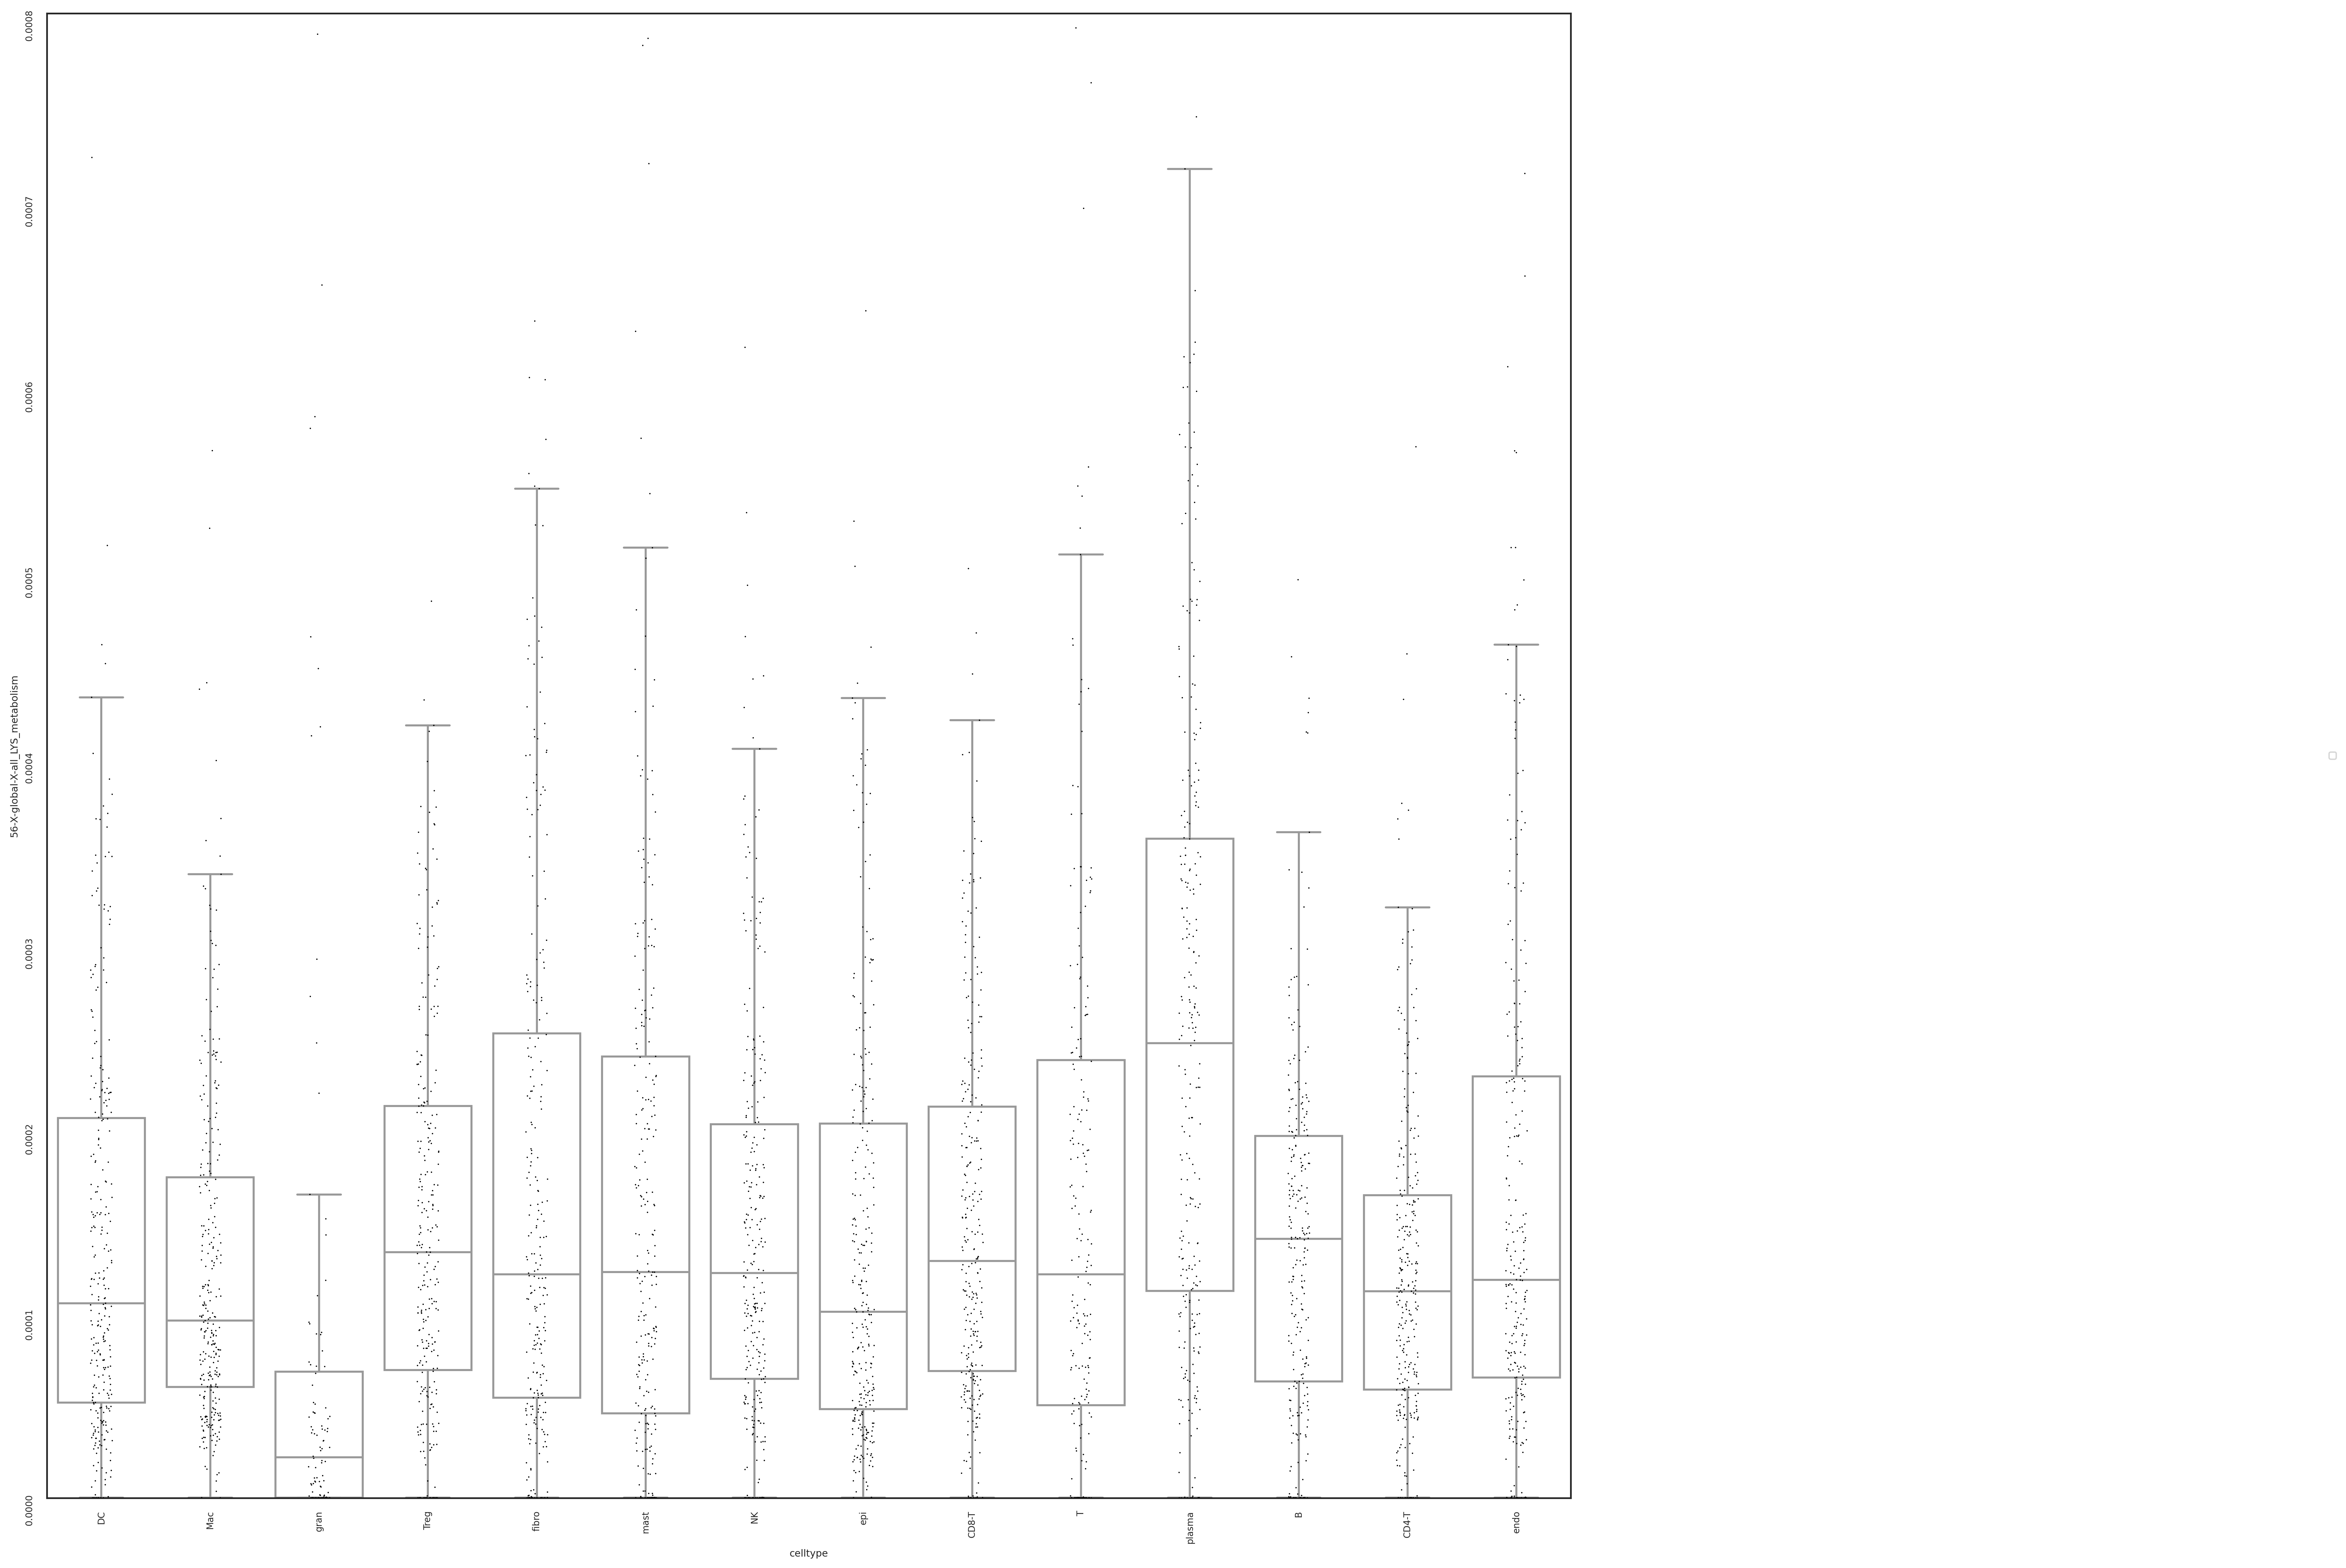

In [75]:
save_name = 'Salcher_sample-celltype_meanpos0.001_LYSfactor_56_nostudy.svg'
sns.set_style('white')
fig,ax = plt.subplots(figsize=(20, 20))
ax.tick_params(labelrotation=90)
ax.set_ylim(0,0.0008)
order_list = list(set(adata.obs['annotation_Spectra']))
sns.boxplot(x="celltype", y="56-X-global-X-all_LYS_metabolism", #hue='study',
            data=sample_aggregate_mean,fliersize=0,color='#FFFFFF',
            order=order_list,
           #palette={'Primary':'#0E518F', 'Metastasis':'#DF480F', 'Non-Tumor':'#FFFFFF'}
           )
sns.stripplot(x="celltype", y="56-X-global-X-all_LYS_metabolism", #hue='study',
              data=sample_aggregate_mean,
              order=order_list,color='#000000',dodge=True,s=1)
#plt.axhline(y=1,color='#000000', linestyle='--')
plt.legend( bbox_to_anchor=[1.5, 0.5], loc='center')    
plt.savefig(fig_save_path+save_name)

# tumor reactivity

In [16]:
input_genes = set(input_df[input_df['gs.name']=='CD8-T_tumor-reactive-like_UP']['g.name'])

#lambda 0.01
Bassez_et_al = set(['MKI67', 'TNFRSF18', 'ENTPD1', 'ITGAE', 'CXCL13', 'TNFRSF9',
       'IFNG', 'GZMB', 'CCL3', 'GNLY', 'FASLG', 'CCR1', 'PRF1', 'GZMH',
       'HAVCR2', 'SLA', 'BATF', 'SH2D2A', 'LCP2', 'GBP1', 'ITM2A', 'GZMA',
       'RHOH', 'ZBTB32', 'DOK2', 'BTN3A2', 'LAX1', 'IL10RB', 'CIC',
       'TESPA1', 'SEMA7A', 'LTA', 'GFI1', 'CD8B', 'TNFRSF4', 'GADD45G',
       'FBXW7', 'STAT5A', 'NFATC1', 'KRT86', 'CD38', 'NR4A3', 'GZMM',
       'GALNT2', 'LCK', 'MTHFD2', 'RBPJ', 'LAG3', 'LAYN', 'LINC02195'])

Salcher_et_al = set(list(set(adata.uns['SPECTRA_markers'][174][:50])))

saved Figure to: /data/peer/wallet/Jupyter/SPADE_Peer_validation/figures/Venn_Salcher_0.1_Zhang_Bassez_nooffsettumorreac.svg


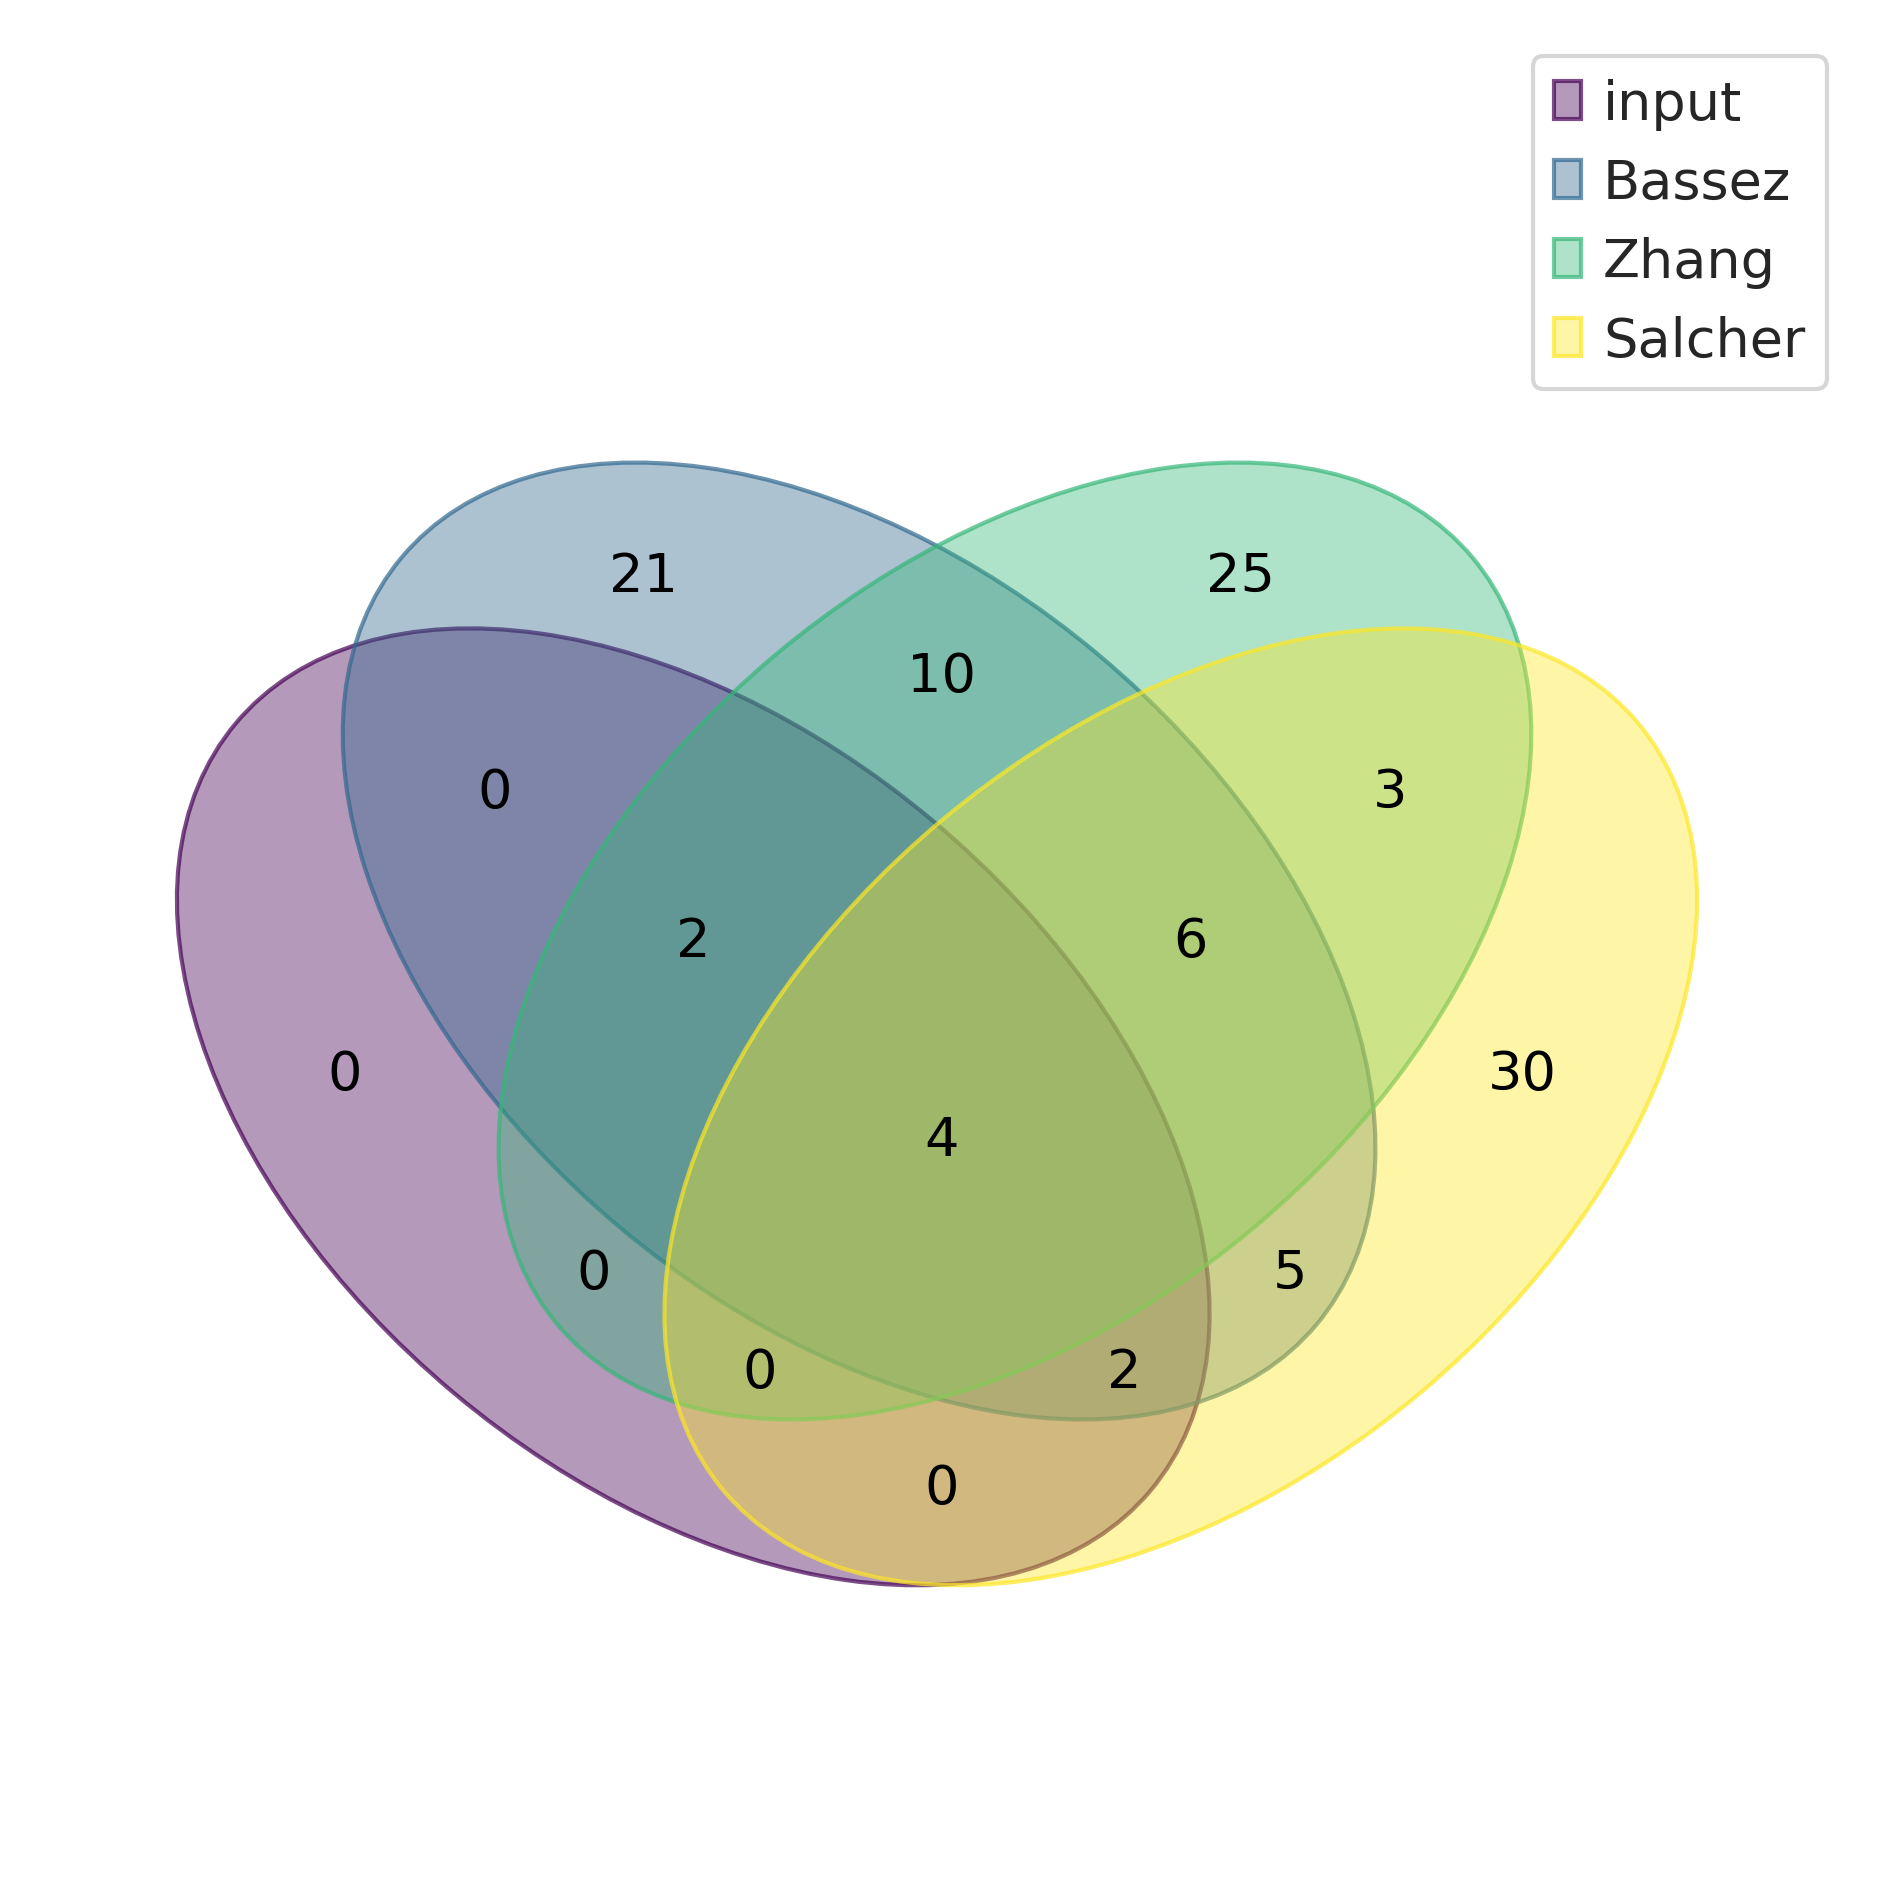

In [16]:
import venn
venn.venn({'input':input_genes, 'Bassez':Bassez_et_al, 'Zhang':Zhang_et_al, 'Salcher':Salcher_et_al,
          #'Salcher':Salcher_et_al
          })
save_fig_path = fig_save_path+'Venn_Salcher_0.1_Zhang_Bassez_nooffset'+'tumorreac'+'.svg'
plt.savefig(save_fig_path,dpi=300)
print('saved Figure to:',save_fig_path)

In [18]:
 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation'

('EGFR_mutation',
 'TP53_mutation',
 'ALK_mutation',
 'BRAF_mutation',
 'ERBB2_mutation',
 'KRAS_mutation',
 'ROS_mutation')

In [19]:
adata_CD8 = adata[adata.obs['annotation_Spectra']=='CD8-T']
adata_CD8

View of AnnData object with n_obs × n_vars = 151634 × 17688
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'annotation', 'annotation_Spectra', '0-X-global-X-

In [87]:
#aggregate per patient
mean_df = aggregate_scores(adata_CD8,['174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP'],'donor_id',
                            zero_cutoff =0.001,aggregate_function='mean')[0]

In [88]:
mean_df = mean_df.fillna(0)
mean_df

174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP
Kim_Lee_2020_P0031                                                  0.005179
Wu_Zhou_2021_P11                                                    0.007928
Maynard_Bivona_2020_TH153                                           0.002938
Laughney_Massague_2020_LX653                                        0.002589
Zilionis_Klein_2019_patient_2                                       0.002942
...                                                                      ...
Leader_Merad_2021_630                                               0.002422
Adams_Kaminski_2020_8CO                                             0.002051
Leader_Merad_2021_410                                               0.003713
Goveia_Carmeliet_2020_patient_46                                    0.003124
Chen_Zhang_2020_NSCLC-7                                             0.003351

[290 rows x 1 columns]

In [90]:
mapping_dict = dict(zip(list(adata.obs['donor_id']),list(adata.obs['ever_smoker'])))
mapping_dict_EGFR = dict(zip(list(adata.obs['donor_id']),list(adata.obs['EGFR_mutation'])))
mapping_dict_ERBB2 = dict(zip(list(adata.obs['donor_id']),list(adata.obs['ERBB2_mutation'])))
mapping_dict_ROS = dict(zip(list(adata.obs['donor_id']),list(adata.obs['ROS_mutation'])))
mapping_dict_BRAF = dict(zip(list(adata.obs['donor_id']),list(adata.obs['BRAF_mutation'])))
mapping_dict_ALK = dict(zip(list(adata.obs['donor_id']),list(adata.obs['ALK_mutation'])))
mapping_dict_age = dict(zip(list(adata.obs['donor_id']),list(adata.obs['age'])))
mapping_dict_sex = dict(zip(list(adata.obs['donor_id']),list(adata.obs['sex'])))
mapping_dict_stage = dict(zip(list(adata.obs['donor_id']),list(adata.obs['uicc_stage'])))

In [91]:
mean_df['smoke'] = mean_df.index.map(mapping_dict)
mean_df['EGFR_mutation'] = mean_df.index.map(mapping_dict_EGFR)
mean_df['ERBB2_mutation'] = mean_df.index.map(mapping_dict_ERBB2)
mean_df['ROS_mutation'] = mean_df.index.map(mapping_dict_ROS)
mean_df['BRAF_mutation'] = mean_df.index.map(mapping_dict_BRAF)
mean_df['ALK_mutation'] = mean_df.index.map(mapping_dict_ALK)
mean_df['age'] = mean_df.index.map(mapping_dict_age)
mean_df['sex'] = mean_df.index.map(mapping_dict_sex)
mean_df['stage'] = mean_df.index.map(mapping_dict_stage)

#mean_df['sex'] = mean_df.index.map(mapping_dict_sex)

#mean_df = mean_df[mean_df['smoke'].isin(['I', 'II', 'III', 'III or IV', 'IV'])]
mean_df

174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP  \
Kim_Lee_2020_P0031                                                  0.005179   
Wu_Zhou_2021_P11                                                    0.007928   
Maynard_Bivona_2020_TH153                                           0.002938   
Laughney_Massague_2020_LX653                                        0.002589   
Zilionis_Klein_2019_patient_2                                       0.002942   
...                                                                      ...   
Leader_Merad_2021_630                                               0.002422   
Adams_Kaminski_2020_8CO                                             0.002051   
Leader_Merad_2021_410                                               0.003713   
Goveia_Carmeliet_2020_patient_46                                    0.003124   
Chen_Zhang_2020_NSCLC-7                                             0.003351   

                                 smoke EGFR_mutation ERBB2_mutation  \
Kim_Lee_2020_P0031                 yes           NaN            NaN   
Wu_Zhou_2021_P11                   NaN           NaN            NaN   
Maynard_Bivona_2020_TH153           no       mutated    not mutated   
Laughney_Massague_2020_LX653        no       mutated    not mutated   
Zilionis_Klein_2019_patient_2      NaN           NaN            NaN   
...                                ...           ...            ...   
Leader_Merad_2021_630              yes           NaN            NaN   
Adams_Kaminski_2020_8CO            yes           NaN            NaN   
Leader_Merad_2021_410              yes           NaN            NaN   
Goveia_Carmeliet_2020_patient_46    no           NaN            NaN   
Chen_Zhang_2020_NSCLC-7            NaN           NaN            NaN   

                                 ROS_mutation BRAF_mutation ALK_mutation  \
Kim_Lee_2020_P0031                        NaN           NaN          NaN   
Wu_Zhou_2021_P11                          NaN           NaN          NaN   
Maynard_Bivona_2020_TH153         not mutated   not mutated  not mutated   
Laughney_Massague_2020_LX653      not mutated   not mutated  not mutated   
Zilionis_Klein_2019_patient_2             NaN           NaN          NaN   
...                                       ...           ...          ...   
Leader_Merad_2021_630                     NaN           NaN          NaN   
Adams_Kaminski_2020_8CO                   NaN           NaN          NaN   
Leader_Merad_2021_410                     NaN           NaN          NaN   
Goveia_Carmeliet_2020_patient_46          NaN           NaN          NaN   
Chen_Zhang_2020_NSCLC-7                   NaN           NaN          NaN   

                                   age      sex       stage  
Kim_Lee_2020_P0031                 NaN     male         III  
Wu_Zhou_2021_P11                  58.0   female   III or IV  
Maynard_Bivona_2020_TH153         63.0   female          IV  
Laughney_Massague_2020_LX653       NaN  unknown           I  
Zilionis_Klein_2019_patient_2     74.0   female         III  
...                                ...      ...         ...  
Leader_Merad_2021_630             66.0     male           I  
Adams_Kaminski_2020_8CO           65.0     male  non-cancer  
Leader_Merad_2021_410             76.0   female           I  
Goveia_Carmeliet_2020_patient_46  71.0   female           I  
Chen_Zhang_2020_NSCLC-7            NaN   female           I  

[290 rows x 10 columns]

In [93]:
#remove other mutations
mean_df = mean_df[mean_df['stage']!='non-cancer']
mean_df = mean_df[mean_df['ERBB2_mutation']!='mutated']
mean_df = mean_df[mean_df['ROS_mutation']!='mutated']
mean_df = mean_df[mean_df['ALK_mutation']!='mutated']
mean_df = mean_df[mean_df['BRAF_mutation']!='mutated']
mean_df

174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP  \
Kim_Lee_2020_P0031                                                  0.005179   
Wu_Zhou_2021_P11                                                    0.007928   
Maynard_Bivona_2020_TH153                                           0.002938   
Laughney_Massague_2020_LX653                                        0.002589   
Zilionis_Klein_2019_patient_2                                       0.002942   
...                                                                      ...   
Wu_Zhou_2021_P21                                                    0.007919   
Leader_Merad_2021_630                                               0.002422   
Leader_Merad_2021_410                                               0.003713   
Goveia_Carmeliet_2020_patient_46                                    0.003124   
Chen_Zhang_2020_NSCLC-7                                             0.003351   

                                 smoke EGFR_mutation ERBB2_mutation  \
Kim_Lee_2020_P0031                 yes           NaN            NaN   
Wu_Zhou_2021_P11                   NaN           NaN            NaN   
Maynard_Bivona_2020_TH153           no       mutated    not mutated   
Laughney_Massague_2020_LX653        no       mutated    not mutated   
Zilionis_Klein_2019_patient_2      NaN           NaN            NaN   
...                                ...           ...            ...   
Wu_Zhou_2021_P21                   NaN           NaN            NaN   
Leader_Merad_2021_630              yes           NaN            NaN   
Leader_Merad_2021_410              yes           NaN            NaN   
Goveia_Carmeliet_2020_patient_46    no           NaN            NaN   
Chen_Zhang_2020_NSCLC-7            NaN           NaN            NaN   

                                 ROS_mutation BRAF_mutation ALK_mutation  \
Kim_Lee_2020_P0031                        NaN           NaN          NaN   
Wu_Zhou_2021_P11                          NaN           NaN          NaN   
Maynard_Bivona_2020_TH153         not mutated   not mutated  not mutated   
Laughney_Massague_2020_LX653      not mutated   not mutated  not mutated   
Zilionis_Klein_2019_patient_2             NaN           NaN          NaN   
...                                       ...           ...          ...   
Wu_Zhou_2021_P21                          NaN           NaN          NaN   
Leader_Merad_2021_630                     NaN           NaN          NaN   
Leader_Merad_2021_410                     NaN           NaN          NaN   
Goveia_Carmeliet_2020_patient_46          NaN           NaN          NaN   
Chen_Zhang_2020_NSCLC-7                   NaN           NaN          NaN   

                                   age      sex      stage  
Kim_Lee_2020_P0031                 NaN     male        III  
Wu_Zhou_2021_P11                  58.0   female  III or IV  
Maynard_Bivona_2020_TH153         63.0   female         IV  
Laughney_Massague_2020_LX653       NaN  unknown          I  
Zilionis_Klein_2019_patient_2     74.0   female        III  
...                                ...      ...        ...  
Wu_Zhou_2021_P21                  65.0     male  III or IV  
Leader_Merad_2021_630             66.0     male          I  
Leader_Merad_2021_410             76.0   female          I  
Goveia_Carmeliet_2020_patient_46  71.0   female          I  
Chen_Zhang_2020_NSCLC-7            NaN   female          I  

[202 rows x 10 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Salcher_patient_CD8_smoker174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP.svg


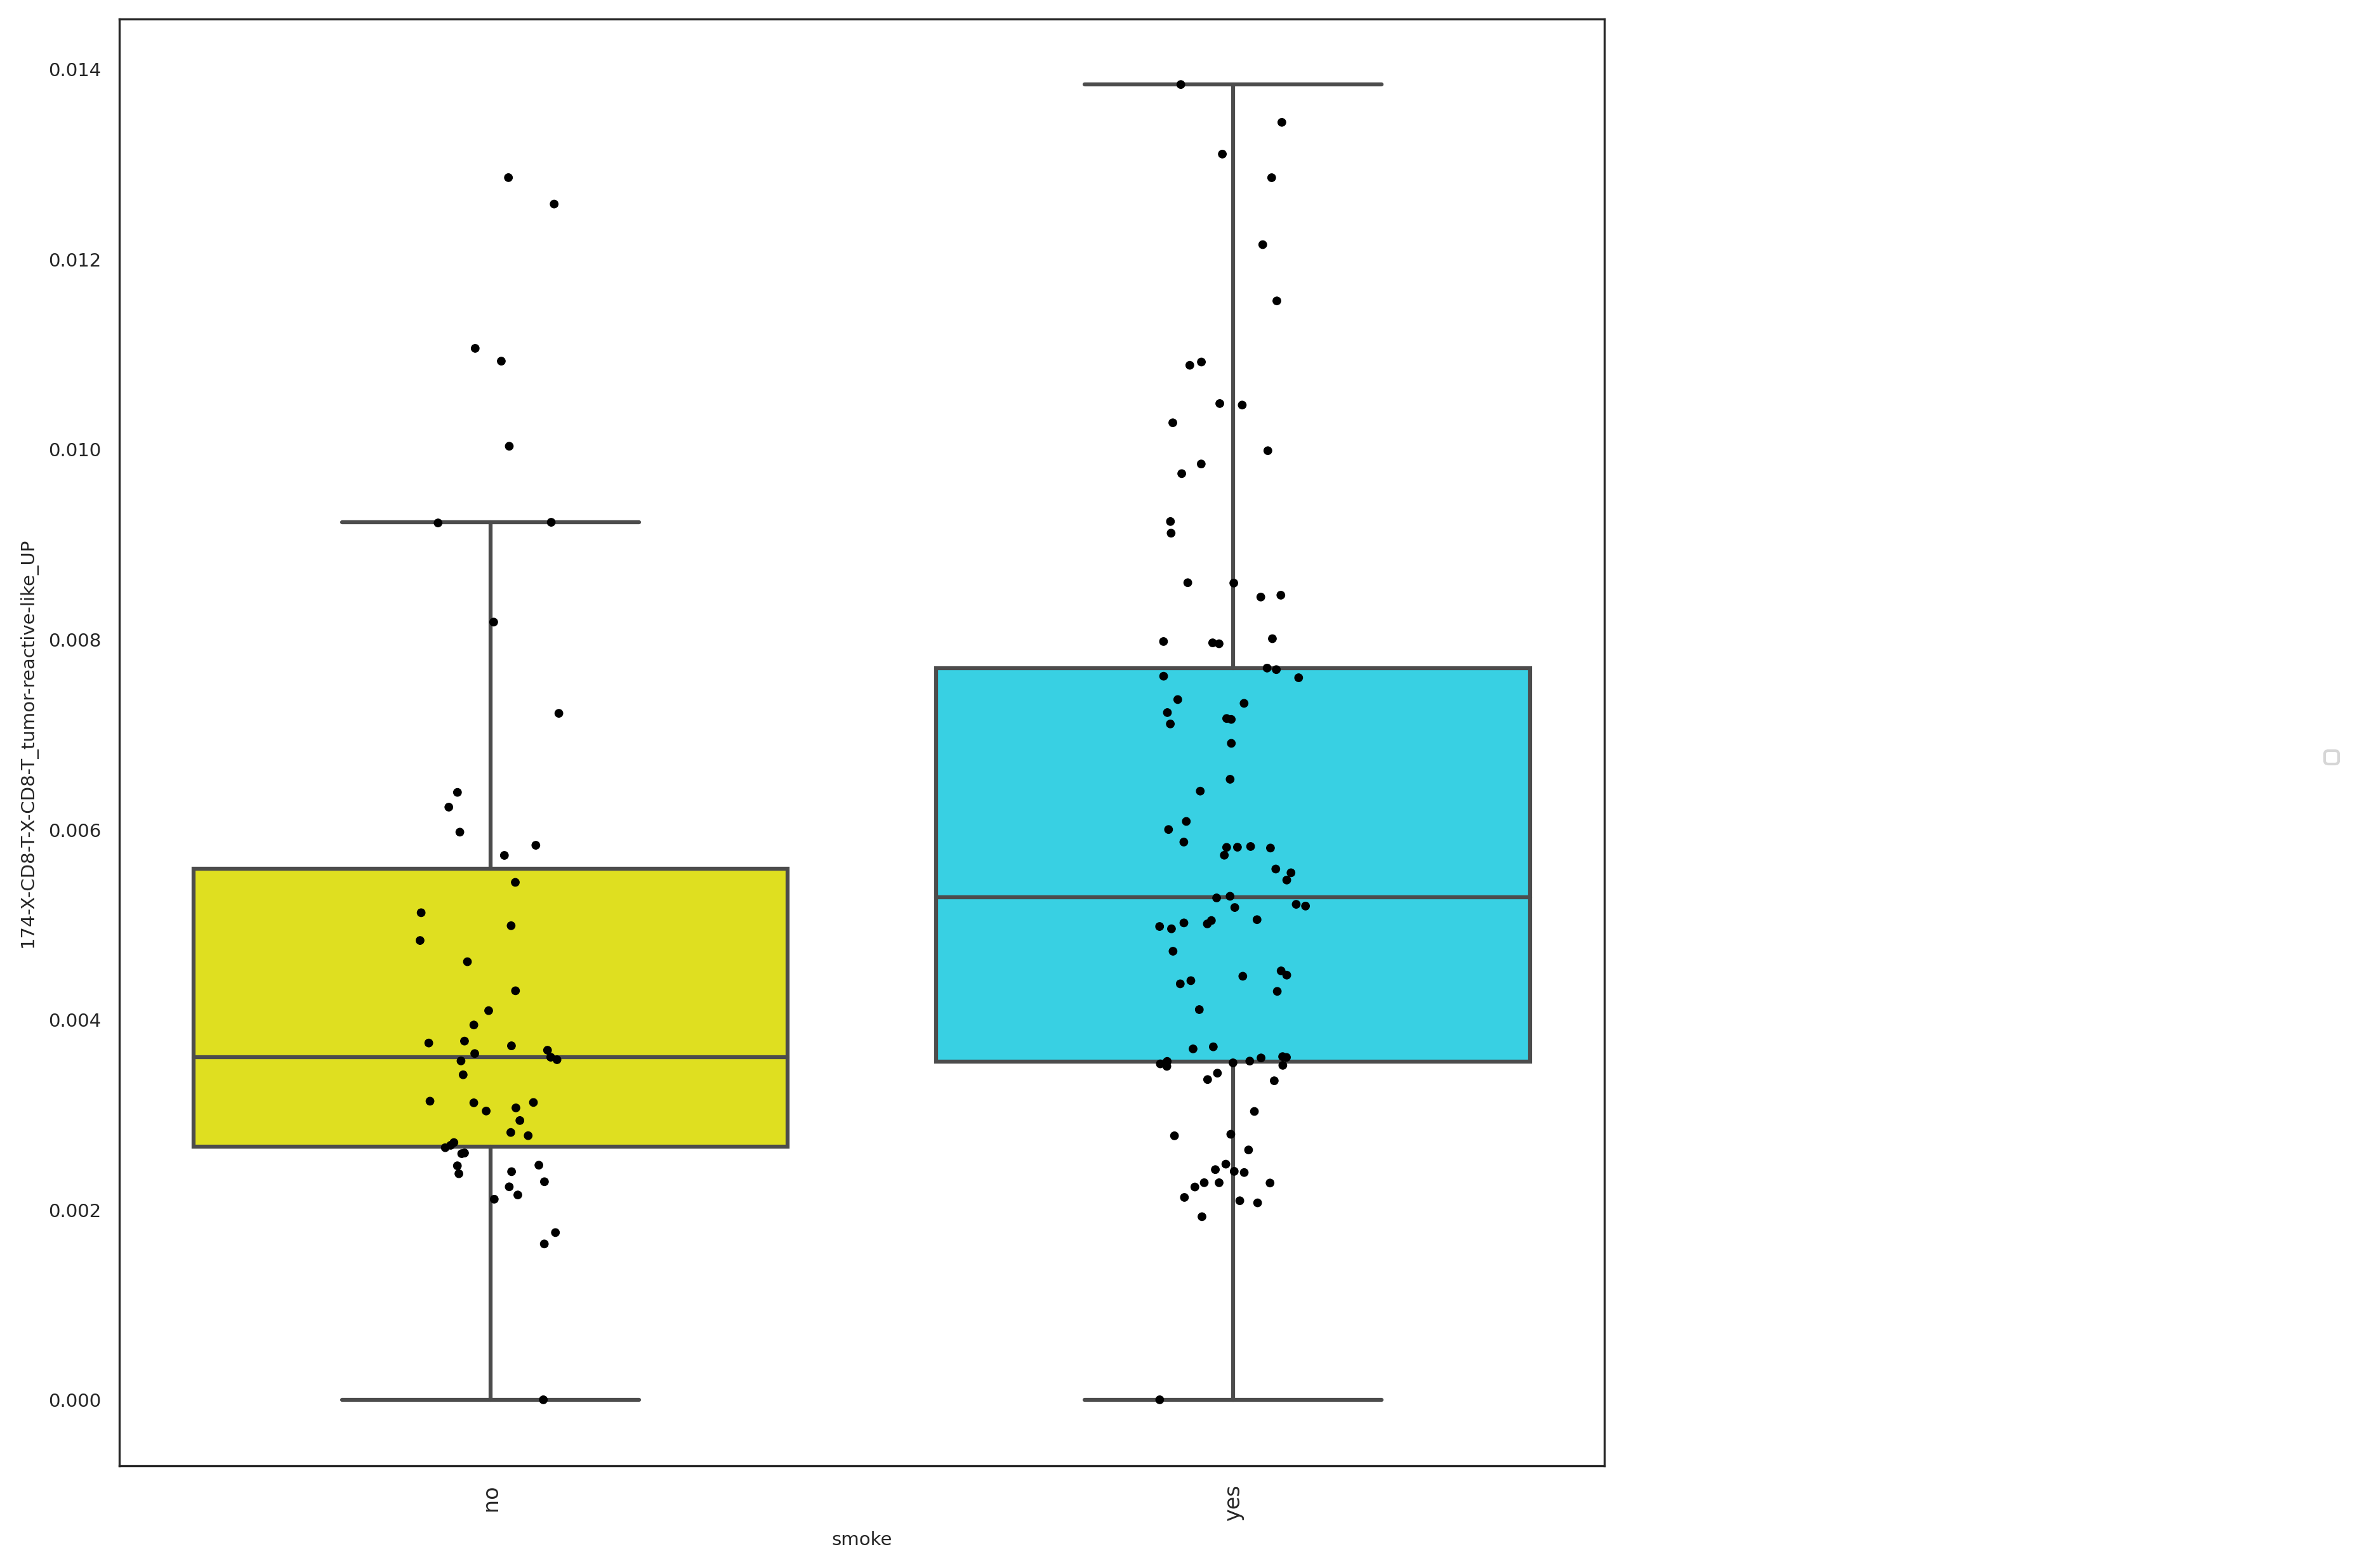

In [94]:
#plot
sns.set_style('white')
factor='174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP'
save_name ='Salcher_patient_CD8_smoker'+factor+'.svg'
hue_order = ['no','yes']
plt.subplots(figsize=(10,10))
sns.boxplot(data=mean_df,x='smoke', 
                y=factor, hue=None, hue_order=None, order=hue_order, 
                orient=None, color=None, palette=color_map_clusters_nogrey, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=mean_df,x='smoke', 
                y=factor, hue=None, hue_order=None, order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
mean_df.to_csv(fig_save_path+ save_name[:-4]+'.csv')
print(save_name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Salcher_patient_CD8_EGFR_mutationr174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP.svg


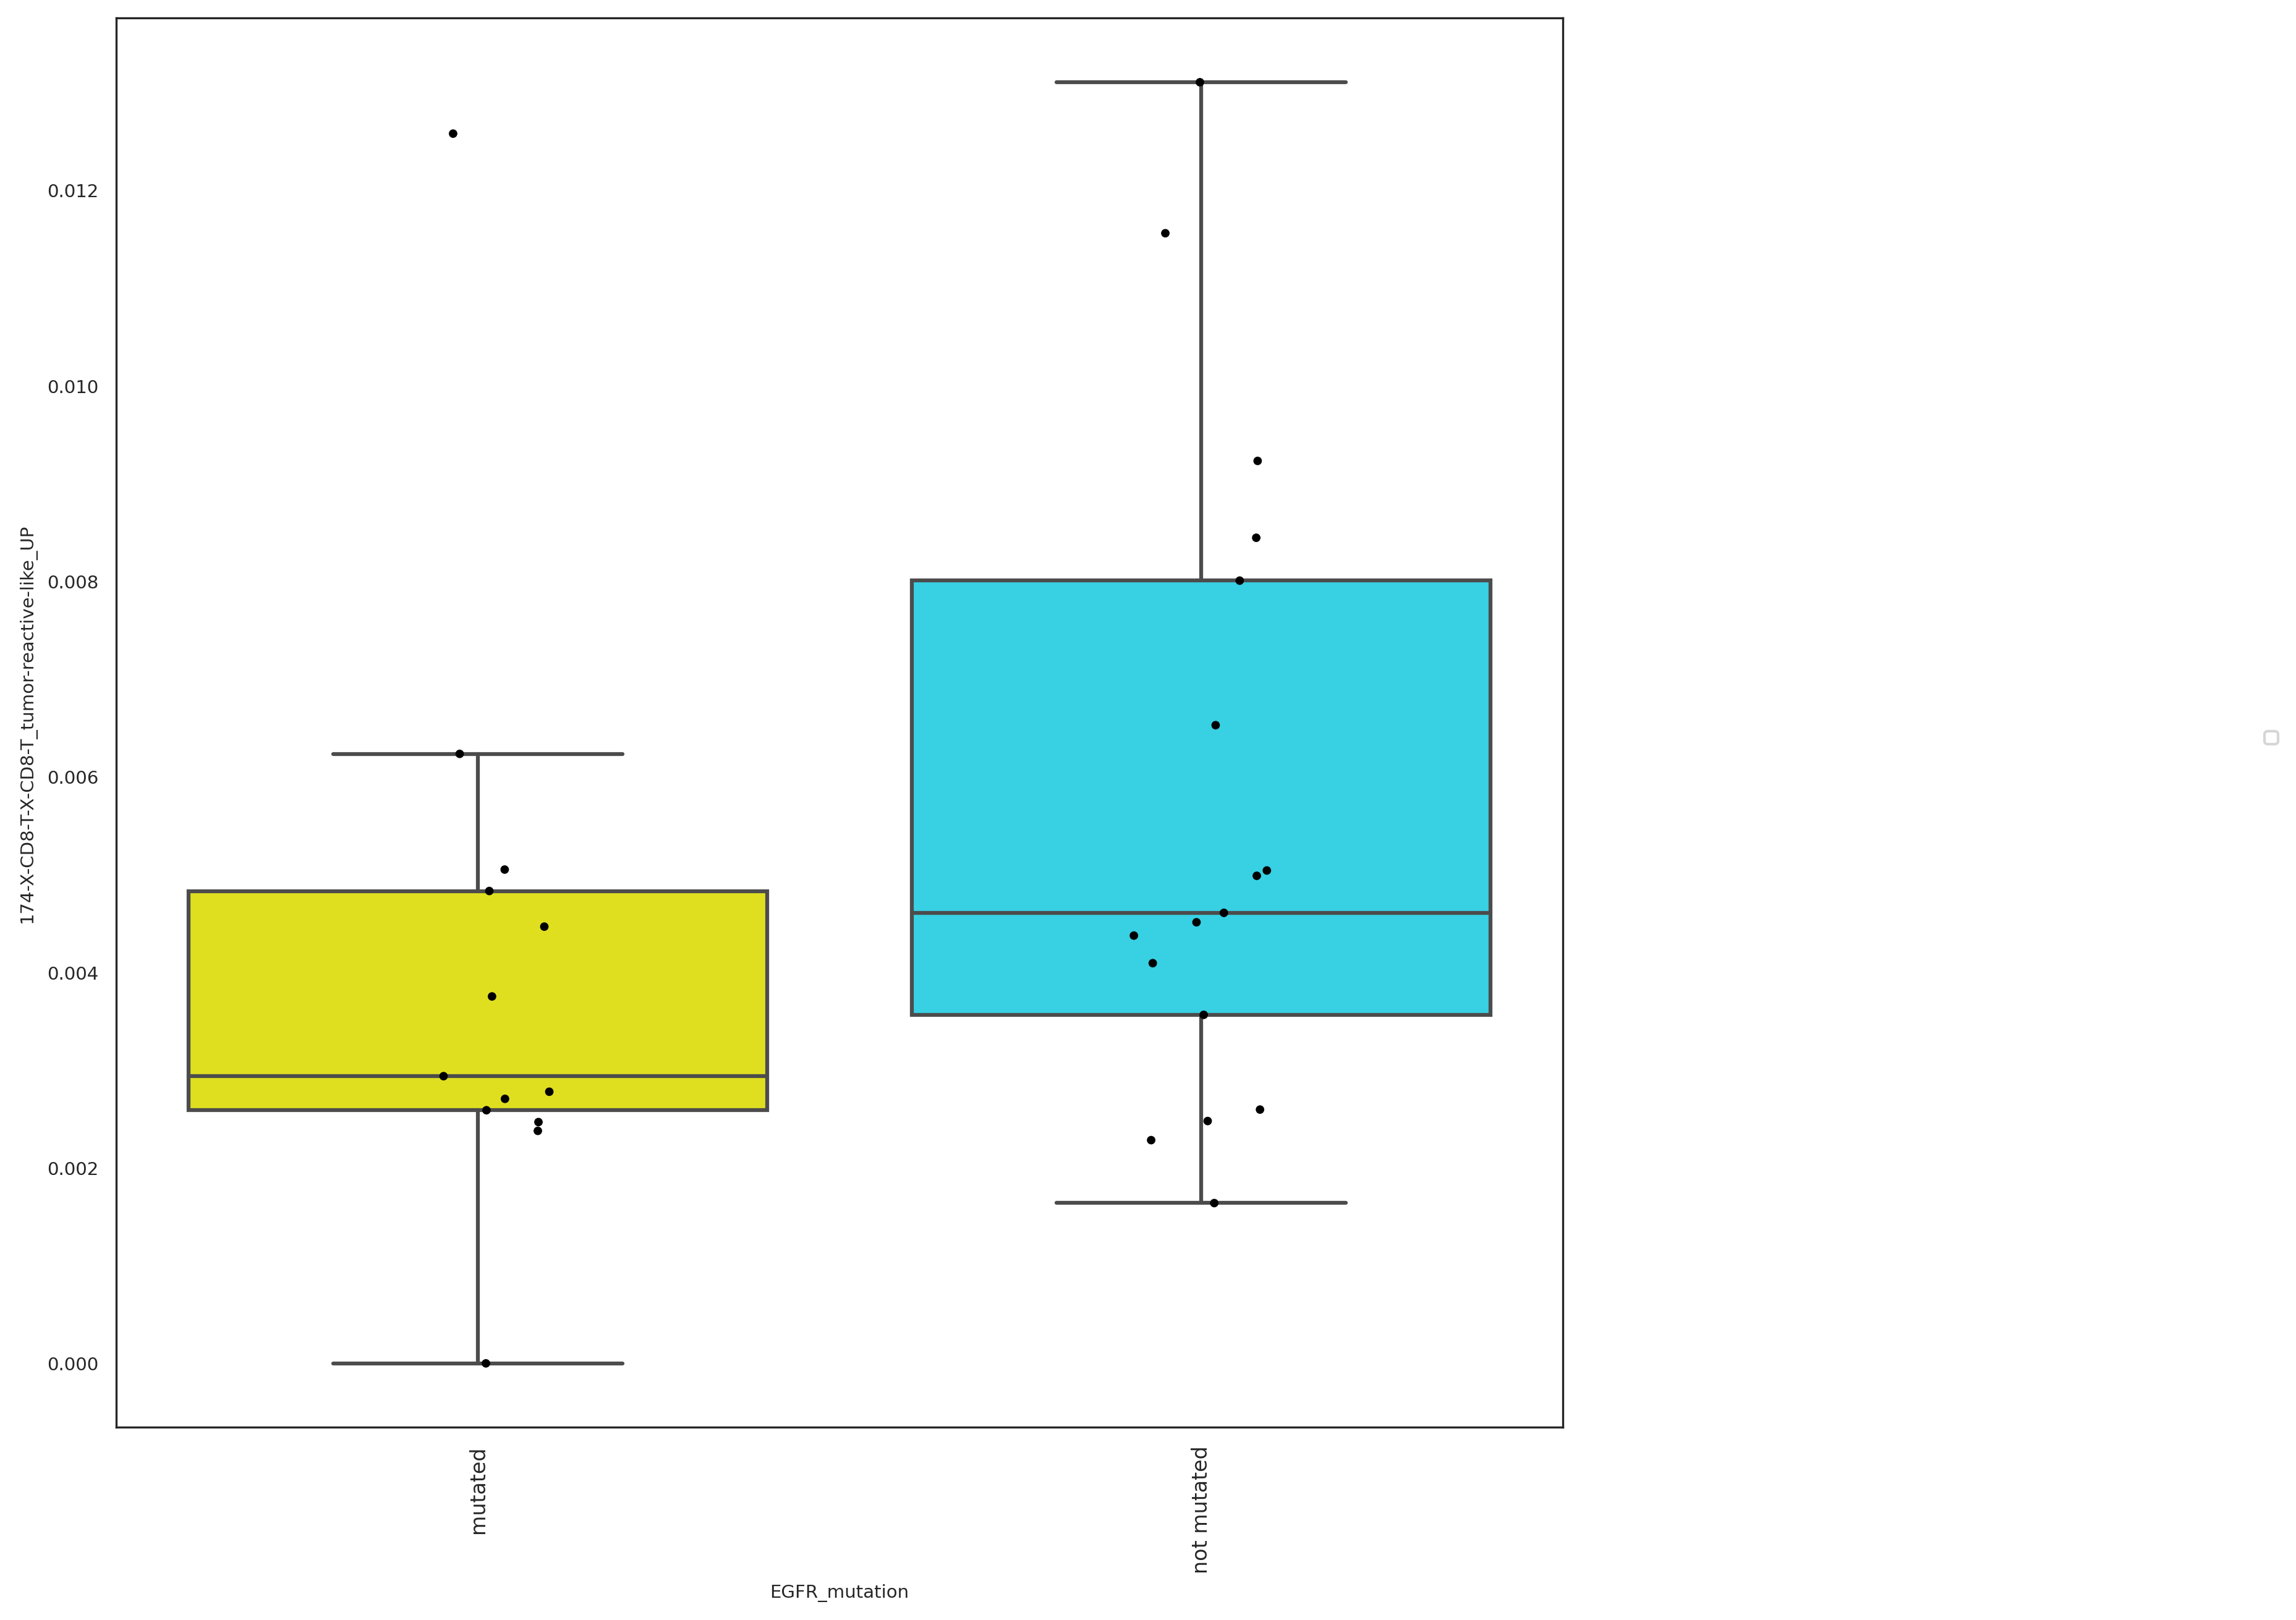

In [95]:
#plot
factor='174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP'
save_name ='Salcher_patient_CD8_EGFR_mutationr'+factor+'.svg'
#hue_order = ['InfluenzaA','EBV','MANA']
plt.subplots(figsize=(10,10))
sns.boxplot(data=mean_df,x='EGFR_mutation', 
                y=factor, hue=None, hue_order=None, #order=hue_order, 
                orient=None, color=None, palette=color_map_clusters_nogrey, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=mean_df,x='EGFR_mutation', 
                y=factor, hue=None, hue_order=None, #order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
mean_df.to_csv(fig_save_path+ save_name[:-4]+'.csv')
print(save_name)

In [96]:
mean_df_test = mean_df.copy()
mean_df_test = mean_df_test[mean_df_test['smoke'].isin(['yes','no'])]
mean_df_test['smoke']  = mean_df_test['smoke'] =='yes'
print(mean_df_test['smoke'].value_counts())
two_sample_test(mean_df_test,'174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP', 
                'smoke',sample_column=None, test='mann-whitney')

True     98
False    55
Name: smoke, dtype: int64


(MannwhitneyuResult(statistic=3499.5, pvalue=0.0022358079378358904),
 0.4535533874072311)

In [97]:
mean_df_test = mean_df.copy()
mean_df_test = mean_df_test[mean_df_test['EGFR_mutation'].isin(['mutated','not mutated'])]
mean_df_test['EGFR_mutation']  = mean_df_test['EGFR_mutation'] =='mutated'
print(mean_df_test['EGFR_mutation'].value_counts())
two_sample_test(mean_df_test,'174-X-CD8-T-X-CD8-T_tumor-reactive-like_UP', 
                'EGFR_mutation',sample_column=None, test='mann-whitney')

False    17
True     13
Name: EGFR_mutation, dtype: int64


(MannwhitneyuResult(statistic=78.0, pvalue=0.18048733052983834),
 -0.5184642814921941)

In [ ]:
mean_df_test

# TAM

In [66]:
#input_genes = set(input_df[input_df['gs.name']=='CD8-T_tumor-reactive-like_UP']['g.name'])

#lambda 0.01
Bassez_et_al = set(['SPP1', 'MMP9', 'CTSL', 'CCL2', 'APOC1', 'RNASE1', 'NUPR1',
        'C15orf48', 'GPNMB', 'CXCL8', 'ADM', 'SMIM25', 'FBP1', 'MMP19',
        'SLC11A1', 'CYP27A1', 'FABP4', 'MARCO', 'IL1RN', 'HMOX1', 'PLA2G7',
        'PLIN2', 'MT1H', 'FABP5', 'CD36', 'PLAUR', 'SDC2', 'MT1G', 'CD68',
        'FN1', 'BLVRB', 'APOE', 'UPP1', 'CHI3L1', 'ANXA2', 'CXCL3', 'SOD2',
        'TREM1', 'CCL7', 'TREM2', 'SCD', 'GLUL', 'CCL18', 'TYROBP',
        'NR1H3', 'NPL', 'CSTB', 'ANPEP', 'CTSD', 'LGALS3'])


#lambda 0.1
Salcher_et_al = {'C1QB', 'C1QA', 'APOC1', 'MARCO', 'C1QC', 'APOE', 'CXCL3', 'FABP4',
       'CCL18', 'MSR1', 'VSIG4', 'GCHFR', 'ACP5', 'CTSD', 'CYP27A1',
       'CD163', 'GPNMB', 'MS4A4A', 'LPL', 'CD68', 'FABP5', 'NUPR1',
       'OLR1', 'FCER1G', 'LYZ', 'FN1', 'RBP4', 'GLUL', 'CTSL', 'TYROBP',
       'MS4A7', 'PPARG', 'SCD', 'CFD', 'ALDH2', 'SLC11A1', 'TREM2',
       'DAB2', 'GPD1', 'IFI6', 'CES1', 'TREM1', 'AGRP', 'CD9', 'HLA-DQA1',
       'PELATON', 'S100A9', 'ASAH1', 'RETN', 'HNMT'}

#lambda 0.1
Zhang_et_al =set(['SPP1', 'RNASE1', 'FN1', 'CCL2', 'NUPR1', 'GPNMB', 'CTSD',
        'SLC11A1', 'CTSL', 'IFI27', 'PLTP', 'TGFBI', 'SMIM25', 'TREM1',
        'CD163', 'S100A9', 'APOE', 'FCGR3A', 'MMP14', 'CD14', 'ADM',
        'IFI6', 'MMP9', 'TIMP2', 'APOC1', 'HTRA1', 'CCL8', 'C15orf48',
        'MIF', 'SOD2', 'MSR1', 'DAB2', 'VSIG4', 'LRP1', 'SCD', 'MMP19',
        'CD9', 'ADAM8', 'CD68', 'TYMP', 'FTL', 'HK2', 'BNIP3', 'FCGR2A',
        'CSTB', 'BCAT1', 'FABP5', 'CTSB', 'APLP2', 'ENG'])

In [69]:
overerlap_TAM= pd.DataFrame()

for i in range(adata.uns['SPECTRA_markers'].shape[0]):
    overerlap_TAM.loc[i,'overlap'] = overlap_coefficient(set(adata.uns['SPECTRA_markers'][i][0:50]),Bassez_et_al)
overerlap_TAM.sort_values('overlap',ascending=False)[0:50]

overlap
193     0.40
102     0.32
2       0.22
50      0.20
188     0.20
192     0.18
234     0.14
41      0.12
191     0.12
63      0.10
94      0.10
138     0.10
130     0.10
183     0.08
126     0.08
128     0.08
69      0.08
236     0.08
189     0.06
88      0.06
186     0.06
190     0.06
52      0.06
78      0.06
75      0.06
72      0.06
67      0.06
74      0.06
235     0.06
147     0.06
112     0.06
6       0.04
139     0.04
30      0.04
34      0.04
146     0.04
132     0.04
10      0.04
46      0.04
232     0.04
40      0.04
194     0.04
56      0.04
240     0.04
109     0.02
134     0.02
196     0.02
156     0.02
73      0.02
71      0.02

In [72]:
Bassez_et_al.intersection(Zhang_et_al) - Salcher_et_al

{'ADM',
 'C15orf48',
 'CCL2',
 'CSTB',
 'MMP19',
 'MMP9',
 'RNASE1',
 'SMIM25',
 'SOD2',
 'SPP1'}

In [73]:
Bassez_et_al.intersection(Zhang_et_al).intersection(Salcher_et_al)

{'APOC1',
 'APOE',
 'CD68',
 'CTSD',
 'CTSL',
 'FABP5',
 'FN1',
 'GPNMB',
 'NUPR1',
 'SCD',
 'SLC11A1',
 'TREM1'}

saved Figure to: /data/peer/wallet/Jupyter/SPADE_Peer_validation/figures/Venn_Salcher_0.1_Zhang_Bassez_nooffsetTAM.svg


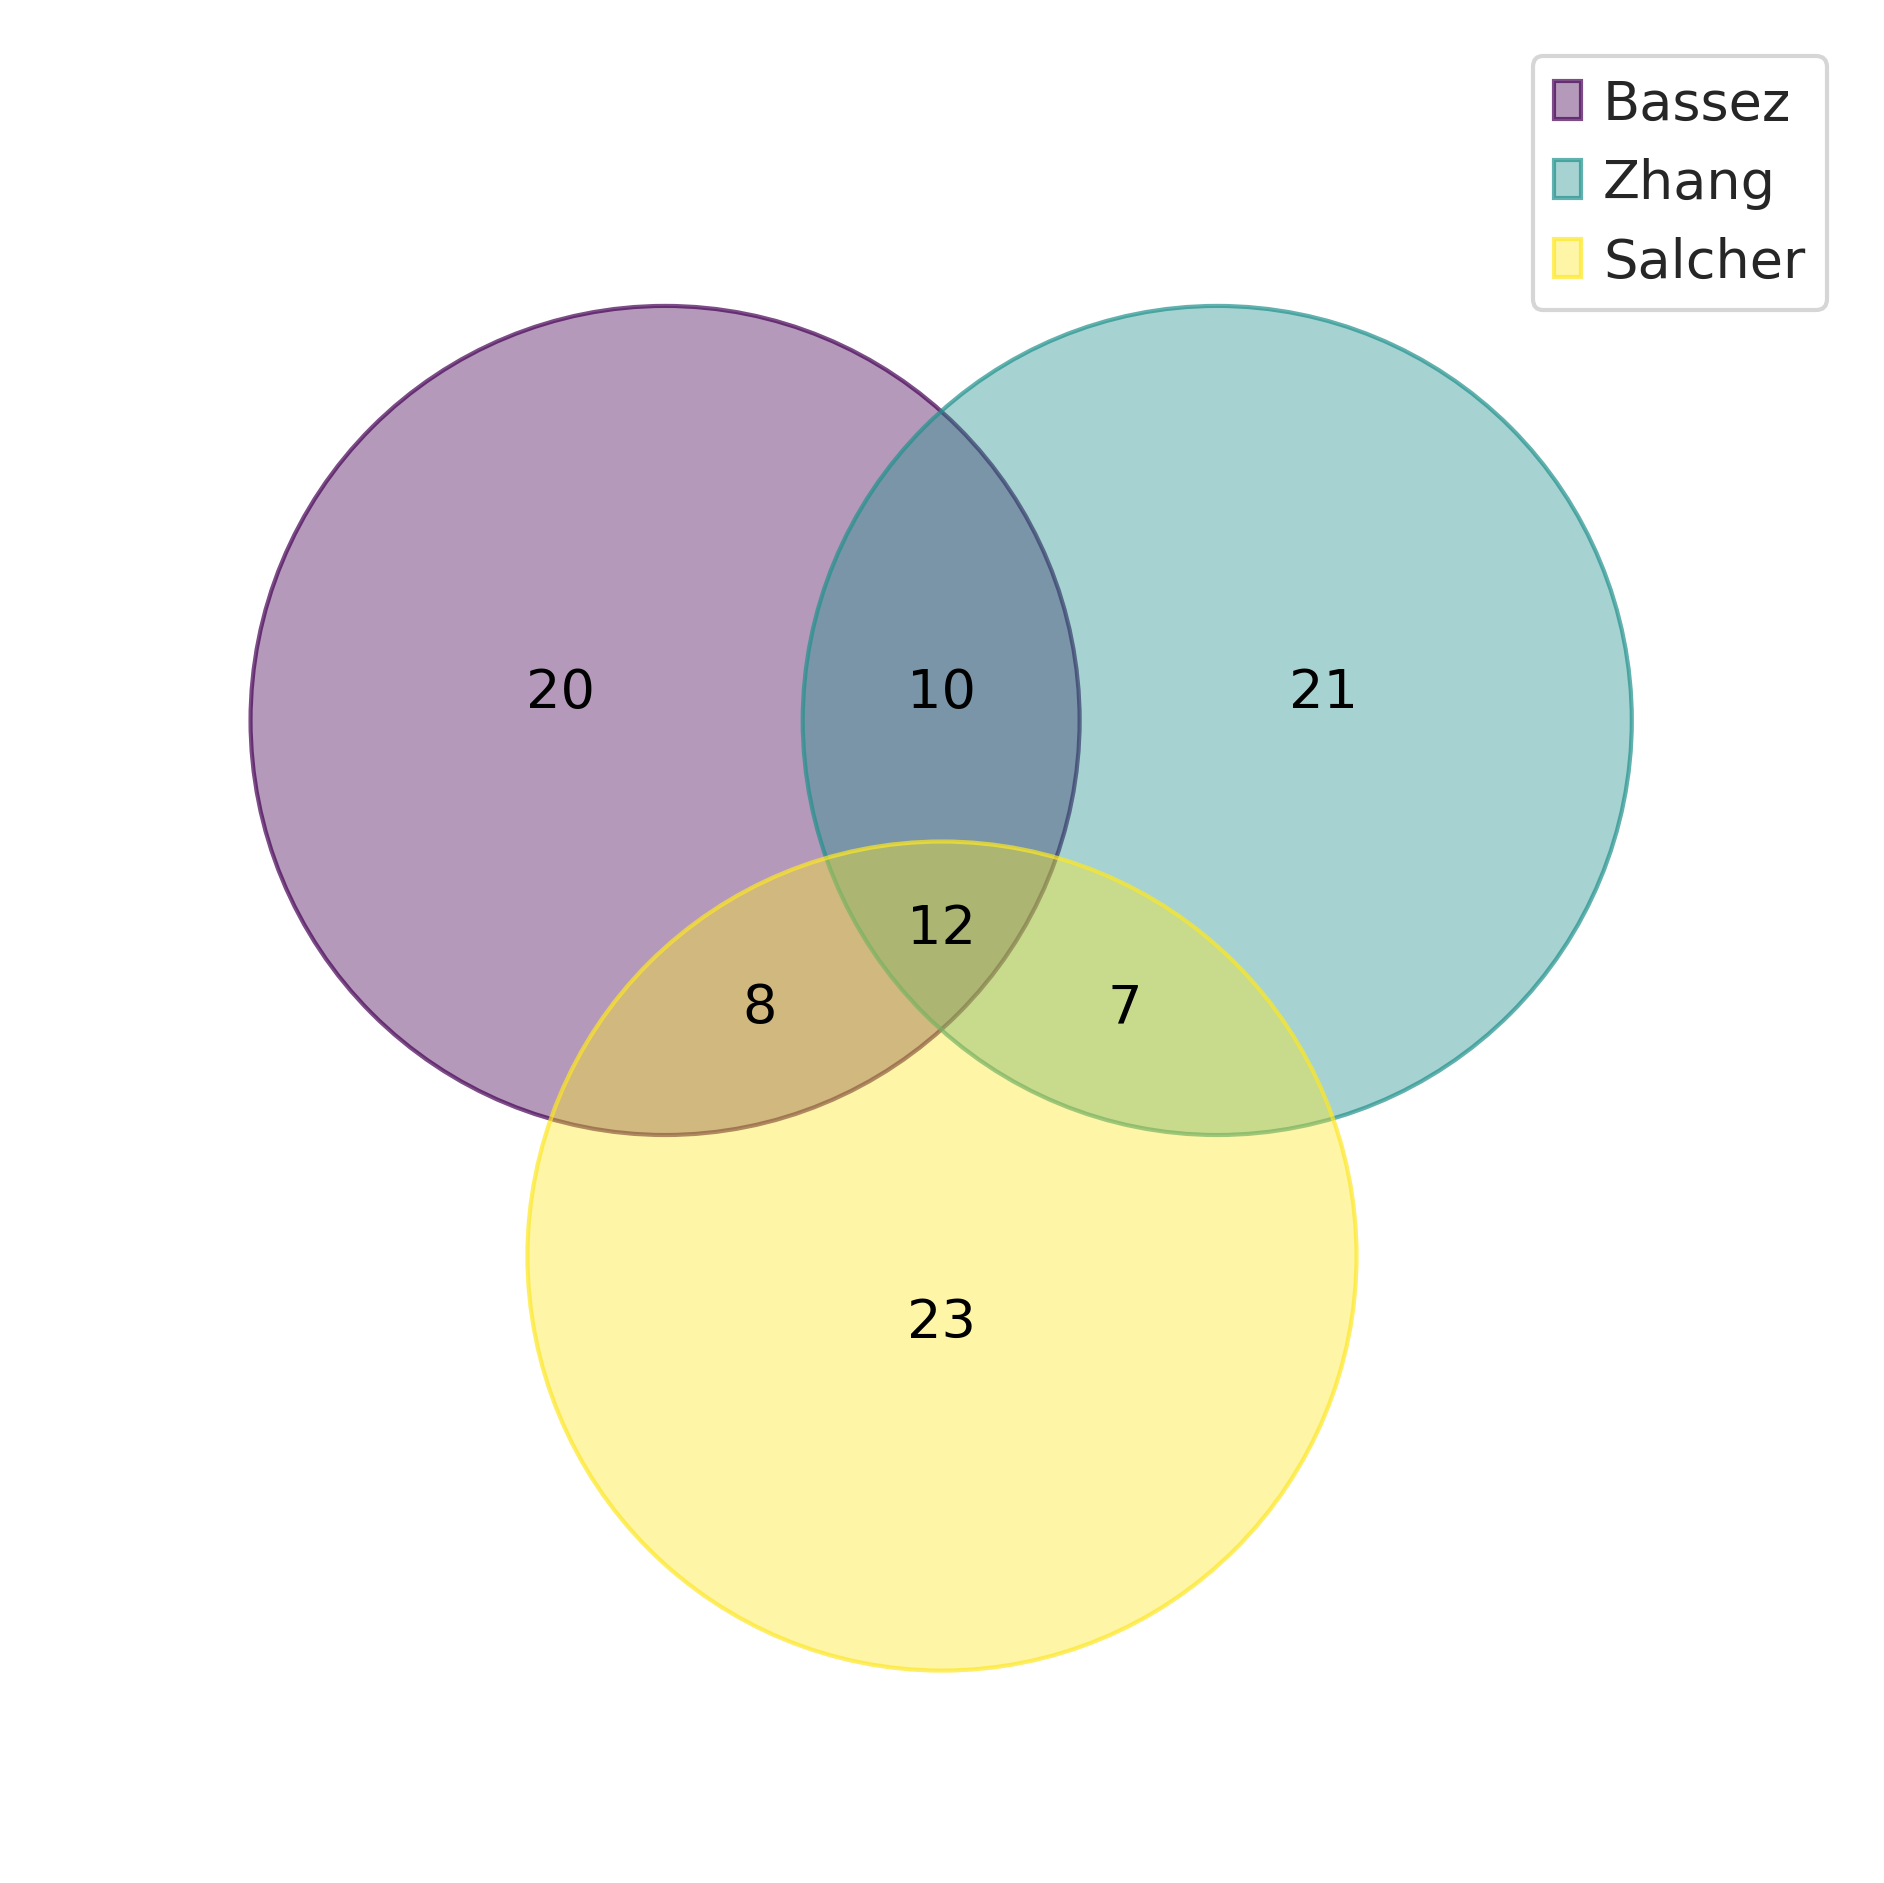

In [74]:
import venn
venn.venn({ 'Bassez':Bassez_et_al, 'Zhang':Zhang_et_al, 'Salcher':Salcher_et_al,
          #'Salcher':Salcher_et_al
          })
save_fig_path = fig_save_path+'Venn_Salcher_0.1_Zhang_Bassez_nooffset'+'TAM'+'.svg'
plt.savefig(save_fig_path,dpi=300)
print('saved Figure to:',save_fig_path)

In [76]:
adata_Mac = adata[adata.obs['annotation_Spectra']=='Mac']
adata_Mac

View of AnnData object with n_obs × n_vars = 365167 × 17688
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'annotation', 'annotation_Spectra', '0-X-global-X-

In [77]:
#aggregate per patient
mean_df = aggregate_scores(adata_Mac,['193-X-Mac-X-193'],'donor_id',
                            zero_cutoff =0.001,aggregate_function='mean')[0]

In [78]:
mean_df = mean_df.fillna(0)
mean_df

193-X-Mac-X-193
UKIM-V-2_P6                                0.008200
Wu_Zhou_2021_P15                           0.002964
UKIM-V_P2                                  0.012163
Leader_Merad_2021_714                      0.008606
Reyfman_Misharin_2018_Donor_06             0.016013
...                                             ...
Leader_Merad_2021_403                      0.010745
Wu_Zhou_2021_P36                           0.003342
Lambrechts_Thienpont_2018_6149v1_2         0.008953
Leader_Merad_2021_630                      0.011443
Wu_Zhou_2021_P20                           0.003368

[307 rows x 1 columns]

In [79]:
mapping_dict = dict(zip(list(adata.obs['donor_id']),list(adata.obs['ever_smoker'])))
mapping_dict_EGFR = dict(zip(list(adata.obs['donor_id']),list(adata.obs['EGFR_mutation'])))
mapping_dict_ERBB2 = dict(zip(list(adata.obs['donor_id']),list(adata.obs['ERBB2_mutation'])))
mapping_dict_ROS = dict(zip(list(adata.obs['donor_id']),list(adata.obs['ROS_mutation'])))
mapping_dict_BRAF = dict(zip(list(adata.obs['donor_id']),list(adata.obs['BRAF_mutation'])))
mapping_dict_ALK = dict(zip(list(adata.obs['donor_id']),list(adata.obs['ALK_mutation'])))
mapping_dict_age = dict(zip(list(adata.obs['donor_id']),list(adata.obs['age'])))
mapping_dict_sex = dict(zip(list(adata.obs['donor_id']),list(adata.obs['sex'])))
mapping_dict_stage = dict(zip(list(adata.obs['donor_id']),list(adata.obs['uicc_stage'])))

In [80]:
mean_df['smoke'] = mean_df.index.map(mapping_dict)
mean_df['EGFR_mutation'] = mean_df.index.map(mapping_dict_EGFR)
mean_df['ERBB2_mutation'] = mean_df.index.map(mapping_dict_ERBB2)
mean_df['ROS_mutation'] = mean_df.index.map(mapping_dict_ROS)
mean_df['BRAF_mutation'] = mean_df.index.map(mapping_dict_BRAF)
mean_df['ALK_mutation'] = mean_df.index.map(mapping_dict_ALK)
mean_df['age'] = mean_df.index.map(mapping_dict_age)
mean_df['sex'] = mean_df.index.map(mapping_dict_sex)
mean_df['stage'] = mean_df.index.map(mapping_dict_stage)
mean_df
#mean_df['sex'] = mean_df.index.map(mapping_dict_sex)

193-X-Mac-X-193 smoke EGFR_mutation  \
UKIM-V-2_P6                                0.008200   yes           NaN   
Wu_Zhou_2021_P15                           0.002964   NaN           NaN   
UKIM-V_P2                                  0.012163   yes           NaN   
Leader_Merad_2021_714                      0.008606   yes           NaN   
Reyfman_Misharin_2018_Donor_06             0.016013    no           NaN   
...                                             ...   ...           ...   
Leader_Merad_2021_403                      0.010745   yes           NaN   
Wu_Zhou_2021_P36                           0.003342   NaN           NaN   
Lambrechts_Thienpont_2018_6149v1_2         0.008953   yes           NaN   
Leader_Merad_2021_630                      0.011443   yes           NaN   
Wu_Zhou_2021_P20                           0.003368   NaN           NaN   

                                   ERBB2_mutation ROS_mutation BRAF_mutation  \
UKIM-V-2_P6                                   NaN          NaN           NaN   
Wu_Zhou_2021_P15                              NaN          NaN           NaN   
UKIM-V_P2                                     NaN          NaN           NaN   
Leader_Merad_2021_714                         NaN          NaN           NaN   
Reyfman_Misharin_2018_Donor_06                NaN          NaN           NaN   
...                                           ...          ...           ...   
Leader_Merad_2021_403                         NaN          NaN           NaN   
Wu_Zhou_2021_P36                              NaN          NaN           NaN   
Lambrechts_Thienpont_2018_6149v1_2            NaN          NaN           NaN   
Leader_Merad_2021_630                         NaN          NaN           NaN   
Wu_Zhou_2021_P20                              NaN          NaN           NaN   

                                   ALK_mutation   age     sex       stage  
UKIM-V-2_P6                                 NaN  72.0    male          II  
Wu_Zhou_2021_P15                            NaN  64.0    male   III or IV  
UKIM-V_P2                                   NaN  70.0  female           I  
Leader_Merad_2021_714                       NaN  76.0  female          II  
Reyfman_Misharin_2018_Donor_06              NaN  22.0  female  non-cancer  
...                                         ...   ...     ...         ...  
Leader_Merad_2021_403                       NaN  67.0    male         III  
Wu_Zhou_2021_P36                            NaN  42.0    male   III or IV  
Lambrechts_Thienpont_2018_6149v1_2          NaN  86.0    male          II  
Leader_Merad_2021_630                       NaN  66.0    male           I  
Wu_Zhou_2021_P20                            NaN  59.0    male   III or IV  

[307 rows x 10 columns]

In [81]:
#remove other mutations and non cancer
mean_df = mean_df[mean_df['stage']!='non-cancer']
mean_df = mean_df[mean_df['ERBB2_mutation']!='mutated']
mean_df = mean_df[mean_df['ROS_mutation']!='mutated']
mean_df = mean_df[mean_df['ALK_mutation']!='mutated']
mean_df = mean_df[mean_df['BRAF_mutation']!='mutated']
mean_df

193-X-Mac-X-193 smoke EGFR_mutation  \
UKIM-V-2_P6                                0.008200   yes           NaN   
Wu_Zhou_2021_P15                           0.002964   NaN           NaN   
UKIM-V_P2                                  0.012163   yes           NaN   
Leader_Merad_2021_714                      0.008606   yes           NaN   
Maynard_Bivona_2020_TH223                  0.002508    no       mutated   
...                                             ...   ...           ...   
Leader_Merad_2021_403                      0.010745   yes           NaN   
Wu_Zhou_2021_P36                           0.003342   NaN           NaN   
Lambrechts_Thienpont_2018_6149v1_2         0.008953   yes           NaN   
Leader_Merad_2021_630                      0.011443   yes           NaN   
Wu_Zhou_2021_P20                           0.003368   NaN           NaN   

                                   ERBB2_mutation ROS_mutation BRAF_mutation  \
UKIM-V-2_P6                                   NaN          NaN           NaN   
Wu_Zhou_2021_P15                              NaN          NaN           NaN   
UKIM-V_P2                                     NaN          NaN           NaN   
Leader_Merad_2021_714                         NaN          NaN           NaN   
Maynard_Bivona_2020_TH223             not mutated  not mutated   not mutated   
...                                           ...          ...           ...   
Leader_Merad_2021_403                         NaN          NaN           NaN   
Wu_Zhou_2021_P36                              NaN          NaN           NaN   
Lambrechts_Thienpont_2018_6149v1_2            NaN          NaN           NaN   
Leader_Merad_2021_630                         NaN          NaN           NaN   
Wu_Zhou_2021_P20                              NaN          NaN           NaN   

                                   ALK_mutation   age     sex      stage  
UKIM-V-2_P6                                 NaN  72.0    male         II  
Wu_Zhou_2021_P15                            NaN  64.0    male  III or IV  
UKIM-V_P2                                   NaN  70.0  female          I  
Leader_Merad_2021_714                       NaN  76.0  female         II  
Maynard_Bivona_2020_TH223           not mutated  54.0  female        III  
...                                         ...   ...     ...        ...  
Leader_Merad_2021_403                       NaN  67.0    male        III  
Wu_Zhou_2021_P36                            NaN  42.0    male  III or IV  
Lambrechts_Thienpont_2018_6149v1_2          NaN  86.0    male         II  
Leader_Merad_2021_630                       NaN  66.0    male          I  
Wu_Zhou_2021_P20                            NaN  59.0    male  III or IV  

[207 rows x 10 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Salcher_patient_CD8_smoker193-X-Mac-X-193.svg


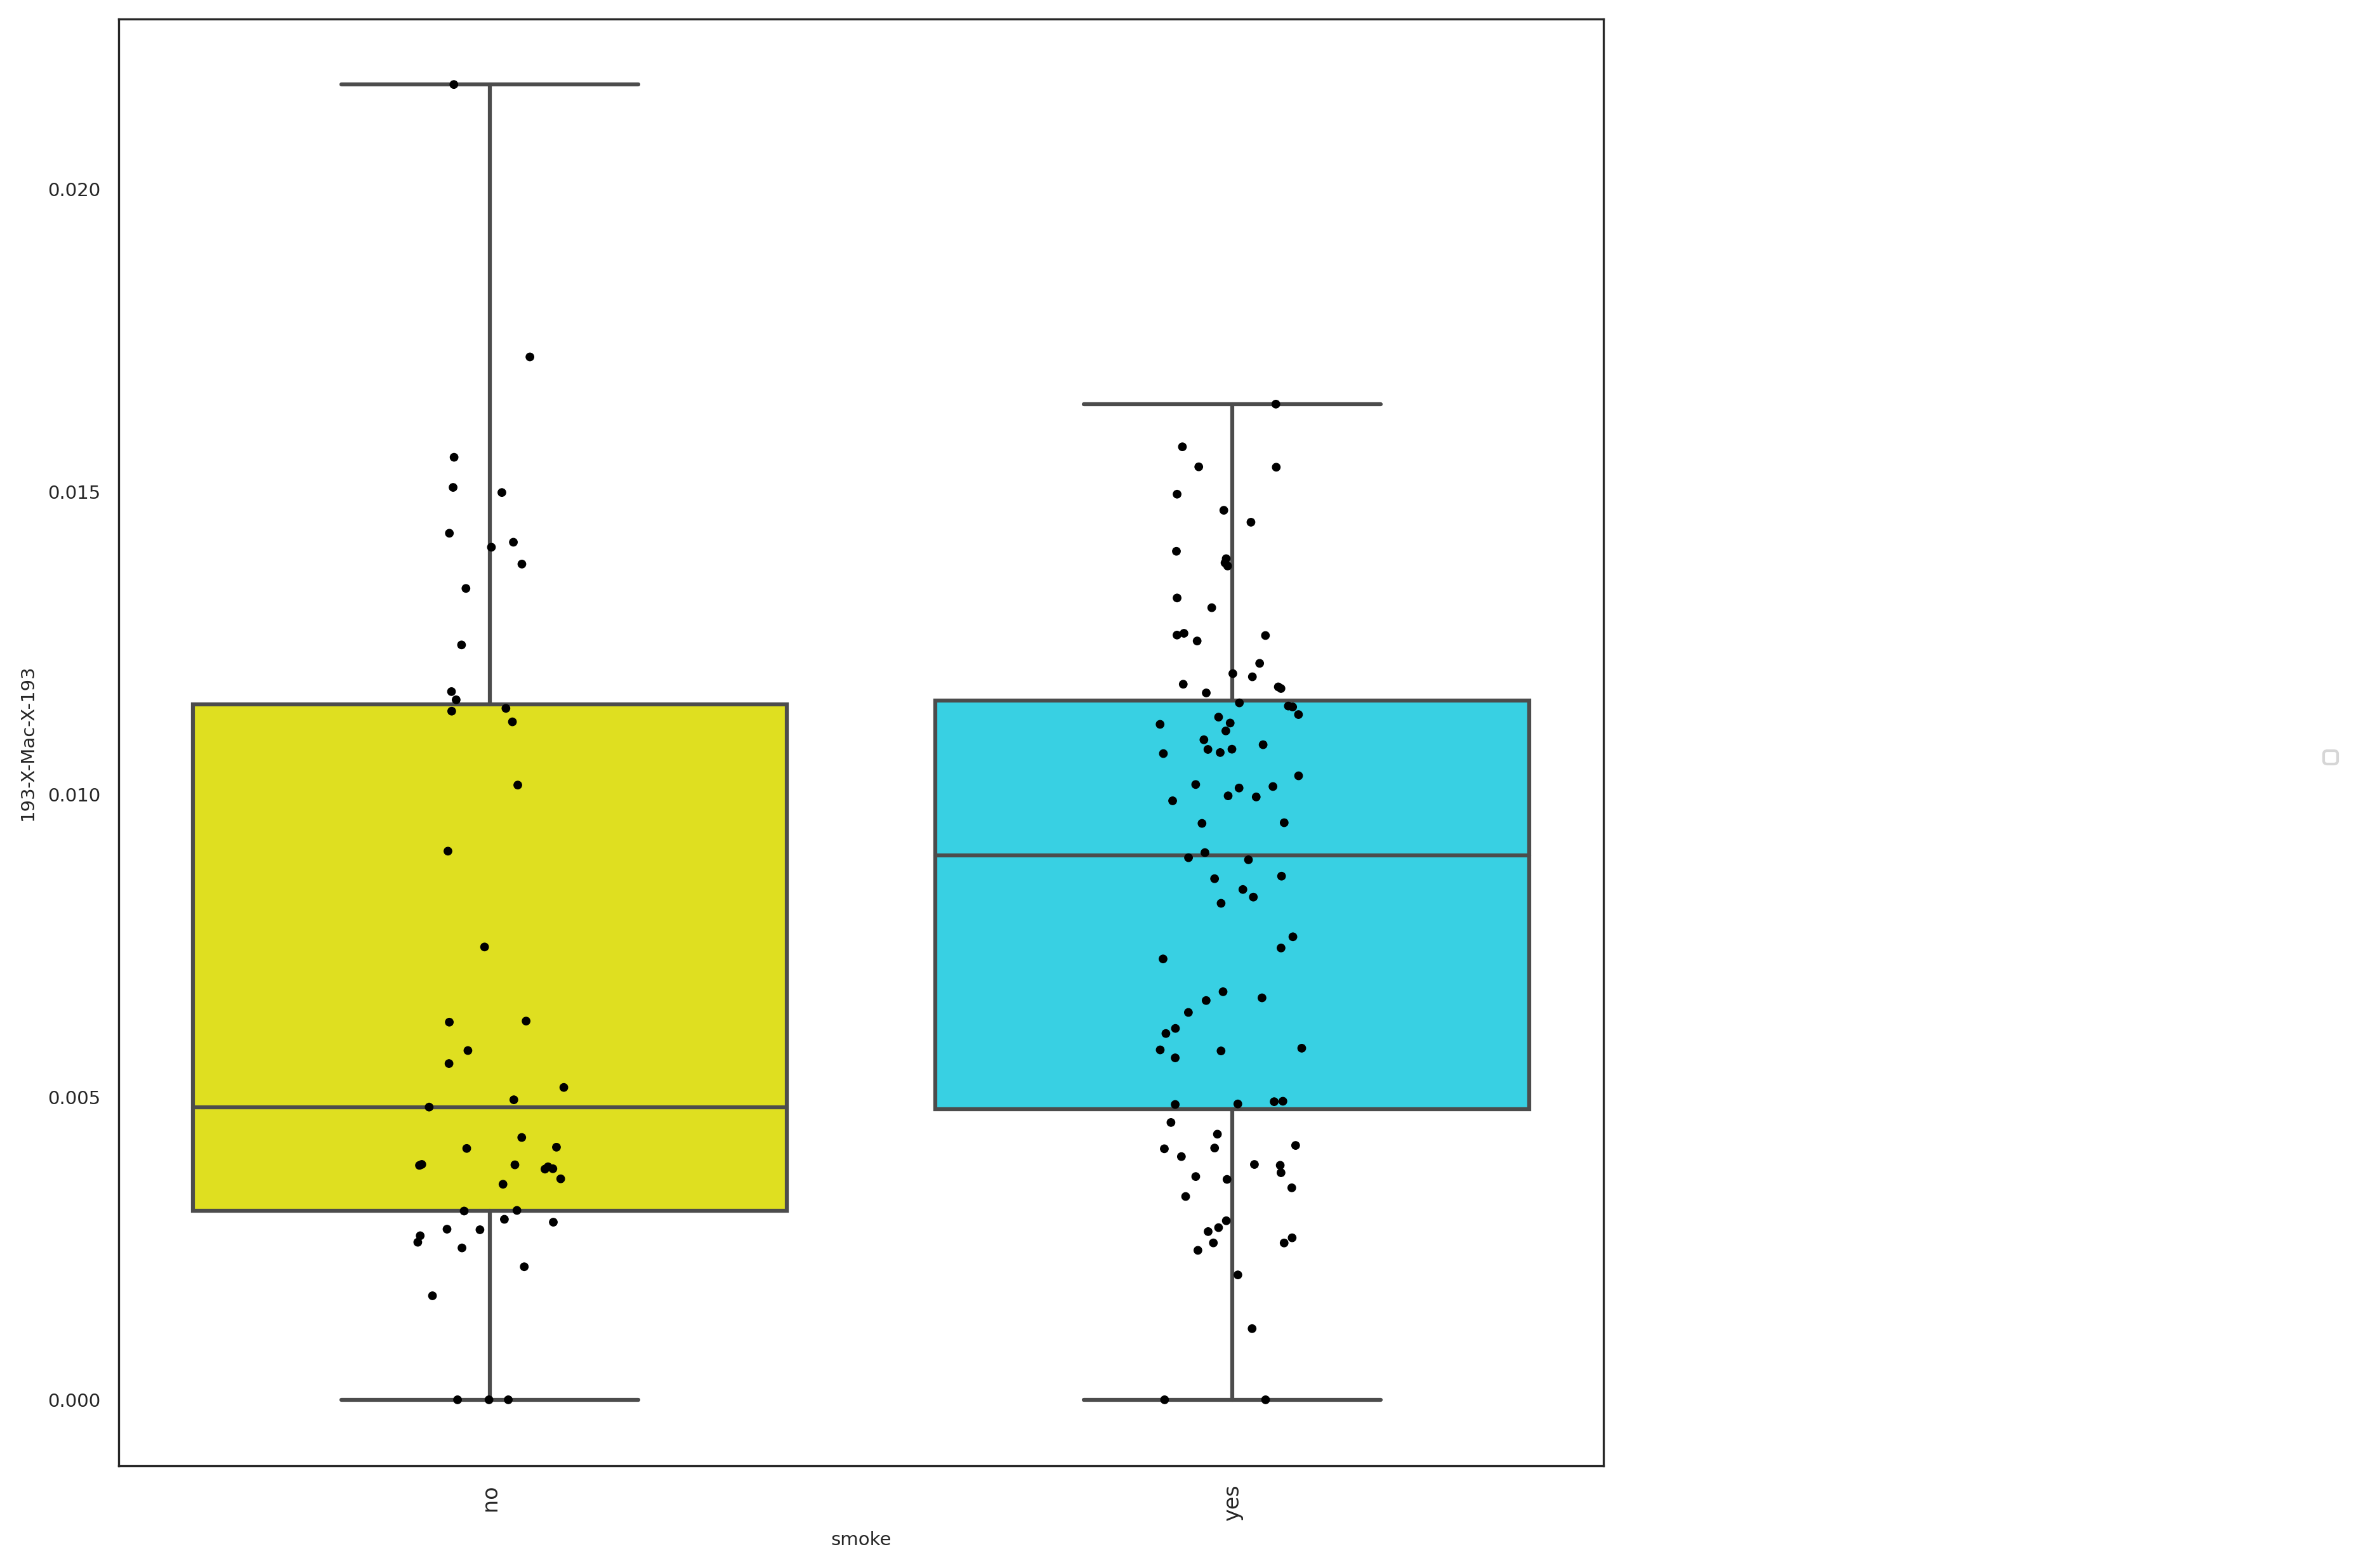

In [135]:
#plot
factor='193-X-Mac-X-193'
save_name ='Salcher_patient_CD8_smoker'+factor+'.svg'
#hue_order = ['InfluenzaA','EBV','MANA']
plt.subplots(figsize=(10,10))
sns.boxplot(data=mean_df,x='smoke', 
                y=factor, hue=None, hue_order=None, #order=hue_order, 
                orient=None, color=None, palette=color_map_clusters_nogrey, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=mean_df,x='smoke', 
                y=factor, hue=None, hue_order=None, #order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
mean_df.to_csv(fig_save_path+ save_name[:-4]+'.csv')
print(save_name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Salcher_patient_CD8_EGFR_mutationr193-X-Mac-X-193.svg


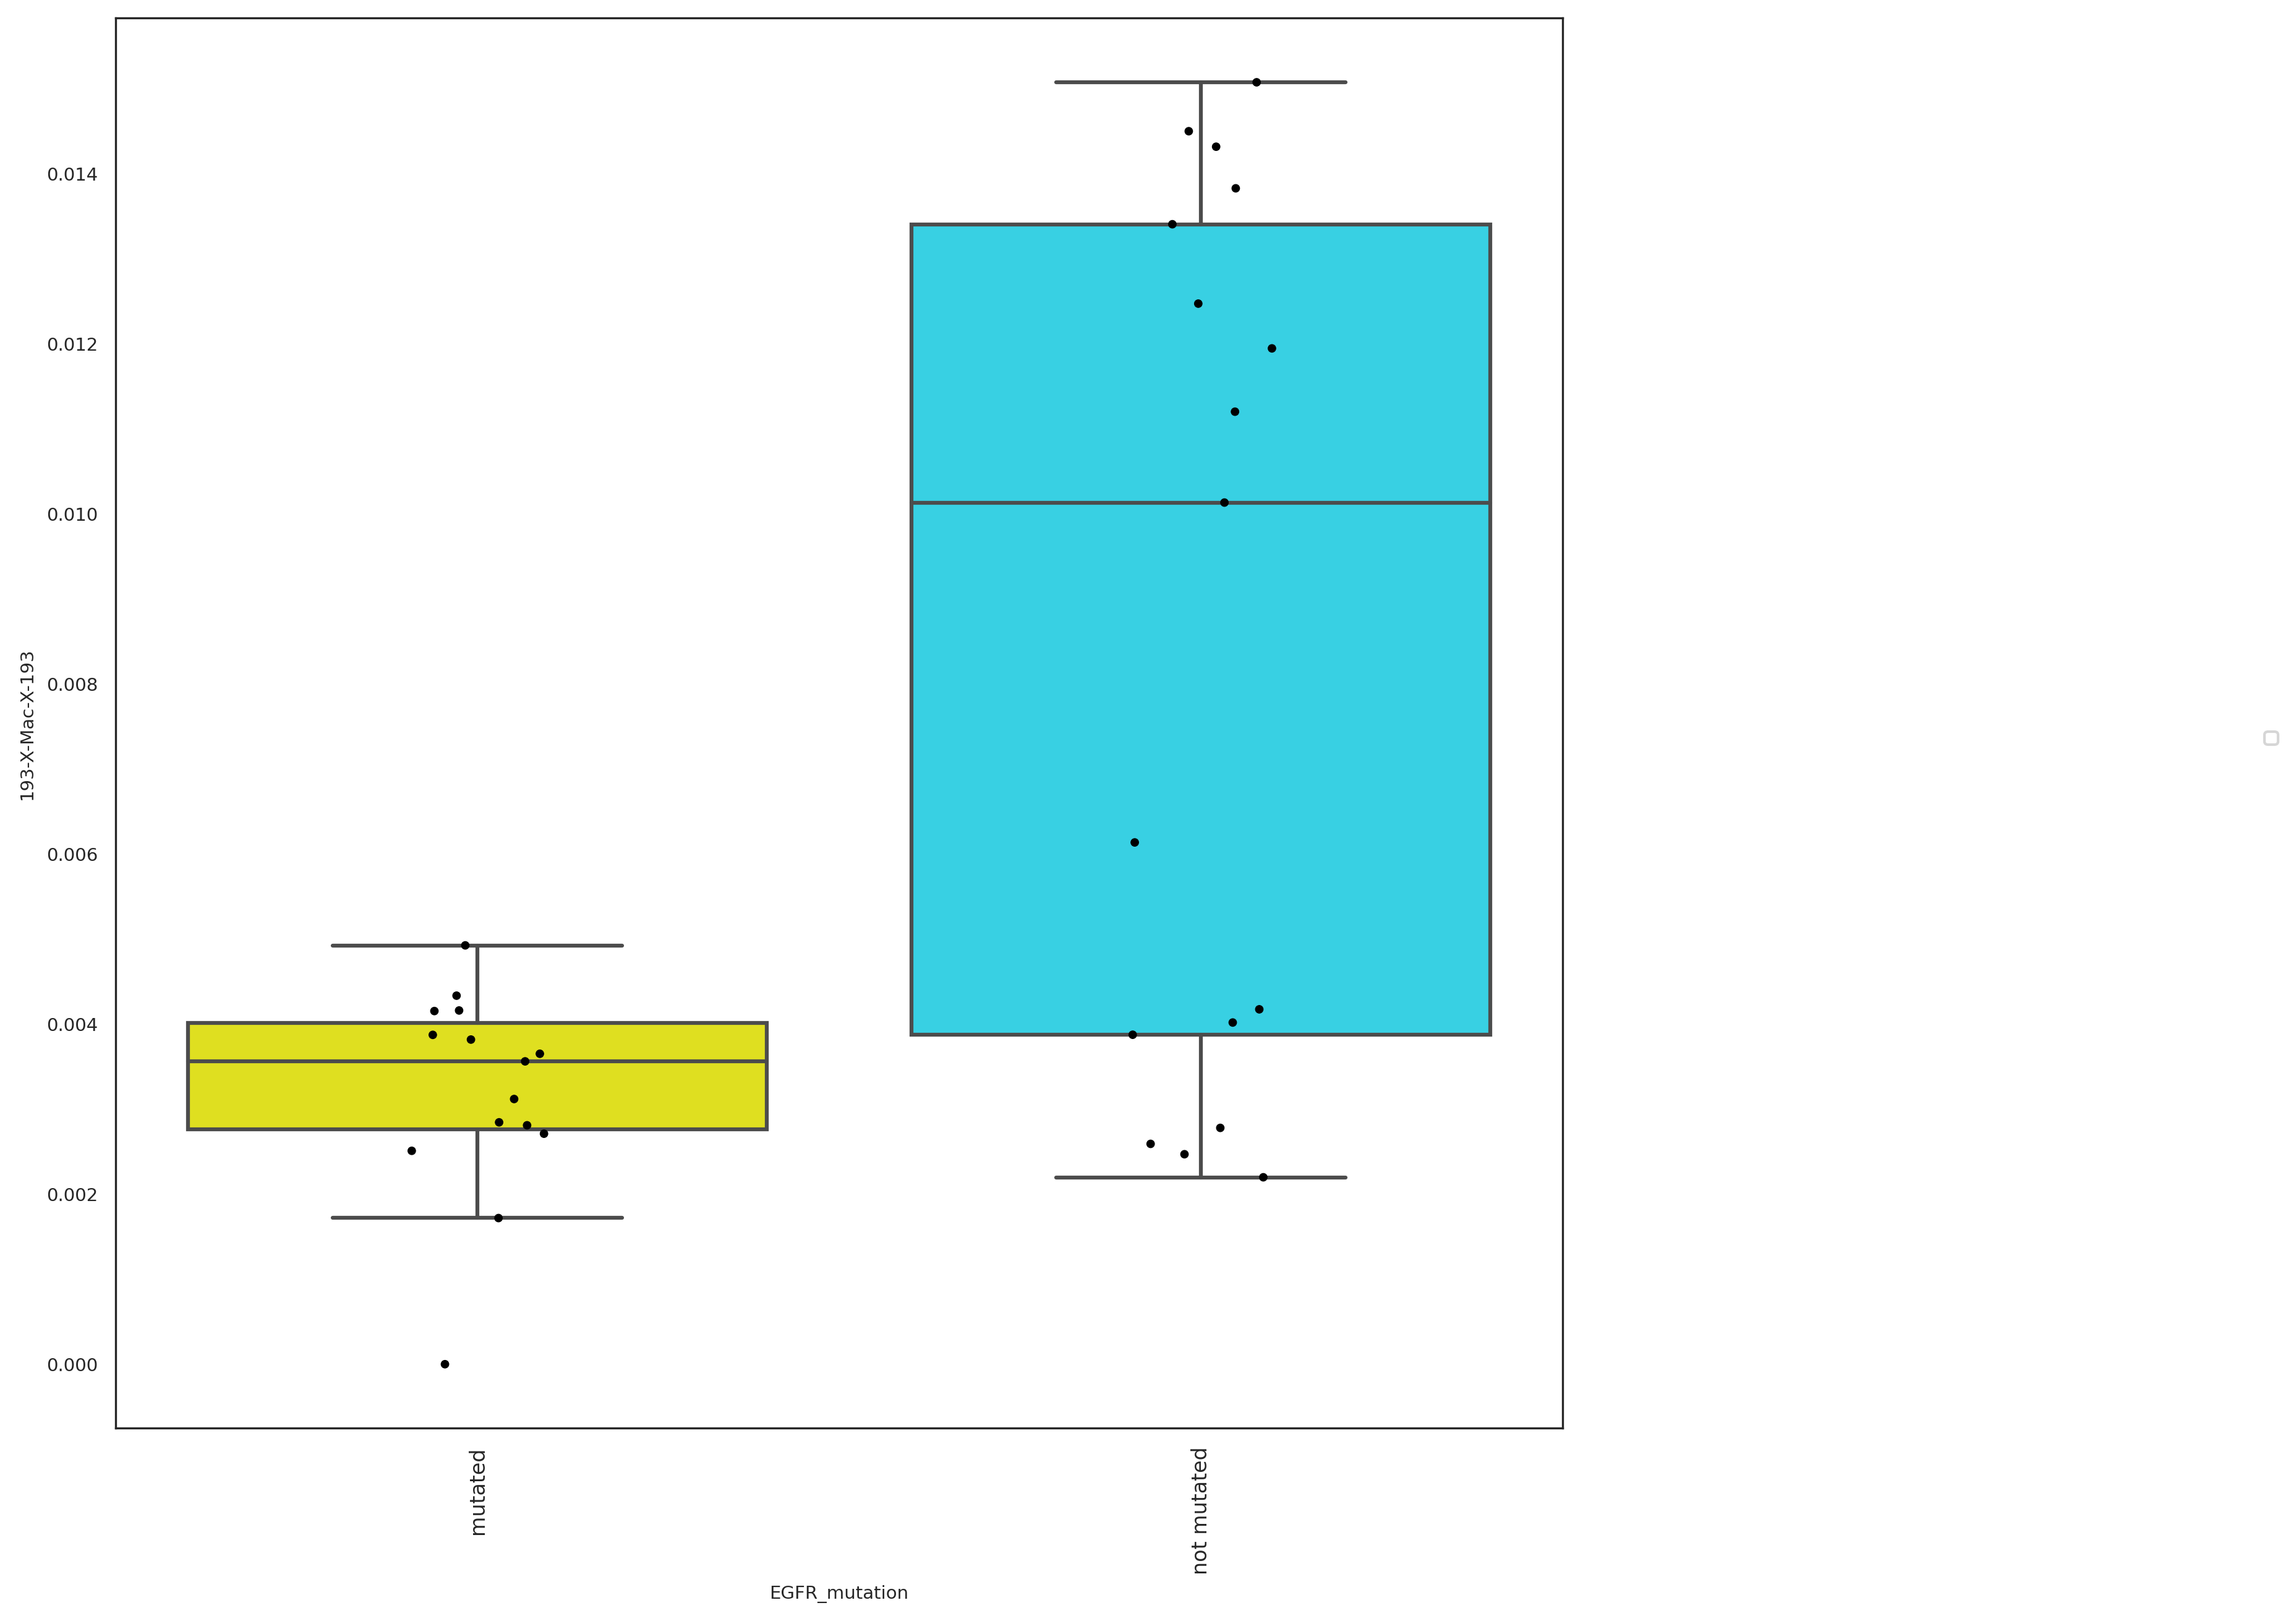

In [136]:
#plot
factor='193-X-Mac-X-193'
save_name ='Salcher_patient_CD8_EGFR_mutationr'+factor+'.svg'
hue_order = ['non-mutated','mutated']
plt.subplots(figsize=(10,10))
sns.boxplot(data=mean_df,x='EGFR_mutation', 
                y=factor, hue=None, hue_order=None, #order=hue_order, 
                orient=None, color=None, palette=color_map_clusters_nogrey, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=mean_df,x='EGFR_mutation', 
                y=factor, hue=None, hue_order=None, #order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
mean_df.to_csv(fig_save_path+ save_name[:-4]+'.csv')
print(save_name)

In [85]:
mean_df_test = mean_df.copy()
mean_df_test = mean_df_test[mean_df_test['smoke'].isin(['yes','no'])]
mean_df_test['smoke']  = mean_df_test['smoke'] =='yes'
print(mean_df_test['smoke'].value_counts())
two_sample_test(mean_df_test,'193-X-Mac-X-193', 
                'smoke',sample_column=None, test='mann-whitney')

True     96
False    51
Name: smoke, dtype: int64


(MannwhitneyuResult(statistic=2928.0, pvalue=0.05101504936295435),
 0.3008137782618239)

In [86]:
mean_df_test = mean_df.copy()
mean_df_test = mean_df_test[mean_df_test['EGFR_mutation'].isin(['mutated','not mutated'])]
mean_df_test['EGFR_mutation']  = mean_df_test['EGFR_mutation'] =='mutated'
print(mean_df_test['EGFR_mutation'].value_counts())
two_sample_test(mean_df_test,'193-X-Mac-X-193', 
                'EGFR_mutation',sample_column=None, test='mann-whitney')

False    17
True     15
Name: EGFR_mutation, dtype: int64


(MannwhitneyuResult(statistic=59.0, pvalue=0.0102326496302078),
 -1.17300505189237)